In [1]:
# Required imports
import os.path
from typing import Dict, Tuple, Optional
import torch as th
import numpy as np
import itertools

# Import modules from .py files
from equations import SystemEquations, compute_derivative, SecondOrderEquations, FourthOrderEquations, simpson_integral
from model import Configuration, Model
from modules import EquationsModel
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [ ]:
class PendulumChapter(SystemEquations):
    """
    Physics-informed NN for the simple pendulum x'' + sin(x) = 0,
    usingboth an action integral and a residual penalty.
    """
    def __init__(self, functions, domain, initial_conditions, *, coeffs: tuple[float, float, float] = (1.0, 1.0, 1.0)):
        super().__init__(functions, domain, initial_conditions)
        a, b, c = coeffs
        self.coeffs = {"action": a, "dynamics": b, "hamiltonian": c}

    def configuration(self):
        cfg = super().configuration()
        cfg["coefficients"] = self.coeffs
        return cfg

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:

        real = self.calculate_trial_solution(inputs, outputs)
        
        # 2) their time-derivatives
        deriv = {
            fn: compute_derivative(inputs, val)
            for fn, val in real.items()
        }
        
        # 3) residual penalties enforcing x' = y and y' = −sin(x)
        mse_d = th.nn.MSELoss(reduction='sum')
        pen1 = mse_d(deriv["x"], real["y"])
        pen2 = mse_d(deriv["y"], -th.sin(real["x"]))
        mse_dynamics = pen1 + pen2

        mse_h = th.nn.MSELoss(reduction='sum')
        H = 0.5 * real["y"]**2 + (1.0 - th.cos(real["x"]))
        x0 = real["x"][0]
        y0 = real["y"][0]
        H0 = 0.5 * y0**2 + (1.0 - th.cos(x0))
        H0_t = H.new_ones(H.shape) * H0
        mse_hamiltonian = mse_h(H, H0_t)
        
        
        # 4) pendulum Lagrangian L = ½ y² − (1 − cos x)
        L = 0.5 * real["y"]**2 - (1.0 - th.cos(real["x"]))
        action = th.trapz(L.view(-1), inputs.view(-1))
        #action = simpson_integral(L.view(-1), inputs.view(-1))
        
        # 5) combine (you can tune a,b if you like)
        a, b, c = self.coeffs["action"], self.coeffs["dynamics"], self.coeffs["hamiltonian"]
        total = a*action + b*mse_dynamics + c*mse_hamiltonian

        return {"total": total, "dynamics": mse_dynamics, "hamiltonian": mse_hamiltonian}

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = -np.sin(x)
        return [dxdt, dydt]

In [ ]:
def main():
    lr_grid      = [1e-3, 1e-4, 1e-5]
    coeffs_grid = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0), (1.0, 1.0, 1.0)]

    for lr in lr_grid:
        for _coeffs in coeffs_grid:
            configuration = Configuration(
                seed=4235,
                features=[64, 64, 64, 64, 64],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs =20_000,
                steps=10_000,
            )

            system_equations = PendulumChapter(
                functions=["x", "y"],
                domain=(0,10),
                initial_conditions={
                    "x": (0, np.pi/2),   # θ(0)=0.5 rad
                    "y": (0, 0.0),  # θ'(0)=0.53 rad/s
                },
                coeffs = _coeffs
            )

            model = Model(
            name="simple-pendulum-vFinal2",
            configuration=configuration,
            system_equations=system_equations,
        )

            model.train()
            model.test3()

if __name__ == "__main__":
    main()

In [2]:
class PendulumChapter2nd(SecondOrderEquations):
    """
    Physics-informed NN for the simple pendulum x'' + sin(x) = 0,
    usingboth an action integral and a residual penalty.
    """
    def __init__(self, function, domain, initial_conditions, *, coeffs: tuple[float, float, float] = (1.0, 1.0, 1.0), boundary_type: str = "pvi"):
        super().__init__(function, domain, initial_conditions, boundary_type)
        a, b, c = coeffs
        self.coeffs = {"action": a, "dynamics": b, "hamiltonian": c}

    def configuration(self):
        config = super().configuration()
        config["coefficients"] = self.coeffs
        return config

    def equation(self, x, y, t):
        """
        Defines the second-order differential equation x'' = f(x, x', t).
        In this case, x'' = -sin(x).
        """
        return -np.sin(x)

    def calculate_loss(self, inputs: th.Tensor, outputs: Dict[str, th.Tensor]) -> th.Tensor:

        trial = self.calculate_trial_solution(inputs, outputs)
        x_trial, x_dot = trial["x"], trial["y"]
        x_double_dot = compute_derivative(inputs, x_dot)
        
        # 3) residual penalties enforcing x'' = −sin(x)
        mse_d = th.nn.MSELoss(reduction='sum')
        mse_dynamics = mse_d(x_double_dot, -th.sin(x_trial))

        mse_h = th.nn.MSELoss(reduction='sum')
        H = 0.5 * x_dot**2 + (1.0 - th.cos(x_trial))
        x0 = x_trial[0]
        y0 = x_dot[0]
        H0 = 0.5 * y0**2 + (1.0 - th.cos(x0))
        H0_t = H.new_ones(H.shape) * H0
        mse_hamiltonian = mse_h(H, H0_t)
        
        # 4) pendulum Lagrangian L = ½ y² − (1 − cos x)
        L = 0.5 * x_dot**2 - (1.0 - th.cos(x_trial))
        action = th.trapz(L.view(-1), inputs.view(-1))
        #action = simpson_integral(L.view(-1), inputs.view(-1))
        
        # 5) combine (you can tune a,b if you like)
        a, b, c = self.coeffs["action"], self.coeffs["dynamics"], self.coeffs["hamiltonian"]
        total = a*action + b*mse_dynamics + c*mse_hamiltonian

        return {"total": total, "dynamics": mse_dynamics, "hamiltonian": mse_hamiltonian}

    def system(self, t, z):
        x, y = z
        dxdt = y
        dydt = -np.sin(x)
        return [dxdt, dydt]

  0%|                                         | 2/20000 [00:00<50:20,  6.62it/s]

-13.789631802151042


  1%|▏                                      | 101/20000 [00:11<36:41,  9.04it/s]

-10.278053717431137


  1%|▍                                      | 201/20000 [00:23<31:36, 10.44it/s]

-11.363324612038337


  2%|▌                                    | 300/20000 [00:34<1:07:21,  4.87it/s]

-11.904566552558784


  2%|▊                                      | 401/20000 [00:48<33:20,  9.80it/s]

-11.753802829874914


  3%|▉                                      | 501/20000 [00:59<32:46,  9.92it/s]

-12.329250574123297


  3%|█▏                                     | 602/20000 [01:09<31:48, 10.16it/s]

-12.568089391028389


  4%|█▎                                     | 702/20000 [01:19<33:18,  9.66it/s]

-12.571609370663024


  4%|█▌                                     | 801/20000 [01:29<30:52, 10.37it/s]

-12.029033222498441


  5%|█▊                                     | 901/20000 [01:39<30:57, 10.28it/s]

-12.605553077925089


  5%|█▉                                    | 1001/20000 [01:49<31:28, 10.06it/s]

-12.675644736300026


  6%|██                                    | 1102/20000 [01:59<30:32, 10.31it/s]

-12.469357870384782


  6%|██▎                                   | 1201/20000 [02:09<30:39, 10.22it/s]

-12.762895134798816


  7%|██▍                                   | 1301/20000 [02:19<30:37, 10.18it/s]

-12.836368394371034


  7%|██▋                                   | 1401/20000 [02:28<30:10, 10.27it/s]

-12.79271979466714


  8%|██▊                                   | 1501/20000 [02:39<30:26, 10.13it/s]

-12.62694431198491


  8%|███                                   | 1601/20000 [02:48<30:22, 10.10it/s]

-12.856609735333496


  9%|███▏                                  | 1701/20000 [02:58<29:34, 10.31it/s]

-12.812765484831935


  9%|███▍                                  | 1802/20000 [03:08<28:42, 10.56it/s]

-12.88061106374882


 10%|███▌                                  | 1902/20000 [03:18<31:21,  9.62it/s]

-12.80441298769319


 10%|███▊                                  | 2001/20000 [03:27<29:11, 10.28it/s]

-12.668205124072658


 11%|███▉                                  | 2102/20000 [03:37<29:12, 10.21it/s]

-12.854809303488018


 11%|████▏                                 | 2201/20000 [03:47<28:24, 10.44it/s]

-12.643244966408545


 12%|████▎                                 | 2301/20000 [03:57<28:18, 10.42it/s]

-12.880116959128133


 12%|████▌                                 | 2402/20000 [04:07<29:15, 10.03it/s]

-12.842419889671529


 13%|████▊                                 | 2502/20000 [04:16<28:32, 10.22it/s]

-12.896678321191246


 13%|████▉                                 | 2602/20000 [04:26<28:21, 10.22it/s]

-12.91316002410111


 14%|█████▏                                | 2701/20000 [04:36<28:05, 10.26it/s]

-12.8919048992247


 14%|█████▎                                | 2801/20000 [04:46<27:27, 10.44it/s]

-12.88917371096731


 15%|█████▌                                | 2901/20000 [04:56<27:43, 10.28it/s]

-12.928517135319854


 15%|█████▋                                | 3001/20000 [05:05<27:37, 10.26it/s]

-12.746385478004434


 16%|█████▉                                | 3102/20000 [05:15<27:54, 10.09it/s]

-12.902165521667982


 16%|██████                                | 3201/20000 [05:25<27:23, 10.22it/s]

-12.920876635913636


 17%|██████▎                               | 3301/20000 [05:35<27:02, 10.29it/s]

-12.855905664268786


 17%|██████▍                               | 3402/20000 [05:45<28:57,  9.55it/s]

-12.904698711784341


 18%|██████▋                               | 3502/20000 [05:54<26:29, 10.38it/s]

-12.843987070522898


 18%|██████▊                               | 3601/20000 [06:04<26:30, 10.31it/s]

-12.924280506798526


 19%|███████                               | 3702/20000 [06:14<25:44, 10.55it/s]

-12.742252454718766


 19%|███████▏                              | 3802/20000 [06:23<25:12, 10.71it/s]

-12.783889430875451


 20%|███████▍                              | 3901/20000 [06:33<25:52, 10.37it/s]

-12.626298454650964


 20%|███████▌                              | 4001/20000 [06:43<25:04, 10.63it/s]

-12.890764448827955


 21%|███████▊                              | 4101/20000 [06:53<25:27, 10.41it/s]

-12.947437009055177


 21%|███████▉                              | 4201/20000 [07:03<25:05, 10.50it/s]

-12.914758486698677


 22%|████████▏                             | 4301/20000 [07:12<24:54, 10.50it/s]

-12.916846672853612


 22%|████████▎                             | 4401/20000 [07:22<25:17, 10.28it/s]

-12.95072213553312


 23%|████████▌                             | 4501/20000 [07:32<24:26, 10.57it/s]

-12.95044768665816


 23%|████████▋                             | 4602/20000 [07:41<24:10, 10.61it/s]

-12.673954017581405


 24%|████████▉                             | 4701/20000 [07:51<24:10, 10.55it/s]

-12.468530549178166


 24%|█████████                             | 4801/20000 [08:00<23:58, 10.57it/s]

-12.95042026290466


 25%|█████████▎                            | 4902/20000 [08:10<23:56, 10.51it/s]

-12.959259420479558


 25%|█████████▌                            | 5002/20000 [08:20<23:57, 10.43it/s]

-12.89396176586146


 26%|█████████▋                            | 5102/20000 [08:29<23:52, 10.40it/s]

-12.697233359922054


 26%|█████████▉                            | 5202/20000 [08:39<23:47, 10.37it/s]

-12.913513149555024


 27%|██████████                            | 5301/20000 [08:49<23:32, 10.41it/s]

-12.972831299850721


 27%|██████████▎                           | 5401/20000 [08:58<23:13, 10.48it/s]

-12.931445801773794


 28%|██████████▍                           | 5501/20000 [09:08<22:53, 10.56it/s]

-12.944786962056627


 28%|██████████▋                           | 5601/20000 [09:18<23:08, 10.37it/s]

-12.95780170571561


 29%|██████████▊                           | 5701/20000 [09:27<22:35, 10.55it/s]

-12.922580563509694


 29%|███████████                           | 5801/20000 [09:37<23:36, 10.02it/s]

-12.988354162216519


 30%|███████████▏                          | 5901/20000 [09:47<22:59, 10.22it/s]

-12.9301961665666


 30%|███████████▍                          | 6002/20000 [09:57<22:28, 10.38it/s]

-12.906324802533955


 31%|███████████▌                          | 6101/20000 [10:07<22:39, 10.22it/s]

-12.916634512560718


 31%|███████████▊                          | 6201/20000 [10:17<22:16, 10.33it/s]

-12.30884859295012


 32%|███████████▉                          | 6302/20000 [10:26<21:44, 10.50it/s]

-12.945301345397207


 32%|████████████▏                         | 6401/20000 [10:36<21:48, 10.39it/s]

-12.962047458912293


 33%|████████████▎                         | 6501/20000 [10:46<22:06, 10.17it/s]

-12.854587451593215


 33%|████████████▌                         | 6601/20000 [10:56<21:29, 10.39it/s]

-12.99167335853961


 34%|████████████▋                         | 6702/20000 [11:06<21:50, 10.15it/s]

-12.992740219844691


 34%|████████████▉                         | 6802/20000 [11:16<22:26,  9.80it/s]

-12.966947956332922


 35%|█████████████                         | 6902/20000 [11:26<21:32, 10.13it/s]

-12.986259675591384


 35%|█████████████▎                        | 7001/20000 [11:35<20:25, 10.60it/s]

-12.653946952545784


 36%|█████████████▍                        | 7101/20000 [11:45<21:09, 10.16it/s]

-12.655280495745492


 36%|█████████████▋                        | 7201/20000 [11:55<22:46,  9.36it/s]

-12.994922070163502


 37%|█████████████▊                        | 7301/20000 [12:05<20:55, 10.11it/s]

-12.995755070798682


 37%|██████████████                        | 7402/20000 [12:15<20:16, 10.36it/s]

-12.93020290552723


 38%|██████████████▎                       | 7502/20000 [12:25<19:52, 10.48it/s]

-12.927497287787267


 38%|██████████████▍                       | 7601/20000 [12:35<20:35, 10.04it/s]

-12.990847029092674


 38%|██████████████▋                       | 7700/20000 [12:44<19:51, 10.32it/s]

-12.997319067448728


 39%|██████████████▊                       | 7801/20000 [12:54<20:18, 10.01it/s]

-12.998589593510864


 40%|███████████████                       | 7901/20000 [13:04<19:46, 10.19it/s]

-16.988154349762752


 40%|███████████████▏                      | 8001/20000 [13:14<19:20, 10.34it/s]

-18.398925279006683


 41%|███████████████▍                      | 8102/20000 [13:24<19:25, 10.21it/s]

-18.419374942300976


 41%|███████████████▌                      | 8200/20000 [13:33<19:02, 10.33it/s]

-18.517516104407747


 42%|███████████████▊                      | 8301/20000 [13:43<19:07, 10.20it/s]

-18.551073753006964


 42%|███████████████▉                      | 8402/20000 [13:53<18:36, 10.39it/s]

-18.571072430163753


 43%|████████████████▏                     | 8502/20000 [14:03<18:28, 10.37it/s]

-18.580246610587185


 43%|████████████████▎                     | 8601/20000 [14:13<18:25, 10.31it/s]

-17.987388229652872


 44%|████████████████▌                     | 8701/20000 [14:22<18:24, 10.23it/s]

-17.583245772782


 44%|████████████████▋                     | 8802/20000 [14:32<18:57,  9.85it/s]

-17.66327945726642


 45%|████████████████▉                     | 8902/20000 [14:42<17:53, 10.34it/s]

-18.412841146876048


 45%|█████████████████                     | 9001/20000 [14:52<17:36, 10.41it/s]

-18.603685262919555


 46%|█████████████████▎                    | 9102/20000 [15:02<19:32,  9.29it/s]

-18.61779210075976


 46%|█████████████████▍                    | 9201/20000 [15:12<17:22, 10.36it/s]

-18.628023471997597


 47%|█████████████████▋                    | 9301/20000 [15:22<17:34, 10.14it/s]

-18.629019532847998


 47%|█████████████████▊                    | 9401/20000 [15:31<17:10, 10.29it/s]

-18.63600665438701


 48%|██████████████████                    | 9502/20000 [15:41<16:55, 10.34it/s]

-18.52658806077426


 48%|██████████████████▏                   | 9602/20000 [15:51<16:35, 10.45it/s]

-18.61925168616618


 49%|██████████████████▍                   | 9701/20000 [16:01<16:37, 10.32it/s]

-18.636964185496442


 49%|██████████████████▌                   | 9801/20000 [16:11<17:41,  9.61it/s]

-18.591538857171408


 50%|██████████████████▊                   | 9901/20000 [16:21<16:19, 10.31it/s]

-18.645530253026585


 50%|██████████████████▌                  | 10002/20000 [16:31<16:42,  9.98it/s]

-18.24708636477167


 51%|██████████████████▋                  | 10101/20000 [16:41<16:09, 10.21it/s]

-18.648290211185355


 51%|██████████████████▊                  | 10202/20000 [16:51<15:58, 10.22it/s]

-18.11591296040617


 52%|███████████████████                  | 10302/20000 [17:00<15:43, 10.28it/s]

-18.65066584877696


 52%|███████████████████▏                 | 10402/20000 [17:10<15:31, 10.31it/s]

-18.61288413432911


 53%|███████████████████▍                 | 10501/20000 [17:20<15:34, 10.17it/s]

-18.635439019371546


 53%|███████████████████▌                 | 10601/20000 [17:30<15:08, 10.34it/s]

-18.663734439682052


 54%|███████████████████▊                 | 10701/20000 [17:40<15:18, 10.13it/s]

-18.62996557662046


 54%|███████████████████▉                 | 10801/20000 [17:50<14:42, 10.42it/s]

-18.655749205112325


 55%|████████████████████▏                | 10902/20000 [18:00<15:37,  9.71it/s]

-18.595582078047947


 55%|████████████████████▎                | 11001/20000 [18:10<14:51, 10.09it/s]

-18.661709030615466


 56%|████████████████████▌                | 11101/20000 [18:20<14:21, 10.33it/s]

-18.64593324167771


 56%|████████████████████▋                | 11201/20000 [18:30<14:11, 10.33it/s]

-18.674670143992984


 57%|████████████████████▉                | 11301/20000 [18:40<14:19, 10.12it/s]

-18.44917457776259


 57%|█████████████████████                | 11402/20000 [18:50<14:10, 10.11it/s]

-18.209395695052116


 58%|█████████████████████▎               | 11502/20000 [19:00<14:01, 10.10it/s]

-18.659170425997598


 58%|█████████████████████▍               | 11601/20000 [19:11<14:38,  9.57it/s]

-18.662138909012683


 59%|█████████████████████▋               | 11702/20000 [19:21<13:51,  9.99it/s]

-18.67405609129321


 59%|█████████████████████▊               | 11801/20000 [19:31<13:13, 10.34it/s]

-18.680564773264337


 60%|██████████████████████               | 11902/20000 [19:41<13:47,  9.78it/s]

-18.57077044587312


 60%|██████████████████████▏              | 12002/20000 [19:51<13:11, 10.11it/s]

-18.66874683538761


 61%|██████████████████████▍              | 12101/20000 [20:01<12:38, 10.41it/s]

-18.64572151763855


 61%|██████████████████████▌              | 12202/20000 [20:12<12:56, 10.05it/s]

-18.674393047662747


 62%|██████████████████████▊              | 12302/20000 [20:21<12:53,  9.95it/s]

-16.702899243957987


 62%|██████████████████████▉              | 12402/20000 [20:32<13:07,  9.64it/s]

-18.385043750555553


 63%|███████████████████████▏             | 12501/20000 [20:42<12:21, 10.11it/s]

-18.48379827885101


 63%|███████████████████████▎             | 12602/20000 [20:52<12:34,  9.81it/s]

-18.52341898072011


 64%|███████████████████████▍             | 12702/20000 [21:02<12:47,  9.51it/s]

-17.628181199866418


 64%|███████████████████████▋             | 12802/20000 [21:13<12:44,  9.41it/s]

-18.593436628322355


 65%|███████████████████████▊             | 12901/20000 [21:23<12:07,  9.76it/s]

-18.599087220111123


 65%|████████████████████████             | 13001/20000 [21:33<12:00,  9.71it/s]

-18.585387703119757


 66%|████████████████████████▏            | 13102/20000 [21:44<11:22, 10.11it/s]

-18.628634216910775


 66%|████████████████████████▍            | 13201/20000 [21:54<11:21,  9.98it/s]

-18.62920498723566


 67%|████████████████████████▌            | 13301/20000 [22:04<11:00, 10.14it/s]

-18.617819311135065


 67%|████████████████████████▊            | 13402/20000 [22:14<11:33,  9.52it/s]

-18.6485014035515


 68%|████████████████████████▉            | 13501/20000 [22:24<10:35, 10.23it/s]

-18.646185036033813


 68%|█████████████████████████▏           | 13601/20000 [22:35<11:54,  8.95it/s]

-18.628992761212643


 69%|█████████████████████████▎           | 13702/20000 [22:46<10:58,  9.56it/s]

-18.659197293183002


 69%|█████████████████████████▌           | 13802/20000 [22:57<10:02, 10.29it/s]

-18.66214576525402


 70%|█████████████████████████▋           | 13902/20000 [23:06<10:12,  9.96it/s]

-18.659642932686253


 70%|█████████████████████████▉           | 14002/20000 [23:17<10:30,  9.51it/s]

-18.642356662450613


 71%|██████████████████████████           | 14102/20000 [23:27<10:13,  9.61it/s]

-18.48265238132212


 71%|██████████████████████████▎          | 14202/20000 [23:37<09:40,  9.98it/s]

-18.673641472655163


 72%|██████████████████████████▍          | 14301/20000 [23:47<09:27, 10.04it/s]

-18.676403156496725


 72%|██████████████████████████▋          | 14402/20000 [23:57<09:03, 10.30it/s]

-18.677684304649716


 73%|██████████████████████████▊          | 14502/20000 [24:07<09:32,  9.61it/s]

-18.678453015695414


 73%|███████████████████████████          | 14601/20000 [24:17<08:55, 10.08it/s]

-18.678853205054253


 74%|███████████████████████████▏         | 14701/20000 [24:27<08:43, 10.13it/s]

-18.677452929515376


 74%|███████████████████████████▍         | 14801/20000 [24:38<08:33, 10.13it/s]

-18.675586654098286


 75%|███████████████████████████▌         | 14902/20000 [24:48<08:40,  9.79it/s]

-18.67667036904651


 75%|███████████████████████████▊         | 15002/20000 [24:58<08:19, 10.00it/s]

-18.677294900877428


 76%|███████████████████████████▉         | 15102/20000 [25:08<08:29,  9.61it/s]

-18.66982604723909


 76%|████████████████████████████         | 15202/20000 [25:19<08:19,  9.60it/s]

-18.67701367360513


 77%|████████████████████████████▎        | 15302/20000 [25:29<08:22,  9.35it/s]

-18.672465476163993


 77%|████████████████████████████▍        | 15402/20000 [25:40<08:04,  9.49it/s]

-18.68152343622966


 78%|████████████████████████████▋        | 15502/20000 [25:51<07:51,  9.53it/s]

-18.68077643666259


 78%|████████████████████████████▊        | 15602/20000 [26:01<07:32,  9.71it/s]

-18.688052570350877


 79%|█████████████████████████████        | 15702/20000 [26:12<07:42,  9.30it/s]

-18.68758796860007


 79%|█████████████████████████████▏       | 15802/20000 [26:23<07:59,  8.75it/s]

-18.68610590670582


 80%|█████████████████████████████▍       | 15902/20000 [26:33<07:21,  9.29it/s]

-18.691595531685145


 80%|█████████████████████████████▌       | 16002/20000 [26:44<07:06,  9.37it/s]

-18.69172785633471


 81%|█████████████████████████████▊       | 16102/20000 [26:54<06:44,  9.65it/s]

-18.697104511389085


 81%|█████████████████████████████▉       | 16202/20000 [27:05<06:41,  9.45it/s]

-18.613792438854055


 82%|██████████████████████████████▏      | 16302/20000 [27:16<06:58,  8.83it/s]

-18.678871445428875


 82%|██████████████████████████████▎      | 16401/20000 [27:26<06:20,  9.45it/s]

-18.698644548042534


 83%|██████████████████████████████▌      | 16502/20000 [27:38<06:00,  9.69it/s]

-18.01060039857941


 83%|██████████████████████████████▋      | 16602/20000 [27:48<05:56,  9.52it/s]

-18.66336322796468


 84%|██████████████████████████████▉      | 16702/20000 [27:59<05:59,  9.18it/s]

-18.687381941965594


 84%|███████████████████████████████      | 16802/20000 [28:09<05:47,  9.21it/s]

-18.654704490489625


 85%|███████████████████████████████▎     | 16901/20000 [28:20<05:34,  9.28it/s]

-18.700569191763705


 85%|███████████████████████████████▍     | 17001/20000 [28:30<05:14,  9.55it/s]

-18.70668626509534


 86%|███████████████████████████████▋     | 17102/20000 [28:41<05:00,  9.63it/s]

-18.643872823375425


 86%|███████████████████████████████▊     | 17202/20000 [28:52<04:59,  9.33it/s]

-9.316913482933863


 87%|████████████████████████████████     | 17302/20000 [29:02<04:41,  9.58it/s]

-18.284978280892478


 87%|████████████████████████████████▏    | 17402/20000 [29:13<04:31,  9.57it/s]

-18.497029601506135


 88%|████████████████████████████████▍    | 17502/20000 [29:24<04:28,  9.31it/s]

-17.922845466293168


 88%|████████████████████████████████▌    | 17602/20000 [29:35<04:15,  9.39it/s]

-18.54174667495174


 89%|████████████████████████████████▋    | 17701/20000 [29:45<04:06,  9.31it/s]

-18.59976764467214


 89%|████████████████████████████████▉    | 17802/20000 [29:56<03:54,  9.38it/s]

-18.588666866125127


 90%|█████████████████████████████████    | 17902/20000 [30:07<03:46,  9.25it/s]

-18.639582538878074


 90%|█████████████████████████████████▎   | 18002/20000 [30:17<03:36,  9.21it/s]

-18.641876410799505


 91%|█████████████████████████████████▍   | 18102/20000 [30:28<03:20,  9.48it/s]

-18.605344724097936


 91%|█████████████████████████████████▋   | 18202/20000 [30:39<03:11,  9.40it/s]

-18.66173894612658


 92%|█████████████████████████████████▊   | 18302/20000 [30:49<02:57,  9.54it/s]

-18.657741384565952


 92%|██████████████████████████████████   | 18402/20000 [31:00<02:50,  9.36it/s]

-18.675180296155624


 93%|██████████████████████████████████▏  | 18502/20000 [31:11<02:41,  9.28it/s]

-18.673893104652734


 93%|██████████████████████████████████▍  | 18602/20000 [31:22<02:27,  9.45it/s]

-18.6078855768545


 94%|██████████████████████████████████▌  | 18702/20000 [31:33<02:14,  9.64it/s]

-18.685281830924634


 94%|██████████████████████████████████▊  | 18802/20000 [31:44<02:11,  9.10it/s]

-18.685257938914468


 95%|██████████████████████████████████▉  | 18902/20000 [31:55<02:03,  8.89it/s]

-18.372464287296328


 95%|███████████████████████████████████▏ | 19001/20000 [32:05<01:52,  8.90it/s]

-18.696995224006326


 96%|███████████████████████████████████▎ | 19101/20000 [32:16<01:38,  9.15it/s]

-18.698336616724248


 96%|███████████████████████████████████▌ | 19202/20000 [32:27<01:27,  9.14it/s]

-18.69722030263506


 97%|███████████████████████████████████▋ | 19302/20000 [32:37<01:13,  9.51it/s]

-18.70147454745577


 97%|███████████████████████████████████▉ | 19402/20000 [32:47<01:03,  9.43it/s]

-18.70435208998879


 98%|████████████████████████████████████ | 19502/20000 [32:58<00:50,  9.89it/s]

-18.707928283596228


 98%|████████████████████████████████████▎| 19602/20000 [33:08<00:41,  9.54it/s]

-18.708710902577504


 99%|████████████████████████████████████▍| 19702/20000 [33:18<00:31,  9.43it/s]

-18.713619616549792


 99%|████████████████████████████████████▋| 19802/20000 [33:28<00:19, 10.14it/s]

-18.55099317216952


100%|████████████████████████████████████▊| 19902/20000 [33:39<00:10,  9.69it/s]

-18.688180548310992


100%|█████████████████████████████████████| 20000/20000 [33:50<00:00,  9.85it/s]


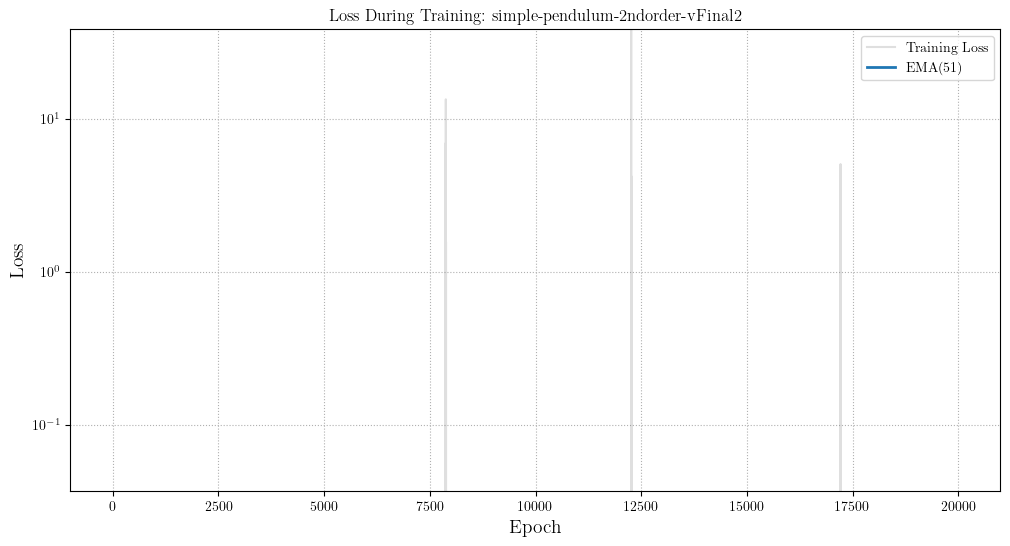

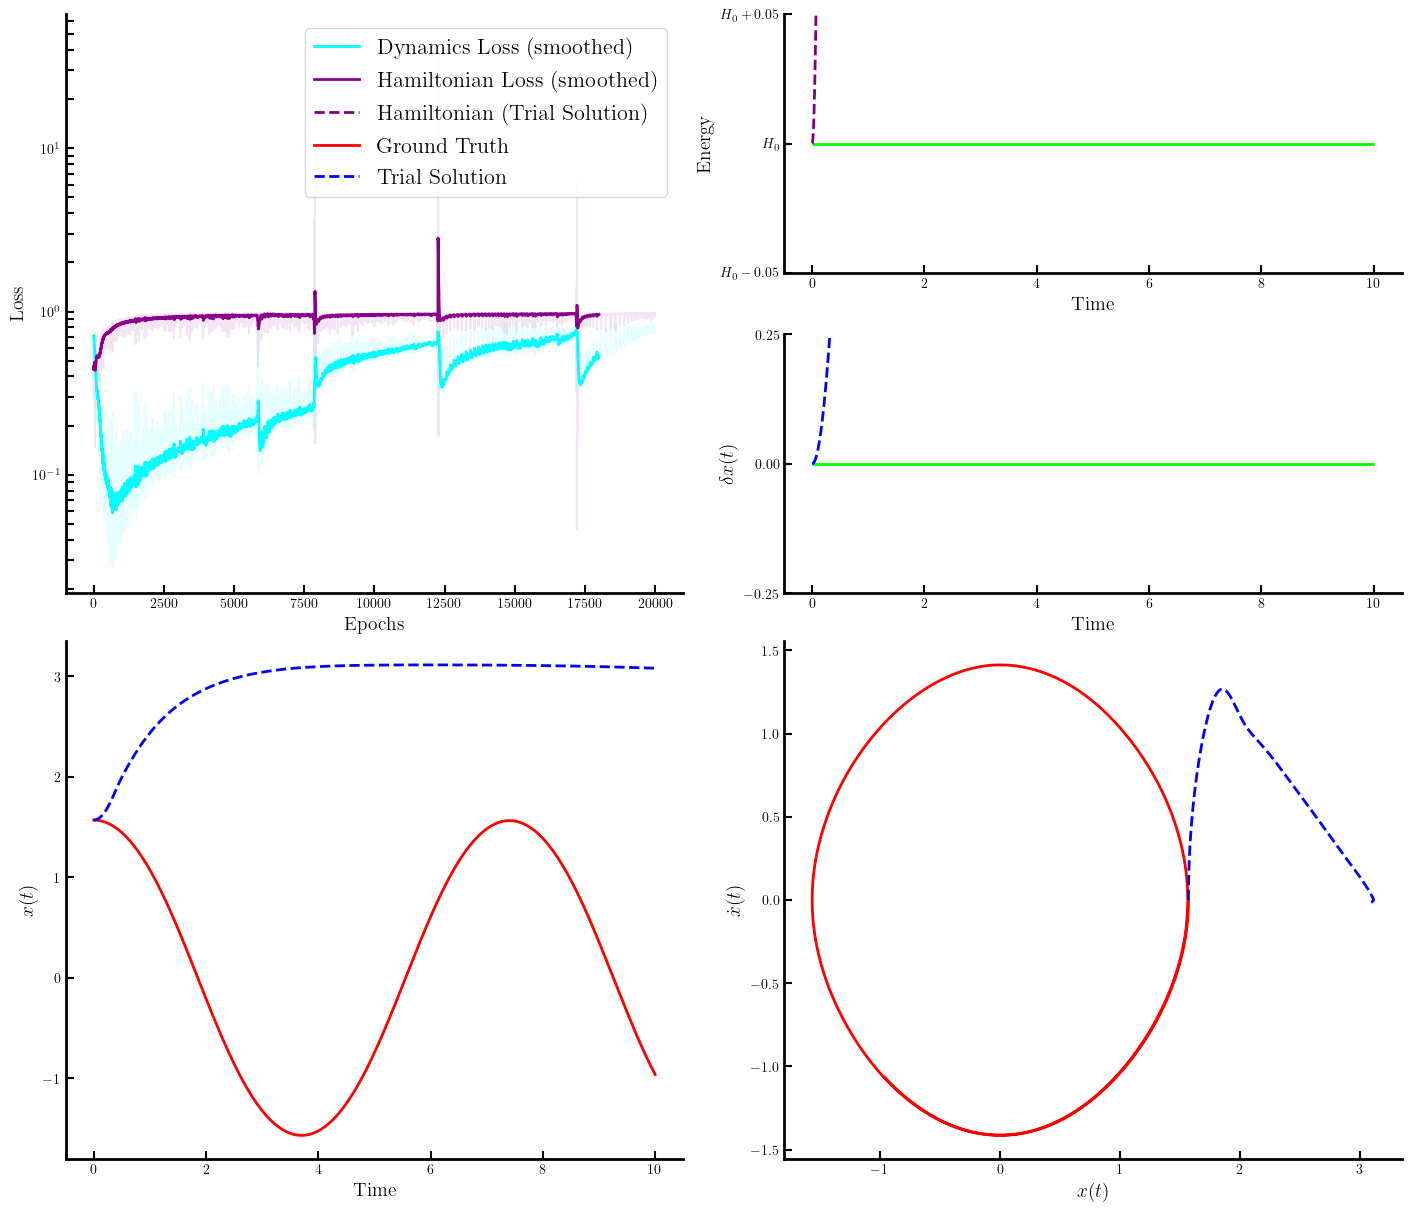

  0%|                                         | 2/20000 [00:00<38:00,  8.77it/s]

7110.712831348228


  1%|▏                                      | 102/20000 [00:09<31:39, 10.48it/s]

2181.344302354845


  1%|▍                                      | 202/20000 [00:19<31:42, 10.41it/s]

4757.822439385314


  2%|▌                                      | 302/20000 [00:29<31:02, 10.57it/s]

927.171971834304


  2%|▊                                      | 402/20000 [00:38<33:20,  9.79it/s]

607.3494934121516


  3%|▉                                      | 501/20000 [00:48<31:05, 10.45it/s]

624.5713176241901


  3%|█▏                                     | 601/20000 [00:58<31:53, 10.14it/s]

535.2872208767426


  4%|█▎                                     | 701/20000 [01:08<30:56, 10.39it/s]

466.025416951259


  4%|█▌                                     | 801/20000 [01:18<31:31, 10.15it/s]

553.4887986308734


  5%|█▊                                     | 902/20000 [01:28<30:56, 10.29it/s]

359.1222319413364


  5%|█▉                                    | 1002/20000 [01:37<30:08, 10.50it/s]

4303.111434492921


  6%|██                                    | 1102/20000 [01:47<31:03, 10.14it/s]

2418.155288960329


  6%|██▎                                   | 1201/20000 [01:58<31:41,  9.89it/s]

1465.1226916193727


  7%|██▍                                   | 1301/20000 [02:07<31:02, 10.04it/s]

2766.836513503014


  7%|██▋                                   | 1401/20000 [02:18<30:35, 10.14it/s]

616.7925310106473


  8%|██▊                                   | 1502/20000 [02:28<30:27, 10.12it/s]

374.0292377239249


  8%|███                                   | 1601/20000 [02:38<32:49,  9.34it/s]

348.30520645709476


  9%|███▏                                  | 1702/20000 [02:49<30:59,  9.84it/s]

260.2743848177155


  9%|███▍                                  | 1802/20000 [02:59<32:01,  9.47it/s]

257.754908772757


 10%|███▌                                  | 1901/20000 [03:10<31:17,  9.64it/s]

199.08085687631103


 10%|███▊                                  | 2002/20000 [03:21<30:13,  9.92it/s]

233.86321591213238


 11%|███▉                                  | 2102/20000 [03:31<31:12,  9.56it/s]

231.2036045004196


 11%|████▏                                 | 2201/20000 [03:42<31:10,  9.51it/s]

227.99277283429987


 12%|████▎                                 | 2302/20000 [03:52<30:05,  9.80it/s]

225.7730973680416


 12%|████▌                                 | 2402/20000 [04:02<30:41,  9.55it/s]

224.02141010752783


 13%|████▊                                 | 2501/20000 [04:13<30:50,  9.46it/s]

222.57082083047885


 13%|████▉                                 | 2602/20000 [04:23<28:47, 10.07it/s]

221.33122404058219


 14%|█████▏                                | 2701/20000 [04:33<29:04,  9.91it/s]

220.24115578123093


 14%|█████▎                                | 2801/20000 [04:44<29:59,  9.56it/s]

219.25590535840828


 15%|█████▌                                | 2902/20000 [04:54<29:47,  9.57it/s]

218.34123699786625


 15%|█████▋                                | 3002/20000 [05:04<27:53, 10.15it/s]

217.47185594075512


 16%|█████▉                                | 3102/20000 [05:14<28:17,  9.95it/s]

216.63691652754716


 16%|██████                                | 3202/20000 [05:25<27:43, 10.10it/s]

215.85549957998626


 17%|██████▎                               | 3302/20000 [05:35<28:29,  9.77it/s]

215.17955852907443


 17%|██████▍                               | 3401/20000 [05:45<27:24, 10.10it/s]

214.63046276809752


 18%|██████▋                               | 3502/20000 [05:55<28:16,  9.72it/s]

214.14843350403575


 18%|██████▊                               | 3601/20000 [06:06<26:10, 10.44it/s]

213.6720049574833


 19%|███████                               | 3702/20000 [06:16<26:58, 10.07it/s]

213.187940597485


 19%|███████▏                              | 3802/20000 [06:26<26:28, 10.20it/s]

212.7038640538475


 20%|███████▍                              | 3902/20000 [06:36<26:07, 10.27it/s]

212.22726777804024


 20%|███████▌                              | 4002/20000 [06:46<28:01,  9.51it/s]

211.7620245984885


 21%|███████▊                              | 4101/20000 [06:56<26:06, 10.15it/s]

211.3096415567873


 21%|███████▉                              | 4202/20000 [07:06<26:47,  9.83it/s]

210.87049953303375


 22%|████████▏                             | 4302/20000 [07:17<27:49,  9.40it/s]

210.44450372102628


 22%|████████▎                             | 4402/20000 [07:27<26:57,  9.64it/s]

210.03135377338936


 23%|████████▌                             | 4501/20000 [07:37<25:26, 10.15it/s]

209.63063557672768


 23%|████████▋                             | 4601/20000 [07:47<25:24, 10.10it/s]

209.24193125672053


 24%|████████▉                             | 4702/20000 [07:58<26:45,  9.53it/s]

208.86577079850514


 24%|█████████                             | 4802/20000 [08:08<26:01,  9.73it/s]

208.51013832510216


 25%|█████████▎                            | 4902/20000 [08:18<24:58, 10.08it/s]

208.215111400943


 25%|█████████▌                            | 5001/20000 [08:28<24:56, 10.02it/s]

207.84616348858285


 26%|█████████▋                            | 5102/20000 [08:39<25:45,  9.64it/s]

200.2043597458566


 26%|█████████▉                            | 5202/20000 [08:49<25:05,  9.83it/s]

203.11123829962224


 27%|██████████                            | 5302/20000 [08:59<24:06, 10.16it/s]

185.9281308146083


 27%|██████████▎                           | 5402/20000 [09:09<25:47,  9.43it/s]

188.21691243422407


 28%|██████████▍                           | 5502/20000 [09:20<25:05,  9.63it/s]

244.203363535403


 28%|██████████▋                           | 5602/20000 [09:30<25:25,  9.44it/s]

208.90325402489353


 29%|██████████▊                           | 5702/20000 [09:41<25:57,  9.18it/s]

216.24388740162905


 29%|███████████                           | 5802/20000 [09:51<26:34,  8.91it/s]

187.44500365524655


 30%|███████████▏                          | 5902/20000 [10:02<24:52,  9.45it/s]

216.81062386297833


 30%|███████████▍                          | 6002/20000 [10:12<24:43,  9.44it/s]

207.88876868836098


 31%|███████████▌                          | 6102/20000 [10:23<23:58,  9.66it/s]

185.92606502145333


 31%|███████████▊                          | 6202/20000 [10:33<22:45, 10.10it/s]

197.4103124856042


 32%|███████████▉                          | 6302/20000 [10:44<24:22,  9.36it/s]

259.684518333985


 32%|████████████▏                         | 6402/20000 [10:55<23:10,  9.78it/s]

226.04828470998217


 33%|████████████▎                         | 6502/20000 [11:05<23:19,  9.65it/s]

189.69439359859172


 33%|████████████▌                         | 6601/20000 [11:15<21:54, 10.20it/s]

195.10032584046354


 34%|████████████▋                         | 6702/20000 [11:26<23:23,  9.47it/s]

191.86212350799408


 34%|████████████▉                         | 6802/20000 [11:36<22:43,  9.68it/s]

201.87925597195795


 35%|█████████████                         | 6902/20000 [11:47<22:29,  9.71it/s]

191.06752119217953


 35%|█████████████▎                        | 7002/20000 [11:57<22:26,  9.65it/s]

193.10409345740416


 36%|█████████████▍                        | 7102/20000 [12:08<22:20,  9.62it/s]

188.33453641746587


 36%|█████████████▋                        | 7202/20000 [12:18<21:50,  9.76it/s]

193.87061117202109


 37%|█████████████▊                        | 7302/20000 [12:29<22:16,  9.50it/s]

191.61047796909952


 37%|██████████████                        | 7402/20000 [12:39<22:07,  9.49it/s]

185.4977112279059


 38%|██████████████▎                       | 7502/20000 [12:50<21:44,  9.58it/s]

202.13524414121227


 38%|██████████████▍                       | 7602/20000 [13:01<21:59,  9.40it/s]

185.4137109726274


 39%|██████████████▋                       | 7702/20000 [13:12<25:23,  8.07it/s]

366.4414491117101


 39%|██████████████▊                       | 7801/20000 [13:22<23:59,  8.48it/s]

5369.092856105704


 40%|███████████████                       | 7902/20000 [13:33<21:59,  9.17it/s]

6376.786107600581


 40%|███████████████▏                      | 8002/20000 [13:44<22:00,  9.08it/s]

5558.432118904029


 41%|███████████████▍                      | 8102/20000 [13:55<21:16,  9.32it/s]

4598.468145834795


 41%|███████████████▌                      | 8202/20000 [14:05<20:53,  9.41it/s]

2267.4808537064473


 42%|███████████████▊                      | 8302/20000 [14:16<20:27,  9.53it/s]

466.38804614773187


 42%|███████████████▉                      | 8402/20000 [14:27<20:55,  9.24it/s]

293.464627783693


 43%|████████████████▏                     | 8502/20000 [14:37<21:44,  8.81it/s]

253.09249233018977


 43%|████████████████▎                     | 8602/20000 [14:48<20:24,  9.30it/s]

254.66772391001786


 44%|████████████████▌                     | 8702/20000 [14:59<20:07,  9.36it/s]

243.88773564786868


 44%|████████████████▋                     | 8802/20000 [15:10<20:13,  9.23it/s]

236.33496670226788


 45%|████████████████▉                     | 8902/20000 [15:20<19:47,  9.34it/s]

230.4920743643256


 45%|█████████████████                     | 9002/20000 [15:31<19:54,  9.21it/s]

226.95933365381185


 46%|█████████████████▎                    | 9102/20000 [15:42<18:56,  9.59it/s]

224.6855880117166


 46%|█████████████████▍                    | 9202/20000 [15:53<19:24,  9.28it/s]

223.1529525013059


 47%|█████████████████▋                    | 9302/20000 [16:04<19:42,  9.05it/s]

222.06361964203694


 47%|█████████████████▊                    | 9402/20000 [16:14<19:19,  9.14it/s]

221.23939909397885


 48%|██████████████████                    | 9502/20000 [16:25<18:19,  9.54it/s]

220.57310024312028


 48%|██████████████████▏                   | 9602/20000 [16:36<18:32,  9.35it/s]

219.99902019877095


 49%|██████████████████▍                   | 9702/20000 [16:46<17:40,  9.71it/s]

219.47796923098744


 49%|██████████████████▌                   | 9802/20000 [16:57<17:47,  9.55it/s]

218.98696020088605


 50%|██████████████████▊                   | 9901/20000 [17:08<17:43,  9.49it/s]

218.51306556130714


 50%|██████████████████▌                  | 10002/20000 [17:19<17:51,  9.33it/s]

218.04934317471162


 51%|██████████████████▋                  | 10101/20000 [17:29<20:11,  8.17it/s]

217.59237223278706


 51%|██████████████████▊                  | 10202/20000 [17:40<18:51,  8.66it/s]

217.14072639664326


 52%|███████████████████                  | 10302/20000 [17:51<17:14,  9.37it/s]

216.69404076477525


 52%|███████████████████▏                 | 10402/20000 [18:02<16:44,  9.56it/s]

216.25249022744228


 53%|███████████████████▍                 | 10502/20000 [18:12<16:59,  9.32it/s]

215.816504768762


 53%|███████████████████▌                 | 10602/20000 [18:23<16:33,  9.46it/s]

215.38660830540329


 54%|███████████████████▊                 | 10702/20000 [18:34<16:23,  9.45it/s]

214.96331049731074


 54%|███████████████████▉                 | 10802/20000 [18:45<16:25,  9.34it/s]

214.54696200842767


 55%|████████████████████▏                | 10902/20000 [18:55<16:14,  9.34it/s]

214.13744612093757


 55%|████████████████████▎                | 11002/20000 [19:06<16:01,  9.36it/s]

213.73426086740486


 56%|████████████████████▌                | 11102/20000 [19:17<15:45,  9.41it/s]

213.34538528465686


 56%|████████████████████▋                | 11202/20000 [19:28<15:58,  9.18it/s]

213.0668707831548


 57%|████████████████████▉                | 11302/20000 [19:39<15:27,  9.38it/s]

213.48826458135295


 57%|█████████████████████                | 11402/20000 [19:50<15:11,  9.43it/s]

214.47377864574432


 58%|█████████████████████▎               | 11502/20000 [20:00<15:10,  9.34it/s]

199.34841423314725


 58%|█████████████████████▍               | 11602/20000 [20:11<14:48,  9.45it/s]

197.0375046508043


 59%|█████████████████████▋               | 11702/20000 [20:22<14:53,  9.29it/s]

236.2017931687186


 59%|█████████████████████▊               | 11802/20000 [20:32<14:49,  9.22it/s]

207.78001123244263


 60%|██████████████████████               | 11902/20000 [20:43<14:30,  9.30it/s]

190.4051528249918


 60%|██████████████████████▏              | 12002/20000 [20:54<14:07,  9.43it/s]

204.28393379598236


 61%|██████████████████████▍              | 12102/20000 [21:04<13:30,  9.75it/s]

192.8540057051041


 61%|██████████████████████▌              | 12202/20000 [21:15<13:53,  9.36it/s]

207.77687563051452


 62%|██████████████████████▊              | 12302/20000 [21:26<13:43,  9.35it/s]

188.9060593184134


 62%|██████████████████████▉              | 12402/20000 [21:37<13:14,  9.57it/s]

202.83702917179764


 63%|███████████████████████▏             | 12502/20000 [21:47<13:29,  9.26it/s]

195.59059466871625


 63%|███████████████████████▎             | 12602/20000 [21:58<13:17,  9.27it/s]

255.74831612689354


 64%|███████████████████████▍             | 12702/20000 [22:08<12:45,  9.53it/s]

190.9427227466918


 64%|███████████████████████▋             | 12802/20000 [22:20<15:08,  7.92it/s]

205.28814730522086


 65%|███████████████████████▊             | 12902/20000 [22:30<12:29,  9.47it/s]

187.21142768603247


 65%|████████████████████████             | 13002/20000 [22:41<12:37,  9.24it/s]

205.09719510064212


 66%|████████████████████████▏            | 13102/20000 [22:52<12:35,  9.13it/s]

217.67499935646484


 66%|████████████████████████▍            | 13201/20000 [23:02<12:00,  9.44it/s]

222.14038994810818


 67%|████████████████████████▌            | 13302/20000 [23:13<12:15,  9.10it/s]

198.46300611637233


 67%|████████████████████████▊            | 13401/20000 [23:24<11:25,  9.63it/s]

232.16260863746407


 68%|████████████████████████▉            | 13502/20000 [23:34<11:19,  9.56it/s]

189.26135351931117


 68%|█████████████████████████▏           | 13602/20000 [23:45<11:30,  9.27it/s]

224.34478016267497


 69%|█████████████████████████▎           | 13702/20000 [23:56<10:44,  9.77it/s]

193.4063299738945


 69%|█████████████████████████▌           | 13802/20000 [24:06<11:00,  9.38it/s]

275.8241294270989


 70%|█████████████████████████▋           | 13902/20000 [24:17<10:51,  9.36it/s]

220.60154974321887


 70%|█████████████████████████▉           | 14002/20000 [24:28<10:36,  9.43it/s]

187.7062530034155


 71%|██████████████████████████           | 14102/20000 [24:38<10:26,  9.41it/s]

192.07864054602072


 71%|██████████████████████████▎          | 14202/20000 [24:49<10:07,  9.54it/s]

186.0197943995072


 72%|██████████████████████████▍          | 14302/20000 [25:00<10:09,  9.35it/s]

216.90536540388


 72%|██████████████████████████▋          | 14402/20000 [25:11<09:37,  9.69it/s]

186.03098749424046


 73%|██████████████████████████▊          | 14502/20000 [25:21<09:24,  9.74it/s]

193.66579575645594


 73%|███████████████████████████          | 14602/20000 [25:32<09:50,  9.14it/s]

200.62037604597725


 74%|███████████████████████████▏         | 14702/20000 [25:43<09:16,  9.52it/s]

185.428786682206


 74%|███████████████████████████▍         | 14802/20000 [25:54<09:22,  9.25it/s]

199.512257493672


 75%|███████████████████████████▌         | 14902/20000 [26:04<09:23,  9.04it/s]

189.87082910970054


 75%|███████████████████████████▊         | 15002/20000 [26:15<09:09,  9.10it/s]

197.92809481838657


 76%|███████████████████████████▉         | 15102/20000 [26:26<10:19,  7.91it/s]

198.17402786265876


 76%|████████████████████████████         | 15202/20000 [26:37<08:33,  9.35it/s]

261.32201813039376


 77%|████████████████████████████▎        | 15302/20000 [26:48<08:34,  9.14it/s]

199.90489356803073


 77%|████████████████████████████▍        | 15402/20000 [26:58<08:10,  9.38it/s]

206.49325512556464


 78%|████████████████████████████▋        | 15502/20000 [27:09<08:06,  9.24it/s]

194.05561502222082


 78%|████████████████████████████▊        | 15602/20000 [27:20<07:54,  9.26it/s]

204.47746261732175


 79%|█████████████████████████████        | 15702/20000 [27:31<07:37,  9.40it/s]

192.0884785951282


 79%|█████████████████████████████▏       | 15801/20000 [27:41<07:32,  9.29it/s]

189.1670790735788


 80%|█████████████████████████████▍       | 15902/20000 [27:52<07:08,  9.57it/s]

192.2069428430606


 80%|█████████████████████████████▌       | 16002/20000 [28:03<07:01,  9.47it/s]

189.2473850163047


 81%|█████████████████████████████▊       | 16102/20000 [28:14<07:27,  8.72it/s]

185.7562205516784


 81%|█████████████████████████████▉       | 16201/20000 [28:24<06:13, 10.18it/s]

192.77342392149257


 82%|██████████████████████████████▏      | 16302/20000 [28:34<06:05, 10.12it/s]

195.94395809807054


 82%|██████████████████████████████▎      | 16402/20000 [28:45<06:41,  8.95it/s]

201.34922416380766


 83%|██████████████████████████████▌      | 16502/20000 [28:56<06:10,  9.45it/s]

191.7940443669999


 83%|██████████████████████████████▋      | 16601/20000 [29:05<05:32, 10.24it/s]

239.5563045946978


 84%|██████████████████████████████▉      | 16702/20000 [29:16<05:03, 10.86it/s]

205.2919035500415


 84%|███████████████████████████████      | 16802/20000 [29:25<05:18, 10.03it/s]

190.08955376843988


 85%|███████████████████████████████▎     | 16902/20000 [29:35<04:48, 10.74it/s]

196.33798719922348


 85%|███████████████████████████████▍     | 17002/20000 [29:45<05:09,  9.69it/s]

194.01981148509827


 86%|███████████████████████████████▋     | 17102/20000 [29:55<04:42, 10.26it/s]

204.53409400818757


 86%|███████████████████████████████▊     | 17201/20000 [30:05<04:46,  9.77it/s]

187.21120203243945


 87%|████████████████████████████████     | 17302/20000 [30:14<04:45,  9.44it/s]

193.9785660873433


 87%|████████████████████████████████▏    | 17401/20000 [30:24<04:04, 10.63it/s]

198.97770127776568


 88%|████████████████████████████████▍    | 17501/20000 [30:33<03:44, 11.12it/s]

188.98812961998038


 88%|████████████████████████████████▌    | 17601/20000 [30:43<03:24, 11.76it/s]

247.4627208193432


 89%|████████████████████████████████▋    | 17701/20000 [30:51<03:16, 11.70it/s]

185.45439842136466


 89%|████████████████████████████████▉    | 17801/20000 [30:59<03:05, 11.88it/s]

186.4964101837055


 90%|█████████████████████████████████    | 17901/20000 [31:08<03:00, 11.61it/s]

199.01566406115992


 90%|█████████████████████████████████▎   | 18001/20000 [31:17<02:52, 11.56it/s]

204.66173271476276


 91%|█████████████████████████████████▍   | 18101/20000 [31:25<02:43, 11.61it/s]

189.6030638706094


 91%|█████████████████████████████████▋   | 18201/20000 [31:34<02:31, 11.90it/s]

188.21804213394697


 92%|█████████████████████████████████▊   | 18301/20000 [31:42<02:26, 11.58it/s]

191.41196763033645


 92%|██████████████████████████████████   | 18401/20000 [31:51<02:39, 10.01it/s]

189.53102848988652


 93%|██████████████████████████████████▏  | 18501/20000 [32:01<02:20, 10.64it/s]

187.58179903422433


 93%|██████████████████████████████████▍  | 18601/20000 [32:10<02:11, 10.64it/s]

190.13807010043317


 94%|██████████████████████████████████▌  | 18701/20000 [32:20<02:39,  8.14it/s]

192.4988665925936


 94%|██████████████████████████████████▊  | 18802/20000 [32:30<01:54, 10.43it/s]

185.9945314925444


 95%|██████████████████████████████████▉  | 18902/20000 [32:40<01:51,  9.81it/s]

240.1515119759871


 95%|███████████████████████████████████▏ | 19001/20000 [32:49<01:33, 10.69it/s]

185.37245691875927


 96%|███████████████████████████████████▎ | 19101/20000 [32:59<01:25, 10.49it/s]

185.31583340455433


 96%|███████████████████████████████████▌ | 19201/20000 [33:08<01:13, 10.86it/s]

189.31080556320086


 97%|███████████████████████████████████▋ | 19301/20000 [33:18<01:06, 10.46it/s]

223.79031297548335


 97%|███████████████████████████████████▉ | 19402/20000 [33:28<00:57, 10.42it/s]

185.9528762904922


 98%|████████████████████████████████████ | 19502/20000 [33:38<00:52,  9.55it/s]

185.78844518664332


 98%|████████████████████████████████████▎| 19602/20000 [33:47<00:38, 10.44it/s]

192.76207765855622


 99%|████████████████████████████████████▍| 19702/20000 [33:57<00:28, 10.56it/s]

186.94075941904083


 99%|████████████████████████████████████▋| 19802/20000 [34:07<00:18, 10.64it/s]

193.91545132601902


100%|████████████████████████████████████▊| 19902/20000 [34:16<00:09, 10.02it/s]

202.75358086235653


100%|█████████████████████████████████████| 20000/20000 [34:26<00:00,  9.68it/s]


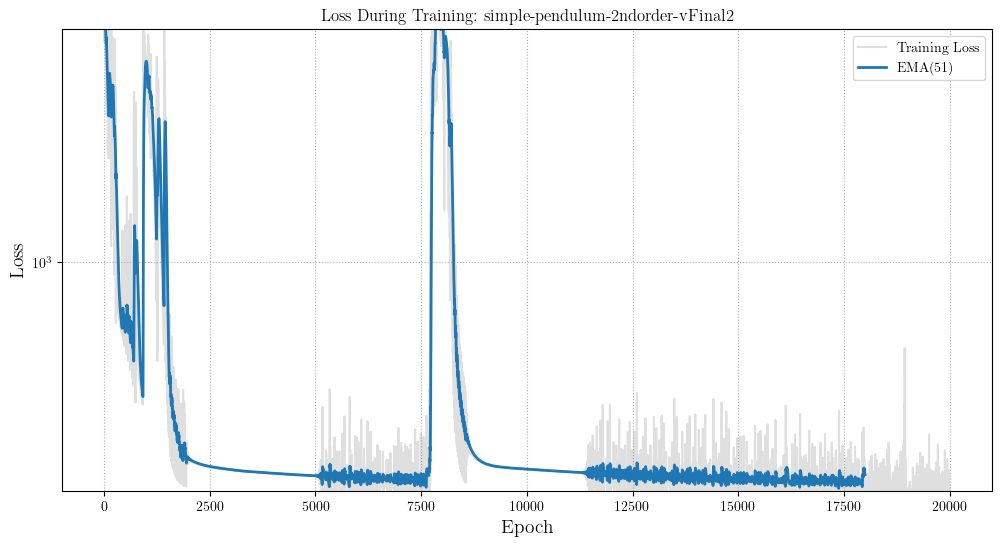

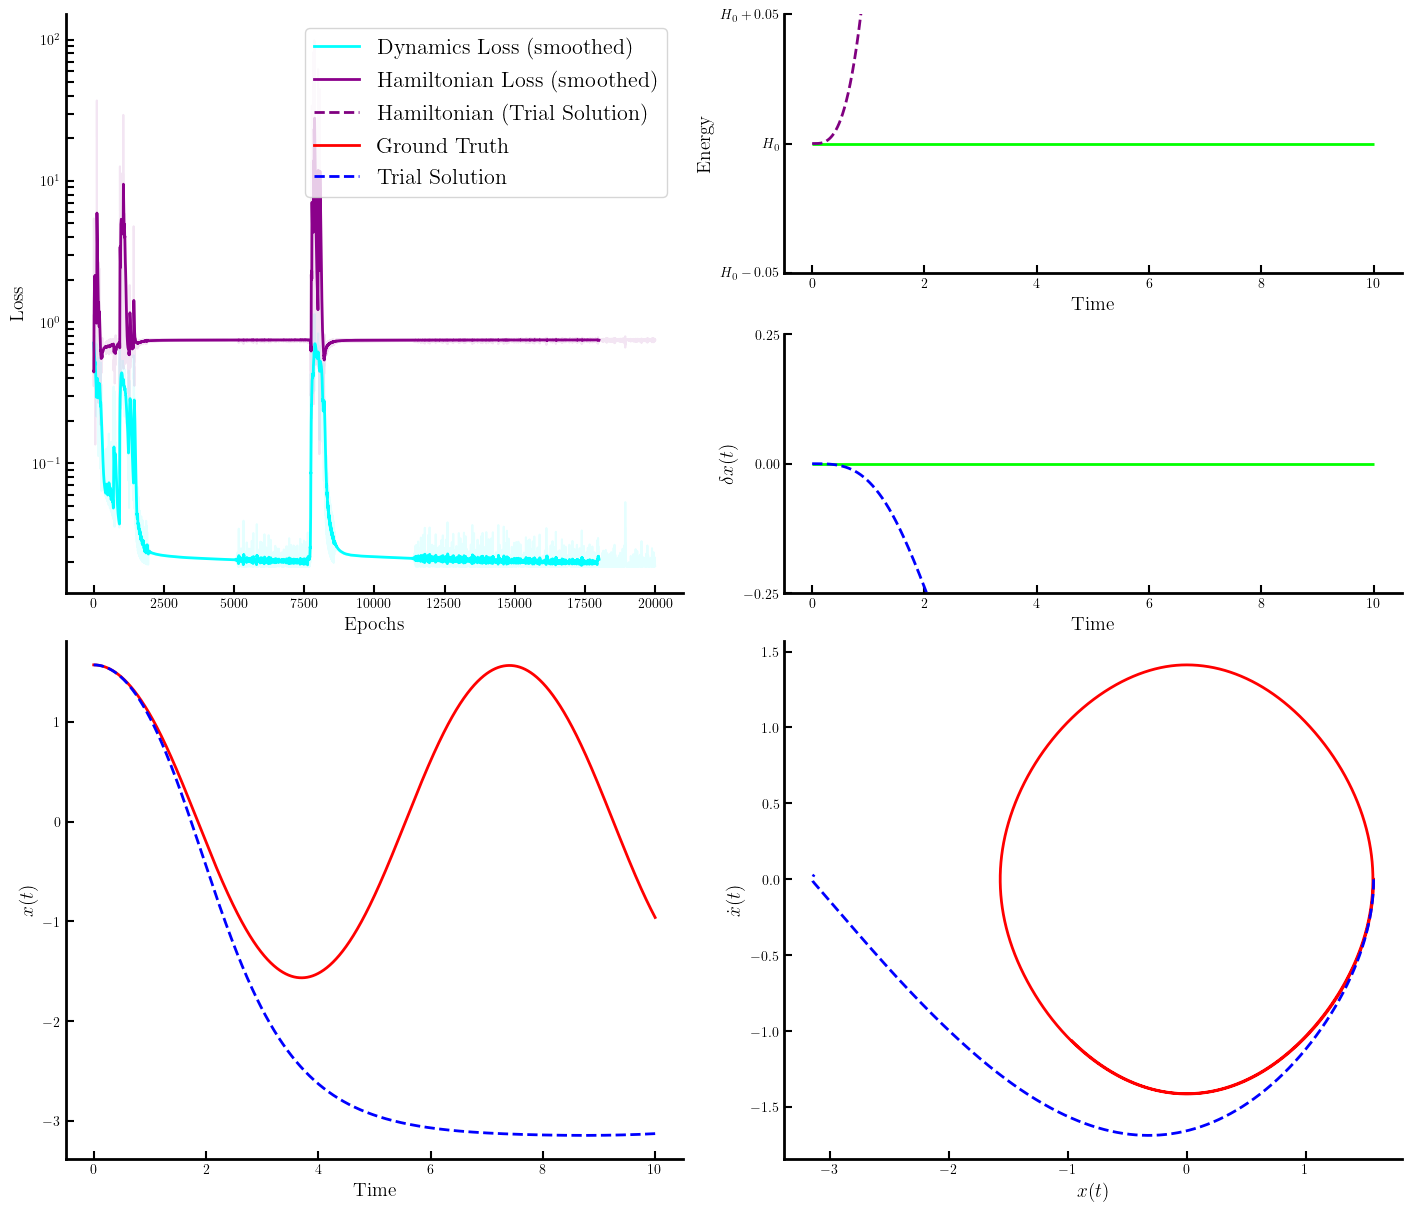

  0%|                                         | 1/20000 [00:00<35:52,  9.29it/s]

4492.818730401887


  1%|▏                                      | 102/20000 [00:09<31:14, 10.62it/s]

0.2434590232675193


  1%|▍                                      | 201/20000 [00:19<31:07, 10.60it/s]

0.019197419164005216


  2%|▌                                      | 302/20000 [00:28<30:48, 10.66it/s]

0.006382266490766081


  2%|▊                                      | 402/20000 [00:38<30:28, 10.72it/s]

0.003090738749847078


  3%|▉                                      | 502/20000 [00:47<30:03, 10.81it/s]

0.002168554633020058


  3%|█▏                                     | 602/20000 [00:57<29:46, 10.86it/s]

0.001667676258381125


  4%|█▎                                     | 702/20000 [01:06<29:51, 10.77it/s]

0.0012739846061167468


  4%|█▌                                     | 802/20000 [01:15<29:36, 10.81it/s]

0.0009557533570979562


  5%|█▊                                     | 902/20000 [01:25<29:59, 10.62it/s]

0.0007070622050670888


  5%|█▉                                    | 1002/20000 [01:34<29:06, 10.88it/s]

0.0005199737444233818


  6%|██                                    | 1102/20000 [01:44<29:40, 10.61it/s]

0.000384399053634207


  6%|██▎                                   | 1202/20000 [01:53<29:54, 10.47it/s]

0.000289696084931238


  7%|██▍                                   | 1302/20000 [02:03<29:32, 10.55it/s]

0.00022587540510896786


  7%|██▋                                   | 1401/20000 [02:12<31:52,  9.72it/s]

0.00018432241212590383


  8%|██▊                                   | 1501/20000 [02:22<29:24, 10.48it/s]

0.00015810621221931805


  8%|███                                   | 1601/20000 [02:31<28:28, 10.77it/s]

0.00014198149374672217


  9%|███▏                                  | 1701/20000 [02:41<29:04, 10.49it/s]

0.00013219695866415284


  9%|███▍                                  | 1801/20000 [02:50<28:31, 10.63it/s]

0.00012621089774191268


 10%|███▌                                  | 1902/20000 [03:02<32:31,  9.27it/s]

0.00012238973334381925


 10%|███▊                                  | 2002/20000 [03:12<28:50, 10.40it/s]

0.00011973726051871682


 11%|███▉                                  | 2101/20000 [03:22<29:04, 10.26it/s]

0.00011767733356324707


 11%|████▏                                 | 2201/20000 [03:32<29:11, 10.16it/s]

0.0017018872721630742


 12%|████▎                                 | 2301/20000 [03:42<28:56, 10.19it/s]

0.0015334103443119535


 12%|████▌                                 | 2402/20000 [03:52<29:03, 10.09it/s]

0.00022673945919216915


 13%|████▊                                 | 2502/20000 [04:02<30:16,  9.63it/s]

0.00014592018149001877


 13%|████▉                                 | 2602/20000 [04:12<29:43,  9.76it/s]

0.0001084676014100286


 14%|█████▏                                | 2702/20000 [04:22<29:29,  9.78it/s]

9.069662267070154e-05


 14%|█████▎                                | 2802/20000 [04:33<29:25,  9.74it/s]

8.145041219425489e-05


 15%|█████▌                                | 2902/20000 [04:43<28:50,  9.88it/s]

7.571993993533014e-05


 15%|█████▋                                | 3001/20000 [04:53<28:02, 10.10it/s]

7.138992851367772e-05


 16%|█████▉                                | 3101/20000 [05:02<27:43, 10.16it/s]

6.762489201321472e-05


 16%|██████                                | 3201/20000 [05:12<29:05,  9.62it/s]

6.411981808685684e-05


 17%|██████▎                               | 3302/20000 [05:22<27:42, 10.05it/s]

0.013492940815890793


 17%|██████▍                               | 3402/20000 [05:33<29:39,  9.33it/s]

0.000966663400426102


 18%|██████▋                               | 3502/20000 [05:44<29:58,  9.17it/s]

4.653844339888491e-05


 18%|██████▊                               | 3602/20000 [05:54<28:34,  9.56it/s]

1.965363654230058e-05


 19%|███████                               | 3702/20000 [06:05<28:59,  9.37it/s]

1.2195251472580689e-05


 19%|███████▏                              | 3802/20000 [06:16<28:35,  9.44it/s]

1.0092636645141576e-05


 20%|███████▍                              | 3902/20000 [06:26<29:30,  9.09it/s]

9.361686882049415e-06


 20%|███████▌                              | 4002/20000 [06:37<28:00,  9.52it/s]

8.960908120864947e-06


 21%|███████▊                              | 4102/20000 [06:47<28:50,  9.18it/s]

8.640579527497251e-06


 21%|███████▉                              | 4202/20000 [06:58<28:42,  9.17it/s]

8.58456447552037e-06


 22%|████████▏                             | 4302/20000 [07:09<28:36,  9.15it/s]

0.005376969246810672


 22%|████████▎                             | 4402/20000 [07:20<27:49,  9.34it/s]

8.592193715325009e-06


 23%|████████▌                             | 4502/20000 [07:30<27:53,  9.26it/s]

4.525861347160291e-06


 23%|████████▋                             | 4602/20000 [07:41<27:23,  9.37it/s]

3.71541438068998e-06


 24%|████████▉                             | 4702/20000 [07:52<27:55,  9.13it/s]

3.4310293262126516e-06


 24%|█████████                             | 4802/20000 [08:03<27:14,  9.30it/s]

3.2337773911043215e-06


 25%|█████████▎                            | 4902/20000 [08:13<27:16,  9.23it/s]

3.059198959300306e-06


 25%|█████████▌                            | 5002/20000 [08:24<27:58,  8.93it/s]

2.8986226212620926e-06


 26%|█████████▋                            | 5102/20000 [08:35<26:21,  9.42it/s]

6.0058223628023555


 26%|█████████▉                            | 5202/20000 [08:46<26:47,  9.20it/s]

0.000553394024934268


 27%|██████████                            | 5302/20000 [08:56<26:07,  9.37it/s]

2.1980904234893333e-06


 27%|██████████▎                           | 5402/20000 [09:07<26:46,  9.09it/s]

1.477696197129046e-06


 28%|██████████▍                           | 5502/20000 [09:18<26:18,  9.18it/s]

1.2982527826871042e-06


 28%|██████████▋                           | 5602/20000 [09:29<25:09,  9.54it/s]

1.1721606269281527e-06


 29%|██████████▊                           | 5702/20000 [09:39<25:39,  9.29it/s]

1.0629137695125912e-06


 29%|███████████                           | 5802/20000 [09:50<25:34,  9.25it/s]

9.672057636457386e-07


 30%|███████████▏                          | 5902/20000 [10:01<29:46,  7.89it/s]

8.837530469396359e-07


 30%|███████████▍                          | 6002/20000 [10:12<24:46,  9.41it/s]

4376.64167252962


 31%|███████████▌                          | 6102/20000 [10:23<25:28,  9.09it/s]

787.3574260579861


 31%|███████████▊                          | 6202/20000 [10:34<25:36,  8.98it/s]

762.6222729536848


 32%|███████████▉                          | 6302/20000 [10:45<25:34,  8.93it/s]

53.54051320976225


 32%|████████████▏                         | 6401/20000 [10:56<25:11,  9.00it/s]

36.452241248998945


 33%|████████████▎                         | 6502/20000 [11:07<24:12,  9.29it/s]

27.073437649099326


 33%|████████████▌                         | 6602/20000 [11:18<24:10,  9.24it/s]

21.59767336211312


 34%|████████████▋                         | 6702/20000 [11:29<24:01,  9.22it/s]

17.880208481761194


 34%|████████████▉                         | 6802/20000 [11:40<23:14,  9.46it/s]

14.954678229622822


 35%|█████████████                         | 6902/20000 [11:51<23:21,  9.35it/s]

12.503485435929239


 35%|█████████████▎                        | 7002/20000 [12:02<23:52,  9.08it/s]

11.517718323883498


 36%|█████████████▍                        | 7102/20000 [12:13<24:30,  8.77it/s]

9.540763493395309


 36%|█████████████▋                        | 7201/20000 [12:23<25:59,  8.21it/s]

8.586749048503533


 37%|█████████████▊                        | 7302/20000 [12:34<23:25,  9.04it/s]

7.839184646148764


 37%|██████████████                        | 7402/20000 [12:45<23:58,  8.76it/s]

12.12719786669662


 38%|██████████████▎                       | 7502/20000 [12:56<23:14,  8.96it/s]

6.69742932006594


 38%|██████████████▍                       | 7602/20000 [13:07<22:27,  9.20it/s]

15.386755904559466


 39%|██████████████▋                       | 7702/20000 [13:19<23:03,  8.89it/s]

5.459283318194686


 39%|██████████████▊                       | 7802/20000 [13:30<22:28,  9.05it/s]

5.213768206263892


 40%|███████████████                       | 7902/20000 [13:41<22:09,  9.10it/s]

4.646837862463189


 40%|███████████████▏                      | 8002/20000 [13:51<22:11,  9.01it/s]

10.568346852598836


 41%|███████████████▍                      | 8102/20000 [14:02<21:37,  9.17it/s]

4.634174276429345


 41%|███████████████▌                      | 8202/20000 [14:13<22:20,  8.80it/s]

7.609772507323409


 42%|███████████████▊                      | 8302/20000 [14:25<22:16,  8.75it/s]

3.374408365450007


 42%|███████████████▉                      | 8402/20000 [14:36<21:30,  8.99it/s]

3.2984978930893085


 43%|████████████████▏                     | 8502/20000 [14:47<21:07,  9.07it/s]

4.328402096886796


 43%|████████████████▎                     | 8602/20000 [14:58<20:40,  9.19it/s]

2.830715224259036


 44%|████████████████▌                     | 8702/20000 [15:09<20:24,  9.23it/s]

4.632298091345678


 44%|████████████████▋                     | 8802/20000 [15:20<20:18,  9.19it/s]

2.5581009122904073


 45%|████████████████▉                     | 8902/20000 [15:31<20:41,  8.94it/s]

18.01552733972724


 45%|█████████████████                     | 9002/20000 [15:42<19:52,  9.22it/s]

2.373182196000827


 46%|█████████████████▎                    | 9102/20000 [15:53<19:52,  9.14it/s]

2.1707018899982495


 46%|█████████████████▍                    | 9202/20000 [16:04<19:33,  9.20it/s]

2.503580458428463


 47%|█████████████████▋                    | 9302/20000 [16:15<19:05,  9.34it/s]

2.0513453121203424


 47%|█████████████████▊                    | 9402/20000 [16:26<18:56,  9.33it/s]

1.8873482038232106


 48%|██████████████████                    | 9502/20000 [16:37<19:13,  9.10it/s]

3.1179368240211076


 48%|██████████████████▏                   | 9602/20000 [16:48<19:40,  8.81it/s]

1.8542072506060334


 49%|██████████████████▍                   | 9702/20000 [16:59<18:35,  9.23it/s]

1.6924399521066578


 49%|██████████████████▌                   | 9802/20000 [17:10<18:45,  9.06it/s]

1.5701629039184235


 50%|██████████████████▊                   | 9902/20000 [17:21<17:59,  9.35it/s]

2.9927901825516163


 50%|██████████████████▌                  | 10002/20000 [17:32<18:34,  8.97it/s]

1.5921742843746762


 51%|██████████████████▋                  | 10102/20000 [17:43<17:53,  9.22it/s]

1.4438181408980297


 51%|██████████████████▊                  | 10202/20000 [17:54<17:36,  9.27it/s]

1.337237216904948


 52%|███████████████████                  | 10302/20000 [18:05<17:42,  9.12it/s]

1.2537073106553462


 52%|███████████████████▏                 | 10402/20000 [18:16<17:42,  9.03it/s]

1.5656231441279598


 53%|███████████████████▍                 | 10502/20000 [18:27<17:12,  9.20it/s]

1.3208117691024404


 53%|███████████████████▌                 | 10602/20000 [18:38<16:22,  9.57it/s]

1.1859314690914586


 54%|███████████████████▊                 | 10702/20000 [18:49<17:11,  9.02it/s]

1.0960921861978012


 54%|███████████████████▉                 | 10802/20000 [19:00<16:25,  9.33it/s]

1.0280923047320782


 55%|████████████████████▏                | 10902/20000 [19:11<16:26,  9.23it/s]

0.9701734672651553


 55%|████████████████████▎                | 11002/20000 [19:22<16:14,  9.23it/s]

1.3714835180279201


 56%|████████████████████▌                | 11102/20000 [19:33<16:06,  9.21it/s]

1.082204055832944


 56%|████████████████████▋                | 11202/20000 [19:43<15:38,  9.37it/s]

0.9476802569529239


 57%|████████████████████▉                | 11302/20000 [19:54<15:53,  9.13it/s]

0.8696206343445433


 57%|█████████████████████                | 11402/20000 [20:05<15:28,  9.26it/s]

0.8146600778216095


 58%|█████████████████████▎               | 11502/20000 [20:16<15:50,  8.94it/s]

0.7687375800953037


 58%|█████████████████████▍               | 11602/20000 [20:27<15:05,  9.28it/s]

0.7270527233821742


 59%|█████████████████████▋               | 11702/20000 [20:38<15:02,  9.19it/s]

1.2733898284431264


 59%|█████████████████████▊               | 11802/20000 [20:49<14:38,  9.33it/s]

0.8725359266497376


 60%|██████████████████████               | 11902/20000 [21:00<14:38,  9.22it/s]

0.7327764982575422


 60%|██████████████████████▏              | 12002/20000 [21:11<14:37,  9.12it/s]

0.665305614059815


 61%|██████████████████████▍              | 12102/20000 [21:22<14:19,  9.19it/s]

0.6217089236870865


 61%|██████████████████████▌              | 12202/20000 [21:33<14:22,  9.04it/s]

0.5858028912331479


 62%|██████████████████████▊              | 12302/20000 [21:44<13:49,  9.28it/s]

0.5533946472831033


 62%|██████████████████████▉              | 12402/20000 [21:55<13:38,  9.28it/s]

0.5235000077580044


 63%|███████████████████████▏             | 12502/20000 [22:06<13:33,  9.22it/s]

0.8980832178677642


 63%|███████████████████████▎             | 12602/20000 [22:17<13:45,  8.97it/s]

0.6964028966904368


 64%|███████████████████████▍             | 12702/20000 [22:28<13:03,  9.32it/s]

0.6012957493174376


 64%|███████████████████████▋             | 12802/20000 [22:39<12:52,  9.32it/s]

0.5474944331579229


 65%|███████████████████████▊             | 12902/20000 [22:50<13:11,  8.96it/s]

0.5153764726384449


 65%|████████████████████████             | 13002/20000 [23:01<12:30,  9.32it/s]

0.49208904605148607


 66%|████████████████████████▏            | 13102/20000 [23:12<12:41,  9.06it/s]

0.47176554662264036


 66%|████████████████████████▍            | 13202/20000 [23:23<12:25,  9.12it/s]

0.45239743494248796


 67%|████████████████████████▌            | 13302/20000 [23:34<12:14,  9.12it/s]

0.4334414877297798


 67%|████████████████████████▊            | 13402/20000 [23:45<12:00,  9.16it/s]

0.4147844960233269


 68%|████████████████████████▉            | 13501/20000 [23:56<17:58,  6.02it/s]

52.10005045231693


 68%|█████████████████████████▏           | 13602/20000 [24:08<11:28,  9.29it/s]

0.4866752496157094


 69%|█████████████████████████▎           | 13702/20000 [24:19<11:26,  9.17it/s]

0.4116853483415269


 69%|█████████████████████████▌           | 13802/20000 [24:29<10:51,  9.51it/s]

0.37989429704636063


 70%|█████████████████████████▋           | 13902/20000 [24:40<11:07,  9.14it/s]

0.3600102130413072


 70%|█████████████████████████▉           | 14002/20000 [24:51<10:59,  9.10it/s]

0.34276705226356285


 71%|██████████████████████████           | 14102/20000 [25:02<11:39,  8.43it/s]

0.326253350165609


 71%|██████████████████████████▎          | 14202/20000 [25:13<10:53,  8.87it/s]

0.3101454817237007


 72%|██████████████████████████▍          | 14302/20000 [25:24<10:39,  8.91it/s]

0.29492412742352886


 72%|██████████████████████████▋          | 14402/20000 [25:35<10:12,  9.15it/s]

0.35406107065380277


 73%|██████████████████████████▊          | 14502/20000 [25:46<10:24,  8.80it/s]

0.30468756698446403


 73%|███████████████████████████          | 14602/20000 [25:57<09:38,  9.33it/s]

0.28333867982999467


 74%|███████████████████████████▏         | 14702/20000 [26:08<09:28,  9.32it/s]

0.26691835165133937


 74%|███████████████████████████▍         | 14802/20000 [26:18<09:17,  9.33it/s]

0.25128050778842564


 75%|███████████████████████████▌         | 14902/20000 [26:29<09:12,  9.23it/s]

0.23582869429956244


 75%|███████████████████████████▊         | 15002/20000 [26:40<08:55,  9.34it/s]

0.22037639337237658


 76%|███████████████████████████▉         | 15102/20000 [26:51<08:51,  9.22it/s]

18.28065324527359


 76%|████████████████████████████         | 15202/20000 [27:02<08:33,  9.35it/s]

0.24009446592218667


 77%|████████████████████████████▎        | 15301/20000 [27:12<09:31,  8.22it/s]

0.2153131264841252


 77%|████████████████████████████▍        | 15402/20000 [27:24<08:53,  8.61it/s]

0.1990645417459569


 78%|████████████████████████████▋        | 15502/20000 [27:35<07:40,  9.78it/s]

0.1835916191369646


 78%|████████████████████████████▊        | 15602/20000 [27:45<07:47,  9.40it/s]

0.1682073726004691


 79%|█████████████████████████████        | 15702/20000 [27:56<07:31,  9.52it/s]

0.15279538505579462


 79%|█████████████████████████████▏       | 15802/20000 [28:06<07:11,  9.72it/s]

31.517910056256245


 80%|█████████████████████████████▍       | 15902/20000 [28:17<07:12,  9.48it/s]

0.16716526146621458


 80%|█████████████████████████████▌       | 16002/20000 [28:28<07:08,  9.34it/s]

0.14804500598286668


 81%|█████████████████████████████▊       | 16102/20000 [28:39<06:53,  9.43it/s]

0.13270645852443266


 81%|█████████████████████████████▉       | 16202/20000 [28:49<06:43,  9.42it/s]

0.11801046512823647


 82%|██████████████████████████████▏      | 16302/20000 [29:00<06:33,  9.39it/s]

0.1041448382749983


 82%|██████████████████████████████▎      | 16402/20000 [29:11<06:18,  9.51it/s]

0.09152154987035424


 83%|██████████████████████████████▌      | 16502/20000 [29:21<06:12,  9.39it/s]

0.1487836487372224


 83%|██████████████████████████████▋      | 16601/20000 [29:32<06:00,  9.43it/s]

0.122753761689717


 84%|██████████████████████████████▉      | 16702/20000 [29:43<06:05,  9.03it/s]

0.10773078363609605


 84%|███████████████████████████████      | 16802/20000 [29:54<05:44,  9.27it/s]

0.0938888884914366


 85%|███████████████████████████████▎     | 16902/20000 [30:04<05:27,  9.45it/s]

0.0815506019842745


 85%|███████████████████████████████▍     | 17002/20000 [30:15<05:14,  9.53it/s]

0.07105894000523934


 86%|███████████████████████████████▋     | 17102/20000 [30:26<05:10,  9.34it/s]

0.062477567808120096


 86%|███████████████████████████████▊     | 17202/20000 [30:37<05:02,  9.26it/s]

0.09810976584918596


 87%|████████████████████████████████     | 17302/20000 [30:48<04:54,  9.15it/s]

0.08062252562948244


 87%|████████████████████████████████▏    | 17402/20000 [30:58<04:33,  9.51it/s]

0.06883670705586853


 88%|████████████████████████████████▍    | 17502/20000 [31:09<04:25,  9.42it/s]

0.05942080593707237


 88%|████████████████████████████████▌    | 17602/20000 [31:20<04:21,  9.17it/s]

0.05207098614148902


 89%|████████████████████████████████▋    | 17702/20000 [31:31<04:15,  9.01it/s]

0.046294930829998734


 89%|████████████████████████████████▉    | 17802/20000 [31:42<03:43,  9.83it/s]

19.19060811422075


 90%|█████████████████████████████████    | 17902/20000 [31:53<03:43,  9.37it/s]

0.06702548441086542


 90%|█████████████████████████████████▎   | 18002/20000 [32:03<03:32,  9.42it/s]

0.04898015991358221


 91%|█████████████████████████████████▍   | 18102/20000 [32:14<03:25,  9.25it/s]

0.03800988835859654


 91%|█████████████████████████████████▋   | 18202/20000 [32:25<03:07,  9.61it/s]

0.03118664365315561


 92%|█████████████████████████████████▊   | 18302/20000 [32:36<03:02,  9.32it/s]

4.491008201878573


 92%|██████████████████████████████████   | 18402/20000 [32:46<02:46,  9.58it/s]

0.0057306697583894


 93%|██████████████████████████████████▏  | 18502/20000 [32:57<02:44,  9.13it/s]

0.003001268545480209


 93%|██████████████████████████████████▍  | 18602/20000 [33:08<02:29,  9.38it/s]

0.0017913076791006444


 94%|██████████████████████████████████▌  | 18702/20000 [33:19<02:16,  9.51it/s]

0.0011807447979161143


 94%|██████████████████████████████████▊  | 18802/20000 [33:29<02:10,  9.16it/s]

0.0008514658322971543


 95%|██████████████████████████████████▉  | 18902/20000 [33:41<01:58,  9.30it/s]

0.0006583329759747925


 95%|███████████████████████████████████▏ | 19002/20000 [33:51<01:47,  9.31it/s]

0.000533544691688296


 96%|███████████████████████████████████▎ | 19102/20000 [34:02<01:34,  9.54it/s]

0.0004452155870749065


 96%|███████████████████████████████████▌ | 19202/20000 [34:13<01:32,  8.66it/s]

0.018819357430872048


 97%|███████████████████████████████████▋ | 19302/20000 [34:23<01:11,  9.81it/s]

0.0018477165666012242


 97%|███████████████████████████████████▉ | 19402/20000 [34:34<01:03,  9.37it/s]

0.000990645600296843


 98%|████████████████████████████████████ | 19502/20000 [34:45<00:53,  9.31it/s]

0.0006161108681616797


 98%|████████████████████████████████████▎| 19602/20000 [34:55<00:41,  9.65it/s]

0.00043629767987530686


 99%|████████████████████████████████████▍| 19702/20000 [35:06<00:32,  9.26it/s]

0.0003384687334553742


 99%|████████████████████████████████████▋| 19802/20000 [35:16<00:21,  9.13it/s]

0.0002771267336779848


100%|████████████████████████████████████▊| 19902/20000 [35:28<00:10,  9.42it/s]

0.0012351799467655929


100%|█████████████████████████████████████| 20000/20000 [35:38<00:00,  9.35it/s]


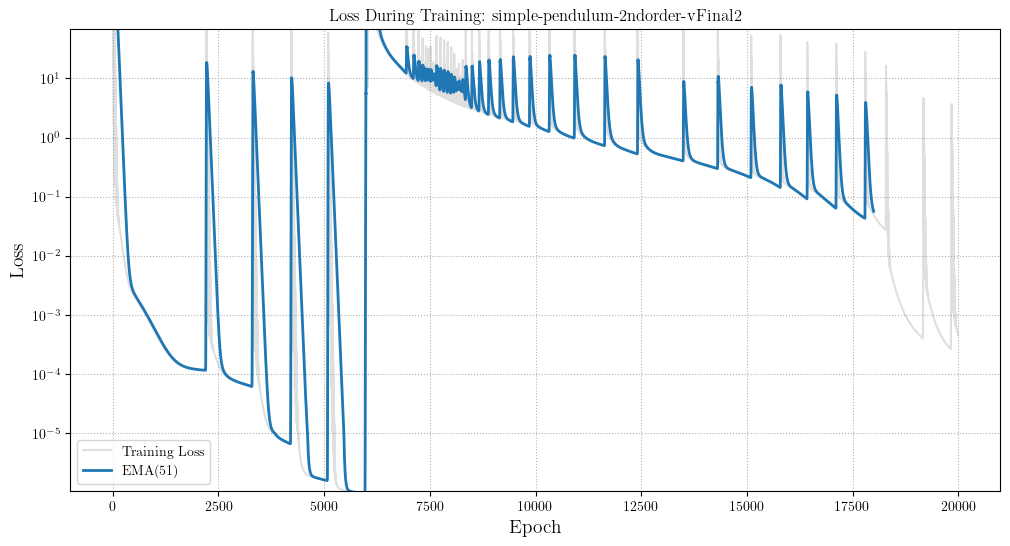

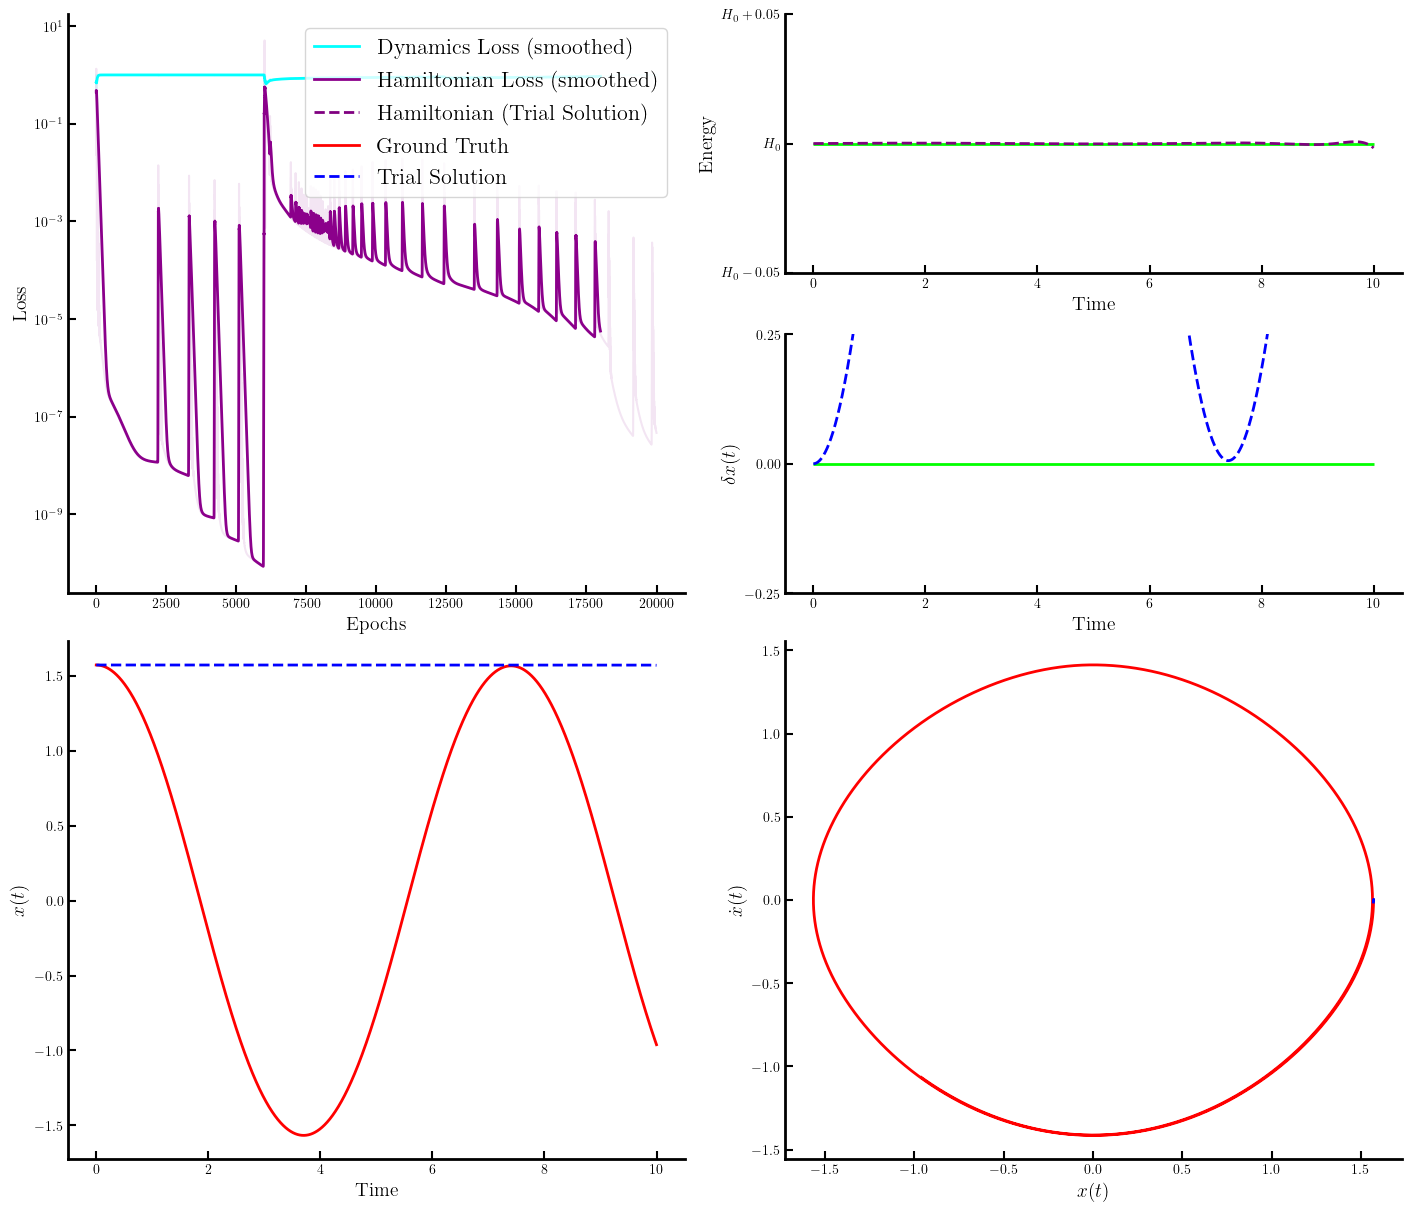

  0%|                                         | 2/20000 [00:00<36:28,  9.14it/s]

11589.741929947962


  1%|▏                                      | 102/20000 [00:10<35:49,  9.26it/s]

3978.929313986735


  1%|▍                                      | 202/20000 [00:21<35:21,  9.33it/s]

3687.915940491899


  2%|▌                                      | 302/20000 [00:32<34:41,  9.46it/s]

4354.17876699496


  2%|▊                                      | 402/20000 [00:43<35:54,  9.10it/s]

3598.8765573923642


  3%|▉                                      | 502/20000 [00:54<34:38,  9.38it/s]

4654.815711839219


  3%|█▏                                     | 602/20000 [01:05<36:19,  8.90it/s]

3262.097974599484


  4%|█▎                                     | 702/20000 [01:16<36:05,  8.91it/s]

3466.723698493284


  4%|█▌                                     | 802/20000 [01:26<35:25,  9.03it/s]

3302.598823331723


  5%|█▊                                     | 902/20000 [01:38<34:15,  9.29it/s]

3068.5366644063815


  5%|█▉                                    | 1002/20000 [01:49<33:50,  9.36it/s]

3240.74849219307


  6%|██                                    | 1102/20000 [02:00<34:25,  9.15it/s]

3183.498276055444


  6%|██▎                                   | 1202/20000 [02:11<35:21,  8.86it/s]

9538.077419977155


  7%|██▍                                   | 1302/20000 [02:22<33:11,  9.39it/s]

3238.3659853006543


  7%|██▋                                   | 1402/20000 [02:33<35:30,  8.73it/s]

3214.381337118406


  8%|██▊                                   | 1502/20000 [02:44<36:05,  8.54it/s]

3199.5070180101034


  8%|███                                   | 1602/20000 [02:55<33:48,  9.07it/s]

3180.8680182266653


  9%|███▏                                  | 1702/20000 [03:06<33:10,  9.19it/s]

3150.400966876666


  9%|███▍                                  | 1802/20000 [03:17<33:39,  9.01it/s]

3237.6193332268167


 10%|███▌                                  | 1902/20000 [03:28<33:33,  8.99it/s]

3093.270341565476


 10%|███▊                                  | 2002/20000 [03:39<32:42,  9.17it/s]

3722.2792825013316


 11%|███▉                                  | 2102/20000 [03:51<32:45,  9.11it/s]

1939.3822133079498


 11%|████▏                                 | 2202/20000 [04:01<31:53,  9.30it/s]

361.34080892914227


 12%|████▎                                 | 2302/20000 [04:13<33:24,  8.83it/s]

217.09316164359313


 12%|████▌                                 | 2402/20000 [04:23<32:17,  9.08it/s]

329.2588575960199


 13%|████▊                                 | 2502/20000 [04:35<31:59,  9.12it/s]

316.85249442051656


 13%|████▉                                 | 2602/20000 [04:46<31:59,  9.06it/s]

171.6237373685839


 14%|█████▏                                | 2702/20000 [04:57<32:11,  8.96it/s]

189.54238554161674


 14%|█████▎                                | 2801/20000 [05:08<36:12,  7.92it/s]

185.8886726774889


 15%|█████▌                                | 2902/20000 [05:19<30:12,  9.43it/s]

207.98780409489956


 15%|█████▋                                | 3002/20000 [05:30<30:54,  9.17it/s]

171.1428199633611


 16%|█████▉                                | 3102/20000 [05:41<30:25,  9.25it/s]

232.5927978726965


 16%|██████                                | 3202/20000 [05:52<31:28,  8.90it/s]

189.5667634351678


 17%|██████▎                               | 3302/20000 [06:03<30:15,  9.20it/s]

182.41687856741743


 17%|██████▍                               | 3402/20000 [06:14<30:45,  8.99it/s]

253.40245019624805


 18%|██████▋                               | 3502/20000 [06:25<30:42,  8.96it/s]

268.75671115668945


 18%|██████▊                               | 3602/20000 [06:36<29:47,  9.18it/s]

167.18941933898003


 19%|███████                               | 3702/20000 [06:47<29:41,  9.15it/s]

170.94988921092664


 19%|███████▏                              | 3802/20000 [06:58<29:29,  9.15it/s]

166.79505986505234


 20%|███████▍                              | 3902/20000 [07:09<28:31,  9.40it/s]

230.92131425426754


 20%|███████▌                              | 4002/20000 [07:20<28:10,  9.46it/s]

239.55664843130515


 21%|███████▊                              | 4102/20000 [07:31<27:29,  9.64it/s]

166.5106870728087


 21%|███████▉                              | 4202/20000 [07:42<28:18,  9.30it/s]

220.892101736708


 22%|████████▏                             | 4302/20000 [07:53<28:50,  9.07it/s]

183.66519454193906


 22%|████████▎                             | 4402/20000 [08:04<27:40,  9.39it/s]

168.24823111235736


 23%|████████▌                             | 4502/20000 [08:15<27:41,  9.33it/s]

170.15233717575745


 23%|████████▋                             | 4602/20000 [08:26<27:12,  9.43it/s]

164.3791177970431


 24%|████████▉                             | 4702/20000 [08:37<27:39,  9.22it/s]

163.73460078133613


 24%|█████████                             | 4802/20000 [08:48<28:14,  8.97it/s]

163.77499129427395


 25%|█████████▎                            | 4902/20000 [08:59<26:57,  9.33it/s]

163.06487724471762


 25%|█████████▌                            | 5002/20000 [09:10<27:24,  9.12it/s]

169.66476687893083


 26%|█████████▋                            | 5102/20000 [09:21<27:03,  9.18it/s]

168.2347033423532


 26%|█████████▉                            | 5202/20000 [09:32<27:04,  9.11it/s]

165.85336651888713


 27%|██████████                            | 5302/20000 [09:43<26:55,  9.10it/s]

161.70388384571845


 27%|██████████▎                           | 5402/20000 [09:54<26:14,  9.27it/s]

163.8104398534186


 28%|██████████▍                           | 5502/20000 [10:05<25:58,  9.30it/s]

170.86884209922076


 28%|██████████▋                           | 5602/20000 [10:16<26:34,  9.03it/s]

187.19448228388538


 29%|██████████▊                           | 5702/20000 [10:27<26:44,  8.91it/s]

172.31940331972638


 29%|███████████                           | 5802/20000 [10:38<25:35,  9.25it/s]

158.896022202697


 30%|███████████▏                          | 5902/20000 [10:49<25:14,  9.31it/s]

159.00652079356297


 30%|███████████▍                          | 6002/20000 [11:00<26:03,  8.95it/s]

165.20231582797476


 31%|███████████▌                          | 6102/20000 [11:11<24:57,  9.28it/s]

160.3234930331752


 31%|███████████▊                          | 6202/20000 [11:22<25:16,  9.10it/s]

189.4349439957324


 32%|███████████▉                          | 6302/20000 [11:33<27:19,  8.36it/s]

191.21778960333376


 32%|████████████▏                         | 6402/20000 [11:44<26:58,  8.40it/s]

155.15715510467754


 33%|████████████▎                         | 6502/20000 [11:55<24:31,  9.17it/s]

150.4072518455608


 33%|████████████▌                         | 6602/20000 [12:06<23:50,  9.36it/s]

207.49044232660742


 34%|████████████▋                         | 6702/20000 [12:17<23:56,  9.25it/s]

161.84077532801655


 34%|████████████▉                         | 6802/20000 [12:28<23:20,  9.43it/s]

172.10630668448837


 35%|█████████████                         | 6902/20000 [12:39<23:34,  9.26it/s]

350.53018641344147


 35%|█████████████▎                        | 7002/20000 [12:50<23:30,  9.22it/s]

2698.9926973221295


 36%|█████████████▍                        | 7102/20000 [13:01<23:23,  9.19it/s]

131.5017960004497


 36%|█████████████▋                        | 7202/20000 [13:12<23:45,  8.98it/s]

169.3129826506467


 37%|█████████████▊                        | 7302/20000 [13:24<22:57,  9.22it/s]

664.6083528242572


 37%|██████████████                        | 7402/20000 [13:35<23:07,  9.08it/s]

85.15174519822989


 38%|██████████████▎                       | 7502/20000 [13:46<22:45,  9.15it/s]

10.387864676574981


 38%|██████████████▍                       | 7602/20000 [13:57<22:18,  9.26it/s]

5.058331131833842


 39%|██████████████▋                       | 7701/20000 [14:08<24:22,  8.41it/s]

68.18319584979389


 39%|██████████████▊                       | 7802/20000 [14:19<21:39,  9.39it/s]

11.57112124400783


 40%|███████████████                       | 7902/20000 [14:29<21:56,  9.19it/s]

3.218168483908184


 40%|███████████████▏                      | 8002/20000 [14:41<22:05,  9.05it/s]

11.751008238697832


 41%|███████████████▍                      | 8102/20000 [14:51<21:28,  9.23it/s]

4.224579639554626


 41%|███████████████▌                      | 8202/20000 [15:02<21:39,  9.08it/s]

16.071818388701047


 42%|███████████████▊                      | 8302/20000 [15:14<21:16,  9.16it/s]

142.58871128492956


 42%|███████████████▉                      | 8402/20000 [15:25<21:20,  9.06it/s]

52.793421432439935


 43%|████████████████▏                     | 8502/20000 [15:36<21:15,  9.01it/s]

8.71853645094685


 43%|████████████████▎                     | 8602/20000 [15:47<21:01,  9.04it/s]

12.718114566645038


 44%|████████████████▌                     | 8702/20000 [15:58<20:29,  9.19it/s]

1.6763475089989102


 44%|████████████████▋                     | 8802/20000 [16:09<20:43,  9.01it/s]

3.6463434603922575


 45%|████████████████▉                     | 8902/20000 [16:20<19:56,  9.28it/s]

3.098833613167533


 45%|█████████████████                     | 9002/20000 [16:31<20:14,  9.06it/s]

1.5639743775940511


 46%|█████████████████▎                    | 9102/20000 [16:42<19:25,  9.35it/s]

31.237097917926782


 46%|█████████████████▍                    | 9202/20000 [16:53<19:16,  9.33it/s]

22.006034024768034


 47%|█████████████████▋                    | 9302/20000 [17:04<19:24,  9.19it/s]

7.736477666097064


 47%|█████████████████▊                    | 9402/20000 [17:15<20:29,  8.62it/s]

3.0331288319968026


 48%|██████████████████                    | 9502/20000 [17:26<18:44,  9.33it/s]

12.43579961019839


 48%|██████████████████▏                   | 9602/20000 [17:37<18:43,  9.25it/s]

84.80334810389377


 49%|██████████████████▍                   | 9702/20000 [17:48<18:36,  9.23it/s]

17.77409144101107


 49%|██████████████████▌                   | 9802/20000 [17:59<17:50,  9.53it/s]

56.681861908233344


 50%|██████████████████▊                   | 9902/20000 [18:10<18:56,  8.88it/s]

1916.9195751556822


 50%|██████████████████▌                  | 10002/20000 [18:21<17:11,  9.69it/s]

1.4033987833724102


 51%|██████████████████▋                  | 10102/20000 [18:31<17:36,  9.37it/s]

1.0013956619528253


 51%|██████████████████▊                  | 10202/20000 [18:42<17:30,  9.33it/s]

26.372724639363476


 52%|███████████████████                  | 10302/20000 [18:53<16:51,  9.59it/s]

18.62350633395021


 52%|███████████████████▏                 | 10402/20000 [19:05<17:49,  8.97it/s]

66.20967202289674


 53%|███████████████████▍                 | 10502/20000 [19:16<16:31,  9.58it/s]

10.94489111351001


 53%|███████████████████▌                 | 10602/20000 [19:26<16:18,  9.60it/s]

43.09592410563813


 54%|███████████████████▊                 | 10702/20000 [19:37<16:31,  9.38it/s]

4.201236765190058


 54%|███████████████████▉                 | 10802/20000 [19:48<16:32,  9.27it/s]

11.98982347012216


 55%|████████████████████▏                | 10902/20000 [19:59<16:17,  9.31it/s]

0.7193802689713213


 55%|████████████████████▎                | 11002/20000 [20:09<17:18,  8.66it/s]

0.9972616890704661


 56%|████████████████████▌                | 11102/20000 [20:21<15:44,  9.42it/s]

62.85586377082123


 56%|████████████████████▋                | 11202/20000 [20:32<15:42,  9.33it/s]

0.31319665584650047


 57%|████████████████████▉                | 11302/20000 [20:43<15:20,  9.45it/s]

0.4151059318951228


 57%|█████████████████████                | 11402/20000 [20:53<15:00,  9.55it/s]

0.36805503357150215


 58%|█████████████████████▎               | 11502/20000 [21:04<15:22,  9.21it/s]

0.2503341881065694


 58%|█████████████████████▍               | 11602/20000 [21:15<15:31,  9.02it/s]

42.43135771619281


 59%|█████████████████████▋               | 11702/20000 [21:26<15:25,  8.97it/s]

1.9722386569433004


 59%|█████████████████████▊               | 11802/20000 [21:37<15:26,  8.85it/s]

6.434854501309292


 60%|██████████████████████               | 11902/20000 [21:48<14:19,  9.42it/s]

6.488741024051923


 60%|██████████████████████▏              | 12002/20000 [21:59<14:37,  9.11it/s]

0.22379360681958066


 61%|██████████████████████▍              | 12102/20000 [22:10<14:24,  9.13it/s]

25.889620940401095


 61%|██████████████████████▌              | 12202/20000 [22:21<14:07,  9.20it/s]

49.28511340819885


 62%|██████████████████████▊              | 12302/20000 [22:32<17:00,  7.55it/s]

2.851601620786863


 62%|██████████████████████▉              | 12402/20000 [22:43<14:06,  8.98it/s]

2.4127627948978847


 63%|███████████████████████▏             | 12502/20000 [22:54<13:25,  9.31it/s]

1.4591524319561353


 63%|███████████████████████▎             | 12602/20000 [23:05<13:35,  9.07it/s]

35.304099167132925


 64%|███████████████████████▍             | 12702/20000 [23:16<13:24,  9.08it/s]

11.413699220898945


 64%|███████████████████████▋             | 12802/20000 [23:27<13:10,  9.10it/s]

3.3270668568163737


 65%|███████████████████████▊             | 12902/20000 [23:38<13:17,  8.90it/s]

15.033320612412059


 65%|████████████████████████             | 13002/20000 [23:49<12:51,  9.07it/s]

1.0539610574513405


 66%|████████████████████████▏            | 13102/20000 [24:00<12:35,  9.13it/s]

-0.04916042287284646


 66%|████████████████████████▍            | 13202/20000 [24:11<12:16,  9.23it/s]

22.9238600001887


 67%|████████████████████████▌            | 13302/20000 [24:22<12:06,  9.22it/s]

1.806362493804853


 67%|████████████████████████▊            | 13401/20000 [24:32<13:20,  8.24it/s]

2.679677188518787


 68%|████████████████████████▉            | 13502/20000 [24:44<12:51,  8.43it/s]

9.822750943962212


 68%|█████████████████████████▏           | 13602/20000 [24:55<11:21,  9.39it/s]

8.675154970032484


 69%|█████████████████████████▎           | 13702/20000 [25:06<11:33,  9.08it/s]

-0.053570606273395986


 69%|█████████████████████████▌           | 13802/20000 [25:17<11:38,  8.88it/s]

-0.03391493794881602


 70%|█████████████████████████▋           | 13902/20000 [25:28<11:04,  9.18it/s]

3.78436527895622


 70%|█████████████████████████▉           | 14002/20000 [25:39<10:59,  9.09it/s]

13.446687819668703


 71%|██████████████████████████           | 14102/20000 [25:50<10:40,  9.20it/s]

0.42726998274537736


 71%|██████████████████████████▎          | 14202/20000 [26:01<10:43,  9.00it/s]

5.974174340216413


 72%|██████████████████████████▍          | 14302/20000 [26:13<13:35,  6.99it/s]

0.2852824724210195


 72%|██████████████████████████▋          | 14402/20000 [26:24<10:05,  9.25it/s]

135.4957915625899


 73%|██████████████████████████▊          | 14502/20000 [26:35<09:54,  9.25it/s]

3.2505536914900794


 73%|███████████████████████████          | 14602/20000 [26:46<10:02,  8.96it/s]

-0.005985386291626227


 74%|███████████████████████████▏         | 14702/20000 [26:57<10:00,  8.82it/s]

-0.14583228271228338


 74%|███████████████████████████▍         | 14802/20000 [27:09<09:35,  9.03it/s]

-0.18244533141303332


 75%|███████████████████████████▌         | 14902/20000 [27:20<09:12,  9.23it/s]

-0.07033802611295308


 75%|███████████████████████████▊         | 15002/20000 [27:31<08:59,  9.26it/s]

-0.1863143049690306


 76%|███████████████████████████▉         | 15102/20000 [27:42<09:05,  8.97it/s]

-0.11894272406553297


 76%|████████████████████████████         | 15202/20000 [27:53<08:53,  9.00it/s]

0.9797009651635019


 77%|████████████████████████████▎        | 15302/20000 [28:04<08:31,  9.18it/s]

0.8786085439954334


 77%|████████████████████████████▍        | 15402/20000 [28:15<08:29,  9.03it/s]

8.43859225689312


 78%|████████████████████████████▋        | 15502/20000 [28:26<08:11,  9.14it/s]

3.495118740247337


 78%|████████████████████████████▊        | 15602/20000 [28:38<08:16,  8.86it/s]

-0.0019863221080436005


 79%|█████████████████████████████        | 15702/20000 [28:49<08:01,  8.92it/s]

0.957443145413961


 79%|█████████████████████████████▏       | 15802/20000 [29:00<07:48,  8.95it/s]

3.112266365111992


 80%|█████████████████████████████▍       | 15902/20000 [29:11<07:41,  8.89it/s]

2.672891088750521


 80%|█████████████████████████████▌       | 16002/20000 [29:22<07:30,  8.87it/s]

19.738492803861913


 81%|█████████████████████████████▊       | 16101/20000 [29:33<07:27,  8.72it/s]

1.7428561162766745


 81%|█████████████████████████████▉       | 16202/20000 [29:44<07:10,  8.82it/s]

43.64309561553223


 82%|██████████████████████████████▏      | 16302/20000 [29:55<06:37,  9.30it/s]

12.31901873058576


 82%|██████████████████████████████▎      | 16402/20000 [30:06<06:43,  8.92it/s]

29.766854905403413


 83%|██████████████████████████████▌      | 16502/20000 [30:18<06:25,  9.07it/s]

2.932265034835585


 83%|██████████████████████████████▋      | 16602/20000 [30:29<06:21,  8.90it/s]

40.24100248776181


 84%|██████████████████████████████▉      | 16702/20000 [30:40<06:09,  8.92it/s]

2.785941853430315


 84%|███████████████████████████████      | 16802/20000 [30:52<05:47,  9.20it/s]

2.373691519716724


 85%|███████████████████████████████▎     | 16902/20000 [31:03<05:42,  9.05it/s]

1.9574485548223772


 85%|███████████████████████████████▍     | 17002/20000 [31:14<05:26,  9.17it/s]

11.64390659118699


 86%|███████████████████████████████▋     | 17102/20000 [31:25<05:27,  8.85it/s]

2.15264078183557


 86%|███████████████████████████████▊     | 17202/20000 [31:36<05:12,  8.95it/s]

4.012918858220863


 87%|████████████████████████████████     | 17302/20000 [31:48<05:02,  8.93it/s]

0.16357419822514813


 87%|████████████████████████████████▏    | 17402/20000 [31:59<04:37,  9.37it/s]

1.9188091910154463


 88%|████████████████████████████████▍    | 17502/20000 [32:10<04:38,  8.98it/s]

15.104195332824679


 88%|████████████████████████████████▌    | 17602/20000 [32:21<04:23,  9.09it/s]

14.50823651243347


 89%|████████████████████████████████▋    | 17701/20000 [32:32<04:26,  8.63it/s]

1.6173319670593922


 89%|████████████████████████████████▉    | 17801/20000 [32:43<03:57,  9.26it/s]

2.583803080381198


 90%|█████████████████████████████████    | 17902/20000 [32:55<03:59,  8.77it/s]

4.735972281339571


 90%|█████████████████████████████████▎   | 18002/20000 [33:06<03:45,  8.85it/s]

2.109585971604786


 91%|█████████████████████████████████▍   | 18102/20000 [33:17<03:34,  8.83it/s]

0.05508946450627883


 91%|█████████████████████████████████▋   | 18201/20000 [33:28<03:21,  8.92it/s]

34.84751445595249


 92%|█████████████████████████████████▊   | 18302/20000 [33:40<03:10,  8.90it/s]

1.1894537254304747


 92%|██████████████████████████████████   | 18402/20000 [33:52<03:02,  8.76it/s]

36.15338818632158


 93%|██████████████████████████████████▏  | 18502/20000 [34:03<02:47,  8.97it/s]

1.4656410753774083


 93%|██████████████████████████████████▍  | 18602/20000 [34:14<02:33,  9.13it/s]

-0.069969664734478


 94%|██████████████████████████████████▌  | 18702/20000 [34:25<02:26,  8.85it/s]

8.35039564095053


 94%|██████████████████████████████████▊  | 18802/20000 [34:36<02:17,  8.74it/s]

0.7122551816212647


 95%|██████████████████████████████████▉  | 18902/20000 [34:47<02:00,  9.12it/s]

0.9627244466170573


 95%|███████████████████████████████████▏ | 19002/20000 [34:58<01:53,  8.83it/s]

16.53865372654948


 96%|███████████████████████████████████▎ | 19102/20000 [35:10<01:37,  9.19it/s]

17.76632804519366


 96%|███████████████████████████████████▌ | 19202/20000 [35:21<01:29,  8.88it/s]

0.7716284376101628


 97%|███████████████████████████████████▋ | 19301/20000 [35:32<01:23,  8.41it/s]

-0.07491485687431367


 97%|███████████████████████████████████▉ | 19401/20000 [35:44<01:05,  9.16it/s]

0.3808914908513423


 98%|████████████████████████████████████ | 19502/20000 [35:55<00:56,  8.84it/s]

-0.155885971974648


 98%|████████████████████████████████████▎| 19602/20000 [36:06<00:43,  9.06it/s]

-0.0819266743659982


 99%|████████████████████████████████████▍| 19702/20000 [36:17<00:32,  9.16it/s]

6.359866874987089


 99%|████████████████████████████████████▋| 19802/20000 [36:28<00:21,  9.22it/s]

28.500873524636923


100%|████████████████████████████████████▊| 19902/20000 [36:39<00:10,  9.18it/s]

6.143931657148005


100%|█████████████████████████████████████| 20000/20000 [36:51<00:00,  9.05it/s]


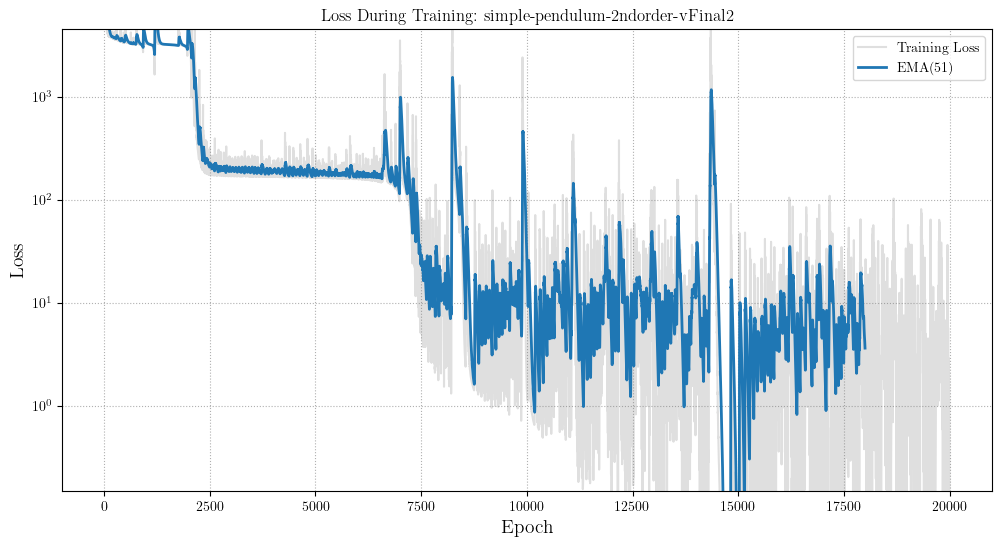

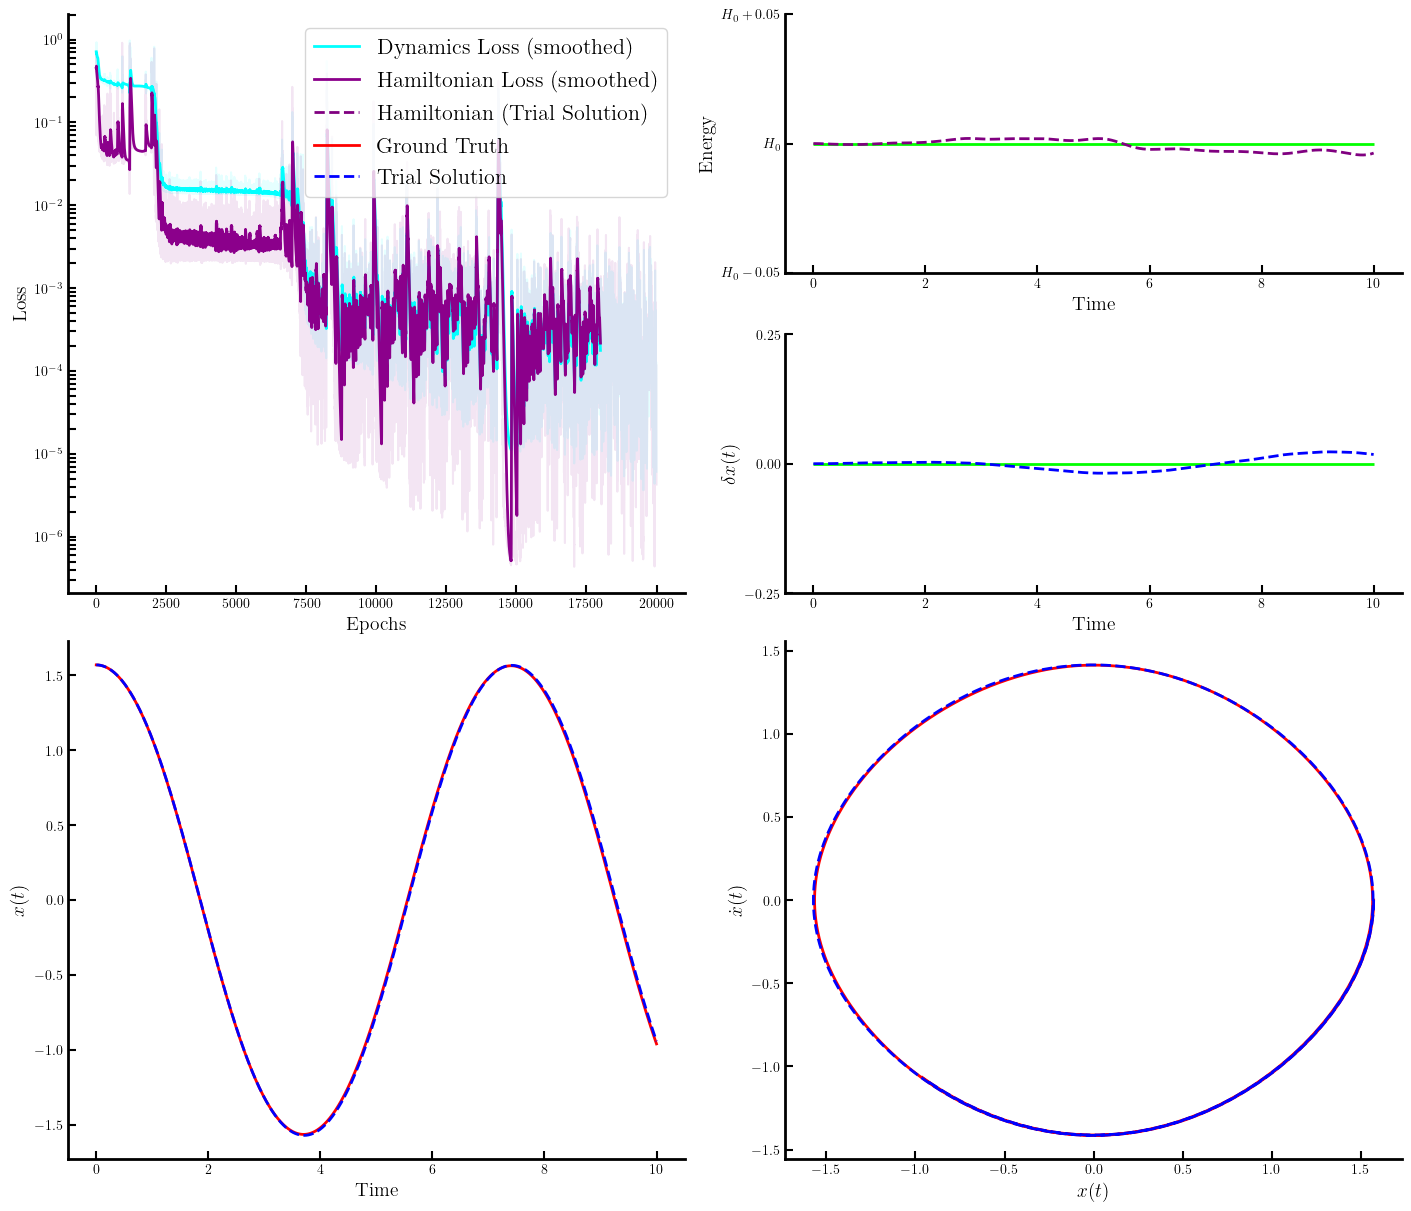

  0%|                                         | 1/20000 [00:00<44:09,  7.55it/s]

-13.789631802151042


  1%|▏                                      | 102/20000 [00:11<35:10,  9.43it/s]

-17.580488610947825


  1%|▍                                      | 202/20000 [00:22<35:20,  9.34it/s]

-18.15156574257614


  2%|▌                                      | 302/20000 [00:32<35:47,  9.17it/s]

-18.288098383835


  2%|▊                                      | 402/20000 [00:43<33:23,  9.78it/s]

-18.3439022144551


  3%|▉                                      | 501/20000 [00:54<32:58,  9.86it/s]

-18.38235998166457


  3%|█▏                                     | 602/20000 [01:05<34:24,  9.40it/s]

-18.411125303170436


  4%|█▎                                     | 702/20000 [01:15<33:35,  9.57it/s]

-18.434069268445484


  4%|█▌                                     | 802/20000 [01:26<34:23,  9.30it/s]

-18.452787823450606


  5%|█▊                                     | 902/20000 [01:37<38:31,  8.26it/s]

-18.468783431798876


  5%|█▉                                    | 1002/20000 [01:48<35:08,  9.01it/s]

-18.482518730760006


  6%|██                                    | 1101/20000 [02:00<37:59,  8.29it/s]

-18.41016945380378


  6%|██▎                                   | 1202/20000 [02:12<34:29,  9.08it/s]

-18.506970640860768


  7%|██▍                                   | 1302/20000 [02:23<34:42,  8.98it/s]

-18.517518715690095


  7%|██▋                                   | 1402/20000 [02:34<33:20,  9.29it/s]

-18.52666137694496


  8%|██▊                                   | 1502/20000 [02:45<33:15,  9.27it/s]

-18.53067455013599


  8%|███                                   | 1602/20000 [02:56<31:02,  9.88it/s]

-18.527459953607615


  9%|███▏                                  | 1702/20000 [03:07<32:56,  9.26it/s]

-18.55044093098163


  9%|███▍                                  | 1802/20000 [03:18<32:20,  9.38it/s]

-18.55616864818758


 10%|███▌                                  | 1902/20000 [03:29<33:08,  9.10it/s]

-18.55424118277411


 10%|███▊                                  | 2002/20000 [03:39<31:34,  9.50it/s]

-18.56891290483312


 11%|███▉                                  | 2102/20000 [03:50<32:14,  9.25it/s]

-18.574079360367097


 11%|████▏                                 | 2202/20000 [04:01<32:34,  9.11it/s]

-18.578786913264082


 12%|████▎                                 | 2302/20000 [04:12<31:42,  9.30it/s]

-18.583766897598498


 12%|████▌                                 | 2402/20000 [04:23<31:17,  9.37it/s]

-18.587286001511444


 13%|████▊                                 | 2502/20000 [04:34<31:32,  9.25it/s]

-18.590623454581156


 13%|████▉                                 | 2602/20000 [04:45<30:27,  9.52it/s]

-18.595549894313358


 14%|█████▏                                | 2702/20000 [04:56<30:59,  9.30it/s]

-18.60015644174949


 14%|█████▎                                | 2802/20000 [05:06<30:20,  9.45it/s]

-18.603386030032926


 15%|█████▌                                | 2902/20000 [05:17<30:38,  9.30it/s]

-18.606511522556556


 15%|█████▋                                | 3002/20000 [05:28<30:06,  9.41it/s]

-18.608387040893216


 16%|█████▉                                | 3102/20000 [05:38<29:52,  9.43it/s]

-18.58760899299507


 16%|██████                                | 3202/20000 [05:49<31:08,  8.99it/s]

-18.617323007001133


 17%|██████▎                               | 3302/20000 [06:00<30:42,  9.06it/s]

-18.619970007423834


 17%|██████▍                               | 3402/20000 [06:11<30:56,  8.94it/s]

-18.588910077552697


 18%|██████▋                               | 3502/20000 [06:22<31:57,  8.60it/s]

-18.626128172879426


 18%|██████▊                               | 3602/20000 [06:33<28:27,  9.60it/s]

-18.628575009226044


 19%|███████                               | 3702/20000 [06:44<28:58,  9.38it/s]

-18.631115429134905


 19%|███████▏                              | 3802/20000 [06:55<30:03,  8.98it/s]

-18.631780330055733


 20%|███████▍                              | 3902/20000 [07:05<29:53,  8.98it/s]

-18.636312615817786


 20%|███████▌                              | 4002/20000 [07:16<29:06,  9.16it/s]

-18.557141584650964


 21%|███████▊                              | 4102/20000 [07:27<28:38,  9.25it/s]

-18.633561505458307


 21%|███████▉                              | 4201/20000 [07:37<31:22,  8.39it/s]

-18.626987123173624


 22%|████████▏                             | 4302/20000 [07:48<27:37,  9.47it/s]

-18.639323980892783


 22%|████████▎                             | 4402/20000 [07:59<28:00,  9.28it/s]

-18.598073259700957


 23%|████████▌                             | 4502/20000 [08:09<27:13,  9.49it/s]

-18.649187170510345


 23%|████████▋                             | 4602/20000 [08:21<27:03,  9.49it/s]

-18.646501089309893


 24%|████████▉                             | 4702/20000 [08:31<27:58,  9.11it/s]

-18.53880659192405


 24%|█████████                             | 4802/20000 [08:42<27:35,  9.18it/s]

-18.654842239113588


 25%|█████████▎                            | 4902/20000 [08:54<27:10,  9.26it/s]

-18.635758045663


 25%|█████████▌                            | 5002/20000 [09:05<27:28,  9.10it/s]

-18.642737202569084


 26%|█████████▋                            | 5102/20000 [09:16<26:11,  9.48it/s]

-18.65934541594777


 26%|█████████▉                            | 5202/20000 [09:26<26:34,  9.28it/s]

-18.657775762411013


 27%|██████████                            | 5302/20000 [09:37<28:18,  8.65it/s]

-18.597629231706243


 27%|██████████▎                           | 5402/20000 [09:48<27:09,  8.96it/s]

-18.657895869672853


 28%|██████████▍                           | 5502/20000 [10:00<26:25,  9.15it/s]

-18.662923633156563


 28%|██████████▋                           | 5602/20000 [10:11<26:13,  9.15it/s]

-18.654717725771043


 29%|██████████▊                           | 5701/20000 [10:22<29:21,  8.12it/s]

-18.668417249005653


 29%|███████████                           | 5802/20000 [10:33<25:23,  9.32it/s]

-18.6679867612148


 30%|███████████▏                          | 5902/20000 [10:43<25:50,  9.09it/s]

-18.669380131744973


 30%|███████████▍                          | 6002/20000 [10:54<24:17,  9.61it/s]

-18.66998586976055


 31%|███████████▌                          | 6102/20000 [11:05<24:35,  9.42it/s]

-18.67260310094786


 31%|███████████▊                          | 6201/20000 [11:16<28:21,  8.11it/s]

-18.473547757432282


 32%|███████████▉                          | 6302/20000 [11:27<24:22,  9.36it/s]

-18.649647388565025


 32%|████████████▏                         | 6402/20000 [11:37<24:07,  9.40it/s]

-18.672355434236017


 33%|████████████▎                         | 6502/20000 [11:48<23:54,  9.41it/s]

-18.67341059390635


 33%|████████████▌                         | 6602/20000 [11:58<23:42,  9.42it/s]

-18.67777385260298


 34%|████████████▋                         | 6702/20000 [12:09<22:49,  9.71it/s]

-18.5843227285675


 34%|████████████▉                         | 6802/20000 [12:19<23:17,  9.44it/s]

-18.67495439215061


 35%|█████████████                         | 6902/20000 [12:30<22:26,  9.73it/s]

-18.68011165695754


 35%|█████████████▎                        | 7002/20000 [12:41<23:01,  9.41it/s]

-18.567425729728978


 36%|█████████████▍                        | 7102/20000 [12:51<23:48,  9.03it/s]

-18.681178169806078


 36%|█████████████▋                        | 7202/20000 [13:02<21:57,  9.71it/s]

-18.66905728243522


 37%|█████████████▊                        | 7302/20000 [13:12<21:57,  9.64it/s]

-18.663703254684002


 37%|██████████████                        | 7402/20000 [13:22<23:45,  8.84it/s]

-18.681652824854982


 38%|██████████████▎                       | 7502/20000 [13:34<21:51,  9.53it/s]

-18.684631115063326


 38%|██████████████▍                       | 7602/20000 [13:44<20:55,  9.88it/s]

-18.604073266039286


 39%|██████████████▋                       | 7701/20000 [13:55<21:15,  9.65it/s]

-18.67740626217161


 39%|██████████████▊                       | 7802/20000 [14:05<20:45,  9.79it/s]

-18.682193437581553


 40%|███████████████                       | 7902/20000 [14:16<20:42,  9.73it/s]

-18.686516960015645


 40%|███████████████▏                      | 8002/20000 [14:27<20:37,  9.70it/s]

-18.688496878750293


 41%|███████████████▍                      | 8102/20000 [14:37<20:30,  9.67it/s]

-18.689603840733533


 41%|███████████████▌                      | 8202/20000 [14:48<20:48,  9.45it/s]

-18.690184078370034


 42%|███████████████▊                      | 8301/20000 [14:58<20:38,  9.44it/s]

-18.6907353453108


 42%|███████████████▉                      | 8402/20000 [15:09<20:39,  9.35it/s]

-18.64886053142684


 43%|████████████████▏                     | 8502/20000 [15:20<20:37,  9.29it/s]

-18.692053700131172


 43%|████████████████▎                     | 8602/20000 [15:30<19:51,  9.57it/s]

-18.669744197128082


 44%|████████████████▌                     | 8702/20000 [15:41<20:13,  9.31it/s]

-18.58449523853772


 44%|████████████████▋                     | 8801/20000 [15:51<22:06,  8.44it/s]

-18.6936775208572


 45%|████████████████▉                     | 8902/20000 [16:02<20:53,  8.85it/s]

-18.575303072456954


 45%|█████████████████                     | 9002/20000 [16:12<19:37,  9.34it/s]

-18.6888352041146


 46%|█████████████████▎                    | 9102/20000 [16:23<19:39,  9.24it/s]

-18.689686816585596


 46%|█████████████████▍                    | 9202/20000 [16:34<19:05,  9.43it/s]

-18.69489569198671


 47%|█████████████████▋                    | 9302/20000 [16:44<18:52,  9.45it/s]

-18.691790004949205


 47%|█████████████████▊                    | 9402/20000 [16:55<19:10,  9.21it/s]

-18.68157704608212


 48%|██████████████████                    | 9502/20000 [17:06<17:39,  9.91it/s]

-18.69332079375219


 48%|██████████████████▏                   | 9602/20000 [17:16<20:11,  8.59it/s]

-18.691701225530345


 49%|██████████████████▍                   | 9702/20000 [17:27<17:53,  9.59it/s]

-18.698602115588322


 49%|██████████████████▌                   | 9802/20000 [17:38<18:28,  9.20it/s]

-18.69887216160311


 50%|██████████████████▊                   | 9902/20000 [17:48<18:05,  9.30it/s]

-18.69845805181245


 50%|██████████████████▌                  | 10002/20000 [17:59<16:53,  9.87it/s]

-18.70053506372777


 51%|██████████████████▋                  | 10102/20000 [18:10<17:40,  9.34it/s]

-18.695917332757936


 51%|██████████████████▊                  | 10202/20000 [18:20<17:49,  9.16it/s]

-18.700954883982043


 52%|███████████████████                  | 10302/20000 [18:31<17:36,  9.18it/s]

-18.67352597348375


 52%|███████████████████▏                 | 10402/20000 [18:42<17:29,  9.15it/s]

-18.689924473549762


 53%|███████████████████▍                 | 10502/20000 [18:52<17:46,  8.91it/s]

-18.70210286934923


 53%|███████████████████▌                 | 10602/20000 [19:03<16:41,  9.38it/s]

-18.68269857645405


 54%|███████████████████▊                 | 10702/20000 [19:14<16:10,  9.58it/s]

-18.701166904862085


 54%|███████████████████▉                 | 10802/20000 [19:25<15:59,  9.59it/s]

-18.69792017656527


 55%|████████████████████▏                | 10902/20000 [19:35<16:27,  9.21it/s]

-18.687014719398746


 55%|████████████████████▎                | 11002/20000 [19:46<15:42,  9.55it/s]

-18.704864571598236


 56%|████████████████████▌                | 11102/20000 [19:57<15:28,  9.58it/s]

-18.683006072983044


 56%|████████████████████▋                | 11202/20000 [20:08<15:46,  9.29it/s]

-18.695451268921857


 57%|████████████████████▉                | 11302/20000 [20:18<15:12,  9.53it/s]

-18.701058362354317


 57%|█████████████████████                | 11402/20000 [20:29<14:55,  9.60it/s]

-18.697557965026416


 58%|█████████████████████▎               | 11502/20000 [20:40<15:43,  9.01it/s]

-18.688754708420532


 58%|█████████████████████▍               | 11602/20000 [20:50<15:04,  9.29it/s]

-18.636732502479873


 59%|█████████████████████▋               | 11702/20000 [21:01<14:39,  9.44it/s]

-18.684056608919356


 59%|█████████████████████▊               | 11802/20000 [21:12<14:28,  9.44it/s]

-18.707868596134368


 60%|██████████████████████               | 11902/20000 [21:23<14:32,  9.28it/s]

-18.699452060810703


 60%|██████████████████████▏              | 12002/20000 [21:33<14:01,  9.50it/s]

-18.698000992655704


 61%|██████████████████████▍              | 12102/20000 [21:44<14:45,  8.92it/s]

-18.707172052237816


 61%|██████████████████████▌              | 12202/20000 [21:55<13:54,  9.35it/s]

-18.681186673937738


 62%|██████████████████████▊              | 12302/20000 [22:06<13:50,  9.26it/s]

-18.701333210437067


 62%|██████████████████████▉              | 12402/20000 [22:17<13:40,  9.26it/s]

-18.689490635845868


 63%|███████████████████████▏             | 12502/20000 [22:28<13:23,  9.33it/s]

-18.70592297358151


 63%|███████████████████████▎             | 12602/20000 [22:38<12:50,  9.60it/s]

-18.70889831385032


 64%|███████████████████████▍             | 12702/20000 [22:50<12:46,  9.52it/s]

-18.711052866043524


 64%|███████████████████████▋             | 12802/20000 [23:00<12:50,  9.34it/s]

-18.703969906150377


 65%|███████████████████████▊             | 12902/20000 [23:11<12:13,  9.67it/s]

-18.685347435815792


 65%|████████████████████████             | 13002/20000 [23:22<12:36,  9.25it/s]

-18.700206316197765


 66%|████████████████████████▏            | 13102/20000 [23:33<12:34,  9.14it/s]

-18.596390484108497


 66%|████████████████████████▍            | 13202/20000 [23:43<11:57,  9.48it/s]

-18.628786774413143


 67%|████████████████████████▌            | 13302/20000 [23:54<12:18,  9.07it/s]

-18.708209955736038


 67%|████████████████████████▊            | 13402/20000 [24:04<11:35,  9.49it/s]

-18.712565757841634


 68%|████████████████████████▉            | 13502/20000 [24:15<11:37,  9.32it/s]

-18.71420441092291


 68%|█████████████████████████▏           | 13602/20000 [24:26<11:35,  9.19it/s]

-18.688426489828117


 69%|█████████████████████████▎           | 13702/20000 [24:36<11:01,  9.52it/s]

-18.71145541186065


 69%|█████████████████████████▌           | 13802/20000 [24:47<11:09,  9.25it/s]

-18.710455876165234


 70%|█████████████████████████▋           | 13902/20000 [24:58<10:36,  9.58it/s]

-18.70667694856607


 70%|█████████████████████████▉           | 14002/20000 [25:08<10:44,  9.30it/s]

-18.550679041400144


 71%|██████████████████████████           | 14102/20000 [25:19<10:52,  9.04it/s]

-18.48674688868614


 71%|██████████████████████████▎          | 14202/20000 [25:30<10:33,  9.16it/s]

-18.688174681363996


 72%|██████████████████████████▍          | 14302/20000 [25:41<10:15,  9.25it/s]

-18.716300171276863


 72%|██████████████████████████▋          | 14402/20000 [25:52<10:38,  8.76it/s]

-18.633021551148


 73%|██████████████████████████▊          | 14502/20000 [26:02<09:33,  9.59it/s]

-18.71530572302993


 73%|███████████████████████████          | 14602/20000 [26:13<09:35,  9.38it/s]

-18.69780372926522


 74%|███████████████████████████▏         | 14702/20000 [26:24<09:39,  9.14it/s]

-18.673752778363607


 74%|███████████████████████████▍         | 14802/20000 [26:35<09:10,  9.44it/s]

-18.65528591394388


 75%|███████████████████████████▌         | 14902/20000 [26:46<09:17,  9.15it/s]

-18.717189157616254


 75%|███████████████████████████▊         | 15002/20000 [26:57<08:50,  9.42it/s]

-18.718048746755915


 76%|███████████████████████████▉         | 15102/20000 [27:08<08:26,  9.66it/s]

-18.687881939174154


 76%|████████████████████████████         | 15202/20000 [27:18<08:33,  9.35it/s]

-18.709697352158212


 77%|████████████████████████████▎        | 15302/20000 [27:29<08:26,  9.28it/s]

-18.716705407477782


 77%|████████████████████████████▍        | 15402/20000 [27:40<08:15,  9.29it/s]

-18.69322716885939


 78%|████████████████████████████▋        | 15501/20000 [27:50<08:06,  9.25it/s]

-18.716616762685796


 78%|████████████████████████████▊        | 15602/20000 [28:01<07:48,  9.39it/s]

-18.702497346582184


 79%|█████████████████████████████        | 15702/20000 [28:12<07:34,  9.45it/s]

-18.69355422388678


 79%|█████████████████████████████▏       | 15802/20000 [28:23<07:38,  9.15it/s]

-18.659432535738556


 80%|█████████████████████████████▍       | 15902/20000 [28:34<07:07,  9.59it/s]

-18.72031335347806


 80%|█████████████████████████████▌       | 16002/20000 [28:44<07:07,  9.35it/s]

-18.70337344256739


 81%|█████████████████████████████▊       | 16102/20000 [28:55<07:12,  9.01it/s]

-18.720832074608175


 81%|█████████████████████████████▉       | 16202/20000 [29:06<06:43,  9.41it/s]

-18.69262146068037


 82%|██████████████████████████████▏      | 16302/20000 [29:17<06:59,  8.81it/s]

-18.70034890396485


 82%|██████████████████████████████▎      | 16402/20000 [29:28<06:26,  9.31it/s]

-18.71548209943655


 83%|██████████████████████████████▌      | 16502/20000 [29:38<06:13,  9.37it/s]

-18.70471801942117


 83%|██████████████████████████████▋      | 16601/20000 [29:49<06:09,  9.20it/s]

-18.718022378503093


 84%|██████████████████████████████▉      | 16702/20000 [30:00<05:53,  9.32it/s]

-18.708924284292834


 84%|███████████████████████████████      | 16802/20000 [30:11<05:35,  9.54it/s]

-18.71915470966733


 85%|███████████████████████████████▎     | 16901/20000 [30:22<05:19,  9.70it/s]

-18.713632077205475


 85%|███████████████████████████████▍     | 17002/20000 [30:32<05:27,  9.15it/s]

-18.58561390544189


 86%|███████████████████████████████▋     | 17102/20000 [30:43<05:07,  9.43it/s]

-18.716249798921698


 86%|███████████████████████████████▊     | 17202/20000 [30:54<04:55,  9.45it/s]

-18.698110258743156


 87%|████████████████████████████████     | 17302/20000 [31:06<04:50,  9.30it/s]

-18.713342216160793


 87%|████████████████████████████████▏    | 17401/20000 [31:16<04:39,  9.29it/s]

-18.664264572495497


 88%|████████████████████████████████▍    | 17502/20000 [31:27<04:29,  9.28it/s]

-18.673838876694766


 88%|████████████████████████████████▌    | 17602/20000 [31:38<04:22,  9.15it/s]

-18.691841358879522


 89%|████████████████████████████████▋    | 17702/20000 [31:48<04:15,  9.00it/s]

-18.724378098769378


 89%|████████████████████████████████▉    | 17802/20000 [31:59<03:57,  9.27it/s]

-18.677489491335916


 90%|█████████████████████████████████    | 17902/20000 [32:10<03:48,  9.20it/s]

-18.723128188828746


 90%|█████████████████████████████████▎   | 18002/20000 [32:21<03:32,  9.41it/s]

-18.725115186111154


 91%|█████████████████████████████████▍   | 18102/20000 [32:31<03:21,  9.42it/s]

-18.64908991252674


 91%|█████████████████████████████████▋   | 18202/20000 [32:42<03:11,  9.39it/s]

-18.713297524441263


 92%|█████████████████████████████████▊   | 18302/20000 [32:53<03:10,  8.93it/s]

-18.665391878944185


 92%|██████████████████████████████████   | 18402/20000 [33:04<02:54,  9.18it/s]

-18.724986280769173


 93%|██████████████████████████████████▏  | 18502/20000 [33:15<02:45,  9.04it/s]

-18.71343746319564


 93%|██████████████████████████████████▍  | 18602/20000 [33:26<02:31,  9.21it/s]

-18.70636482909416


 94%|██████████████████████████████████▌  | 18702/20000 [33:36<02:15,  9.56it/s]

-18.724944619552538


 94%|██████████████████████████████████▊  | 18802/20000 [33:47<02:06,  9.49it/s]

-18.725575351189185


 95%|██████████████████████████████████▉  | 18902/20000 [33:58<01:56,  9.42it/s]

-18.720276587783346


 95%|███████████████████████████████████▏ | 19002/20000 [34:08<01:45,  9.47it/s]

-18.71824587560974


 96%|███████████████████████████████████▎ | 19102/20000 [34:19<01:34,  9.51it/s]

-18.68586077622396


 96%|███████████████████████████████████▌ | 19202/20000 [34:30<01:24,  9.50it/s]

-18.675121649693516


 97%|███████████████████████████████████▋ | 19302/20000 [34:40<01:20,  8.72it/s]

-18.717279942276193


 97%|███████████████████████████████████▉ | 19402/20000 [34:51<01:06,  9.04it/s]

-18.70269136905079


 98%|████████████████████████████████████ | 19502/20000 [35:02<00:53,  9.28it/s]

-18.70916211681112


 98%|████████████████████████████████████▎| 19602/20000 [35:12<00:42,  9.29it/s]

-18.71931767306207


 99%|████████████████████████████████████▍| 19702/20000 [35:23<00:31,  9.44it/s]

-18.71169245440747


 99%|████████████████████████████████████▋| 19802/20000 [35:34<00:21,  9.34it/s]

-18.726188776857356


100%|████████████████████████████████████▊| 19902/20000 [35:45<00:10,  9.42it/s]

-18.713346208199496


100%|█████████████████████████████████████| 20000/20000 [35:56<00:00,  9.28it/s]


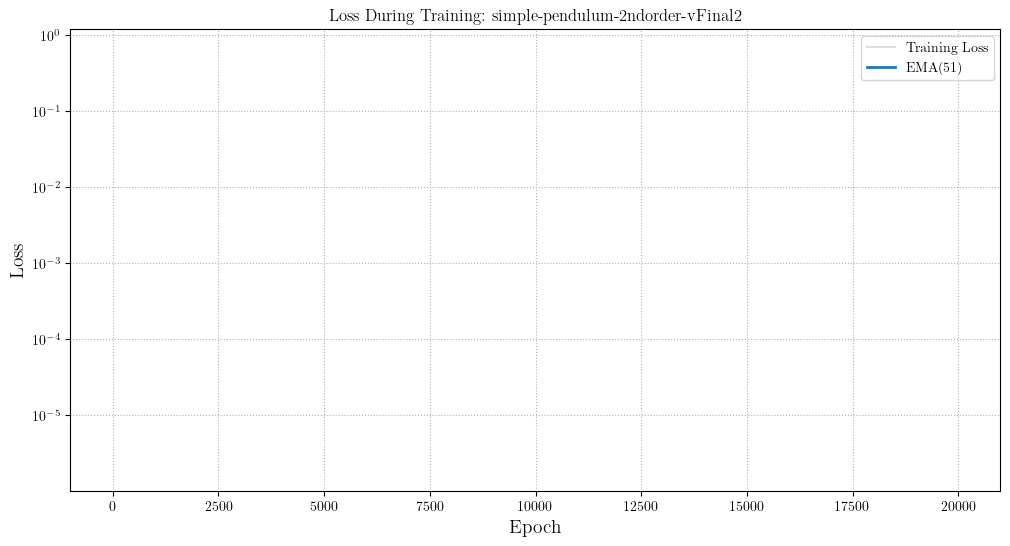

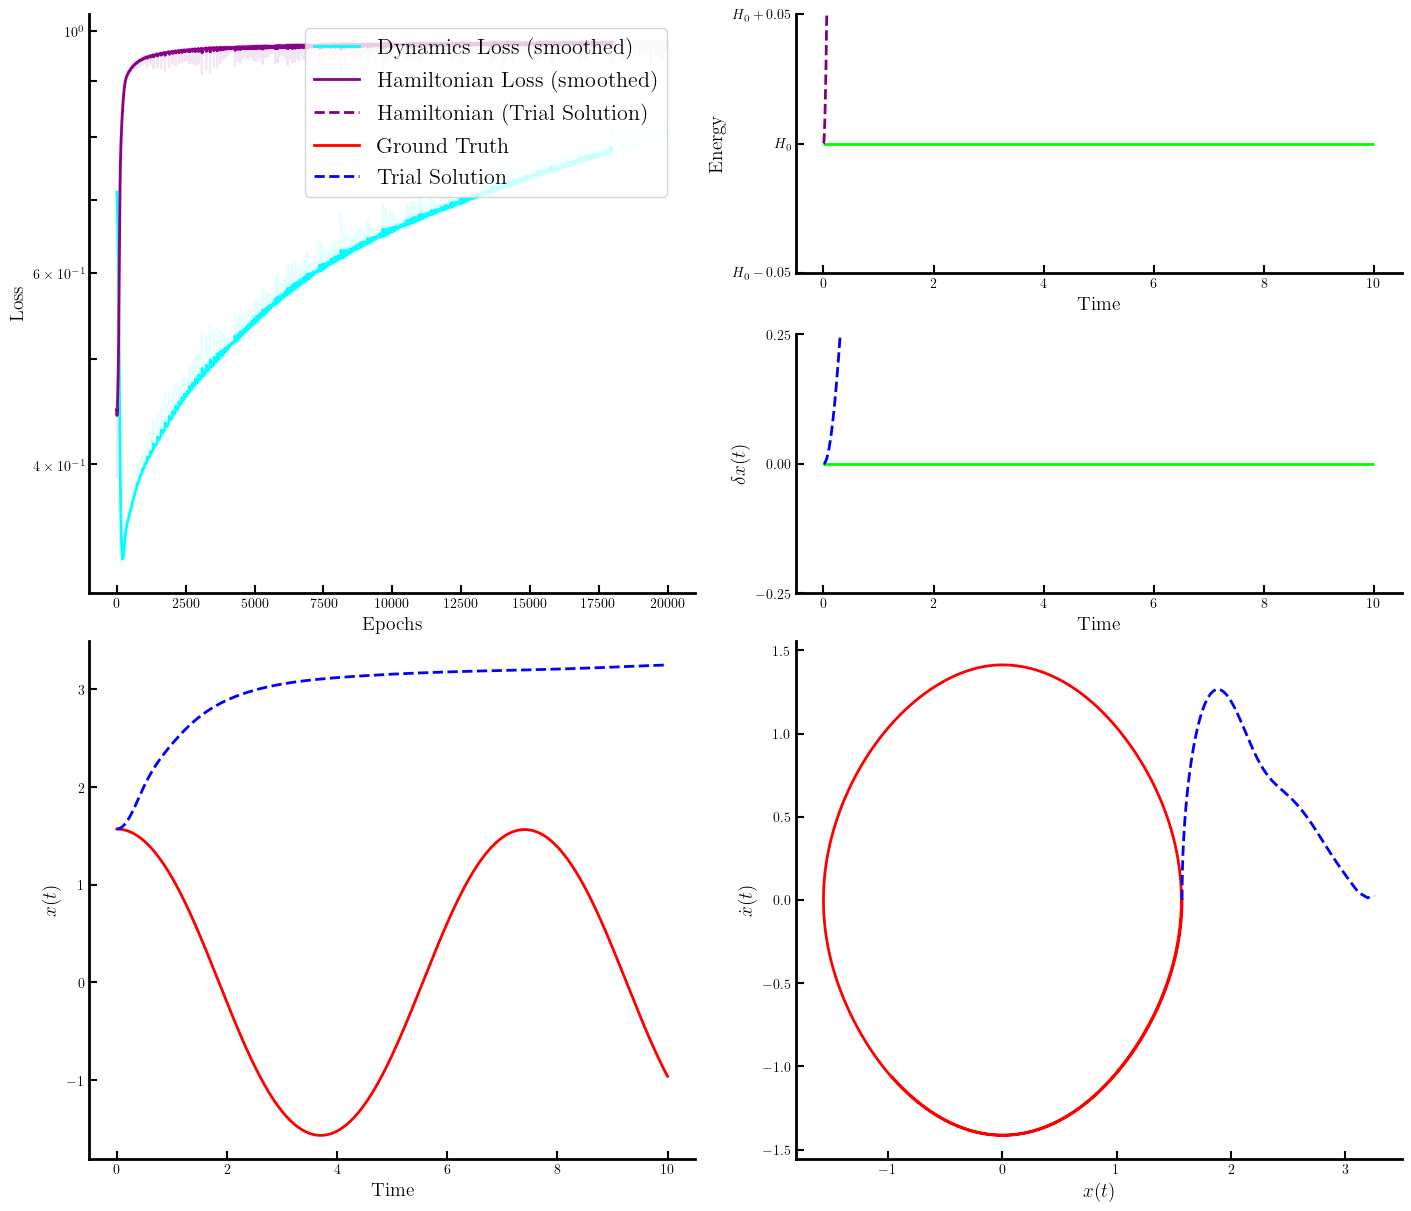

  0%|                                         | 2/20000 [00:00<36:13,  9.20it/s]

7110.712831348228


  1%|▏                                      | 102/20000 [00:10<32:41, 10.14it/s]

3488.0464059868314


  1%|▍                                      | 202/20000 [00:20<32:55, 10.02it/s]

3161.7792661450803


  2%|▌                                      | 301/20000 [00:30<32:55,  9.97it/s]

3137.6811680257993


  2%|▊                                      | 402/20000 [00:40<34:09,  9.56it/s]

3113.091901045329


  3%|▉                                      | 501/20000 [00:51<34:57,  9.30it/s]

3103.01223624052


  3%|█▏                                     | 602/20000 [01:01<33:16,  9.71it/s]

3096.3988272617835


  4%|█▎                                     | 702/20000 [01:12<34:40,  9.28it/s]

3091.022963205409


  4%|█▌                                     | 802/20000 [01:22<34:35,  9.25it/s]

3086.4353994639564


  5%|█▊                                     | 902/20000 [01:33<33:39,  9.46it/s]

3082.805261831845


  5%|█▉                                    | 1002/20000 [01:44<36:10,  8.75it/s]

3084.582432254723


  6%|██                                    | 1102/20000 [01:54<35:08,  8.96it/s]

3078.1747163682453


  6%|██▎                                   | 1202/20000 [02:05<32:22,  9.68it/s]

3076.6443042505853


  7%|██▍                                   | 1302/20000 [02:15<32:26,  9.61it/s]

3090.845969016562


  7%|██▋                                   | 1402/20000 [02:27<32:46,  9.46it/s]

3074.2171011959977


  8%|██▊                                   | 1501/20000 [02:37<29:50, 10.33it/s]

3073.220289531816


  8%|███                                   | 1602/20000 [02:47<32:32,  9.42it/s]

3072.4512591257076


  9%|███▏                                  | 1702/20000 [02:58<31:50,  9.58it/s]

3071.89616778801


  9%|███▍                                  | 1802/20000 [03:08<31:29,  9.63it/s]

3075.991245821573


 10%|███▌                                  | 1902/20000 [03:18<31:02,  9.72it/s]

3071.1487028197025


 10%|███▊                                  | 2002/20000 [03:29<31:19,  9.57it/s]

3070.1203628996245


 11%|███▉                                  | 2102/20000 [03:40<32:03,  9.30it/s]

3069.7066024234646


 11%|████▏                                 | 2201/20000 [03:50<31:22,  9.46it/s]

3069.6500587212736


 12%|████▏                               | 2301/20000 [04:01<1:05:55,  4.47it/s]

3068.938674551293


 12%|████▌                                 | 2402/20000 [04:12<31:09,  9.41it/s]

3068.6305954470195


 13%|████▊                                 | 2502/20000 [04:23<30:37,  9.52it/s]

3072.520508111871


 13%|████▉                                 | 2602/20000 [04:33<29:41,  9.77it/s]

3068.0402316650843


 14%|█████▏                                | 2702/20000 [04:44<30:39,  9.40it/s]

3068.722005375226


 14%|█████▎                                | 2802/20000 [04:55<32:47,  8.74it/s]

3071.631969931667


 15%|█████▌                                | 2902/20000 [05:06<30:43,  9.28it/s]

3067.3475081208867


 15%|█████▋                                | 3002/20000 [05:17<31:02,  9.12it/s]

3067.2068616511797


 16%|█████▉                                | 3102/20000 [05:28<30:24,  9.26it/s]

3069.161704539734


 16%|██████                                | 3202/20000 [05:39<30:33,  9.16it/s]

3067.553179826864


 17%|██████▎                               | 3302/20000 [05:50<30:15,  9.20it/s]

3066.683510670424


 17%|██████▍                               | 3402/20000 [06:01<29:47,  9.29it/s]

3066.920448895751


 18%|██████▋                               | 3502/20000 [06:12<29:59,  9.17it/s]

3104.915690491832


 18%|██████▊                               | 3602/20000 [06:23<29:32,  9.25it/s]

3066.328570291305


 19%|███████                               | 3702/20000 [06:35<29:52,  9.09it/s]

3066.2491586549468


 19%|███████▏                              | 3802/20000 [06:46<30:07,  8.96it/s]

3066.176718073212


 20%|███████▍                              | 3902/20000 [06:57<30:29,  8.80it/s]

3066.688613759247


 20%|███████▌                              | 4002/20000 [07:08<28:36,  9.32it/s]

3066.0000392262064


 21%|███████▊                              | 4102/20000 [07:19<28:11,  9.40it/s]

3079.736331150007


 21%|███████▉                              | 4202/20000 [07:30<27:29,  9.58it/s]

3065.8456353515057


 22%|████████▏                             | 4302/20000 [07:41<29:19,  8.92it/s]

3065.873621442414


 22%|████████▎                             | 4402/20000 [07:51<27:14,  9.54it/s]

3067.093706836563


 23%|████████▌                             | 4502/20000 [08:02<27:10,  9.50it/s]

3065.680114485912


 23%|████████▋                             | 4602/20000 [08:12<26:34,  9.66it/s]

3065.6848894659424


 24%|████████▉                             | 4702/20000 [08:23<26:19,  9.69it/s]

3065.8282535008802


 24%|█████████                             | 4801/20000 [08:33<25:06, 10.09it/s]

3065.570152072658


 25%|█████████▎                            | 4902/20000 [08:44<27:19,  9.21it/s]

3071.135601509178


 25%|█████████▌                            | 5002/20000 [08:55<28:35,  8.74it/s]

3065.49666098792


 26%|█████████▋                            | 5102/20000 [09:05<26:17,  9.44it/s]

3065.6333610192214


 26%|█████████▉                            | 5202/20000 [09:16<25:50,  9.54it/s]

3065.4297580007537


 27%|██████████                            | 5301/20000 [09:26<25:13,  9.71it/s]

3065.4148614409605


 27%|██████████▎                           | 5401/20000 [09:37<23:46, 10.24it/s]

3081.869476606835


 28%|██████████▍                           | 5502/20000 [09:47<24:35,  9.83it/s]

3065.355891570268


 28%|██████████▋                           | 5602/20000 [09:58<25:37,  9.37it/s]

3065.659717054792


 29%|██████████▊                           | 5702/20000 [10:10<25:28,  9.35it/s]

3065.3072337033036


 29%|███████████                           | 5802/20000 [10:20<25:04,  9.44it/s]

3065.3526809244368


 30%|███████████▏                          | 5902/20000 [10:31<24:25,  9.62it/s]

3065.272475385318


 30%|███████████▍                          | 6002/20000 [10:41<24:43,  9.43it/s]

3065.2823096500006


 31%|███████████▌                          | 6102/20000 [10:52<24:48,  9.33it/s]

3075.2253612762606


 31%|███████████▊                          | 6202/20000 [11:03<23:18,  9.86it/s]

3065.2251708455824


 32%|███████████▉                          | 6302/20000 [11:13<24:14,  9.42it/s]

3069.6509232315857


 32%|████████████▏                         | 6402/20000 [11:24<24:02,  9.42it/s]

3065.190796815817


 33%|████████████▎                         | 6502/20000 [11:34<24:39,  9.12it/s]

3065.542397513019


 33%|████████████▌                         | 6602/20000 [11:45<22:27,  9.94it/s]

3065.1786339353102


 34%|████████████▋                         | 6702/20000 [11:56<23:46,  9.32it/s]

3065.1594132972223


 34%|████████████▉                         | 6802/20000 [12:06<23:43,  9.27it/s]

3068.0881986400677


 35%|█████████████                         | 6902/20000 [12:17<23:20,  9.35it/s]

3065.125123996869


 35%|█████████████▎                        | 7002/20000 [12:28<23:26,  9.24it/s]

3065.361213927904


 36%|█████████████▍                        | 7102/20000 [12:38<22:08,  9.71it/s]

3065.114817992911


 36%|█████████████▋                        | 7202/20000 [12:49<23:04,  9.24it/s]

3065.1104867634303


 37%|█████████████▊                        | 7302/20000 [13:00<21:46,  9.72it/s]

3073.999966839759


 37%|██████████████                        | 7402/20000 [13:10<22:37,  9.28it/s]

3065.073602903163


 38%|██████████████▎                       | 7502/20000 [13:21<22:28,  9.27it/s]

3065.265979708186


 38%|██████████████▍                       | 7602/20000 [13:31<21:23,  9.66it/s]

3065.4631743047685


 39%|██████████████▋                       | 7702/20000 [13:42<21:17,  9.62it/s]

3065.0535801724045


 39%|██████████████▊                       | 7802/20000 [13:52<21:11,  9.59it/s]

3065.8218198422455


 40%|███████████████                       | 7902/20000 [14:03<21:32,  9.36it/s]

3065.0708042345886


 40%|███████████████▏                      | 8002/20000 [14:14<21:34,  9.27it/s]

3065.0333770277975


 41%|███████████████▍                      | 8102/20000 [14:24<20:17,  9.78it/s]

3065.3794616697496


 41%|███████████████▌                      | 8202/20000 [14:36<21:19,  9.22it/s]

3068.9261569354317


 42%|███████████████▊                      | 8302/20000 [14:46<20:57,  9.30it/s]

3065.0056322373985


 42%|███████████████▉                      | 8402/20000 [14:57<20:38,  9.36it/s]

3065.1211827787033


 43%|████████████████▏                     | 8502/20000 [15:07<19:31,  9.81it/s]

3064.998072359523


 43%|████████████████▎                     | 8602/20000 [15:18<19:48,  9.59it/s]

3064.9938101840967


 44%|████████████████▌                     | 8702/20000 [15:29<19:25,  9.70it/s]

3065.4042976009537


 44%|████████████████▋                     | 8802/20000 [15:39<20:15,  9.21it/s]

3064.971571400517


 45%|████████████████▉                     | 8902/20000 [15:50<19:37,  9.42it/s]

3065.228506759958


 45%|█████████████████                     | 9002/20000 [16:00<19:25,  9.44it/s]

3064.961760367082


 46%|█████████████████▎                    | 9102/20000 [16:11<19:25,  9.35it/s]

3064.980156115495


 46%|█████████████████▍                    | 9202/20000 [16:22<19:46,  9.10it/s]

3071.0048128461585


 47%|█████████████████▋                    | 9302/20000 [16:33<18:52,  9.44it/s]

3064.9442574819304


 47%|█████████████████▊                    | 9402/20000 [16:43<19:24,  9.10it/s]

3065.0061467879714


 48%|██████████████████                    | 9501/20000 [16:54<19:41,  8.88it/s]

3073.420054846882


 48%|██████████████████▏                   | 9601/20000 [17:04<19:06,  9.07it/s]

3064.9373413928984


 49%|██████████████████▍                   | 9702/20000 [17:15<18:16,  9.40it/s]

3065.5414102691348


 49%|██████████████████▌                   | 9802/20000 [17:26<18:15,  9.31it/s]

3064.9231429900997


 50%|██████████████████▊                   | 9902/20000 [17:37<17:19,  9.71it/s]

3064.969183080608


 50%|██████████████████▌                  | 10002/20000 [17:48<17:37,  9.45it/s]

3075.303047800064


 51%|██████████████████▋                  | 10102/20000 [17:58<16:42,  9.88it/s]

3064.916908882398


 51%|██████████████████▊                  | 10202/20000 [18:09<17:38,  9.26it/s]

3065.9091147673053


 52%|███████████████████                  | 10302/20000 [18:20<17:12,  9.39it/s]

3064.908188701037


 52%|███████████████████▏                 | 10402/20000 [18:30<16:13,  9.86it/s]

3066.6151989858754


 53%|███████████████████▍                 | 10502/20000 [18:41<15:59,  9.90it/s]

3064.907696923593


 53%|███████████████████▌                 | 10602/20000 [18:52<16:24,  9.55it/s]

3064.897274000182


 54%|███████████████████▊                 | 10702/20000 [19:03<15:43,  9.86it/s]

3064.917947532368


 54%|███████████████████▉                 | 10802/20000 [19:13<15:48,  9.70it/s]

3064.895599828141


 55%|████████████████████▏                | 10901/20000 [19:23<15:35,  9.72it/s]

3065.590036114037


 55%|████████████████████▎                | 11002/20000 [19:34<15:37,  9.60it/s]

3064.894689849598


 56%|████████████████████▌                | 11102/20000 [19:45<15:09,  9.78it/s]

3101.5451187721037


 56%|████████████████████▋                | 11202/20000 [19:56<15:32,  9.44it/s]

3064.893723898312


 57%|████████████████████▉                | 11302/20000 [20:06<15:44,  9.21it/s]

3069.087030201979


 57%|█████████████████████                | 11402/20000 [20:17<15:40,  9.15it/s]

3064.8897499535688


 58%|█████████████████████▎               | 11502/20000 [20:28<15:08,  9.35it/s]

3066.2638382931045


 58%|█████████████████████▍               | 11602/20000 [20:38<14:39,  9.54it/s]

3064.8852518983604


 59%|█████████████████████▋               | 11702/20000 [20:49<14:42,  9.40it/s]

3064.999131002331


 59%|█████████████████████▊               | 11802/20000 [21:00<14:34,  9.37it/s]

3064.880570678786


 60%|██████████████████████               | 11902/20000 [21:10<14:27,  9.33it/s]

3065.0000458727727


 60%|██████████████████████▏              | 12001/20000 [21:21<14:50,  8.98it/s]

3065.05175998399


 61%|██████████████████████▍              | 12102/20000 [21:32<13:59,  9.40it/s]

3064.886206096764


 61%|██████████████████████▌              | 12202/20000 [21:42<13:15,  9.80it/s]

3065.8674539221342


 62%|██████████████████████▊              | 12302/20000 [21:53<14:21,  8.93it/s]

3064.879098622452


 62%|██████████████████████▉              | 12402/20000 [22:04<13:35,  9.32it/s]

3064.877403025033


 63%|███████████████████████▏             | 12502/20000 [22:15<13:12,  9.47it/s]

3065.6875063656657


 63%|███████████████████████▎             | 12602/20000 [22:25<13:58,  8.83it/s]

3064.8717296608243


 64%|███████████████████████▍             | 12702/20000 [22:36<12:38,  9.63it/s]

3064.8804889479825


 64%|███████████████████████▋             | 12802/20000 [22:46<12:35,  9.53it/s]

3064.8780261985307


 65%|███████████████████████▊             | 12902/20000 [22:57<12:11,  9.71it/s]

3064.880995084523


 65%|████████████████████████             | 13002/20000 [23:07<12:14,  9.53it/s]

3065.60637267766


 66%|████████████████████████▏            | 13102/20000 [23:18<12:40,  9.07it/s]

3064.871049952535


 66%|████████████████████████▍            | 13202/20000 [23:29<11:53,  9.53it/s]

3065.787157676198


 67%|████████████████████████▌            | 13302/20000 [23:39<11:46,  9.49it/s]

3064.868416164463


 67%|████████████████████████▊            | 13402/20000 [23:50<11:37,  9.46it/s]

3065.3536240229696


 68%|████████████████████████▉            | 13502/20000 [24:00<11:36,  9.33it/s]

3064.8668408793437


 68%|█████████████████████████▏           | 13602/20000 [24:11<11:08,  9.56it/s]

3064.908315619208


 69%|█████████████████████████▎           | 13702/20000 [24:21<10:56,  9.59it/s]

3065.349313576387


 69%|█████████████████████████▌           | 13802/20000 [24:32<10:43,  9.63it/s]

3064.8730558644124


 70%|█████████████████████████▋           | 13902/20000 [24:43<10:42,  9.49it/s]

3071.813939668447


 70%|█████████████████████████▉           | 14002/20000 [24:53<10:29,  9.52it/s]

3064.8679685574616


 71%|██████████████████████████           | 14102/20000 [25:04<10:31,  9.34it/s]

3066.6843739757705


 71%|██████████████████████████▎          | 14202/20000 [25:15<10:23,  9.30it/s]

3064.8648724718673


 72%|██████████████████████████▍          | 14302/20000 [25:26<10:00,  9.49it/s]

3065.0573267650507


 72%|██████████████████████████▋          | 14402/20000 [25:37<10:04,  9.26it/s]

3064.864064568512


 73%|██████████████████████████▊          | 14502/20000 [25:49<09:54,  9.24it/s]

3064.886803001117


 73%|███████████████████████████          | 14602/20000 [26:00<09:26,  9.52it/s]

3065.658102799966


 74%|███████████████████████████▏         | 14702/20000 [26:10<10:16,  8.59it/s]

3064.871720012712


 74%|███████████████████████████▍         | 14802/20000 [26:21<08:47,  9.86it/s]

3065.0290817687855


 75%|███████████████████████████▌         | 14902/20000 [26:32<08:56,  9.51it/s]

3064.870054794048


 75%|███████████████████████████▊         | 15002/20000 [26:43<09:54,  8.41it/s]

3064.860900069005


 76%|███████████████████████████▉         | 15102/20000 [26:54<08:53,  9.19it/s]

3064.925404052332


 76%|████████████████████████████         | 15202/20000 [27:04<08:26,  9.48it/s]

3064.862498881755


 77%|████████████████████████████▎        | 15302/20000 [27:16<08:09,  9.61it/s]

3064.943765477595


 77%|████████████████████████████▍        | 15402/20000 [27:26<08:16,  9.26it/s]

3064.8654255291367


 78%|████████████████████████████▋        | 15502/20000 [27:37<07:30,  9.98it/s]

3065.006599308007


 78%|████████████████████████████▊        | 15602/20000 [27:47<07:55,  9.25it/s]

3064.8743823190375


 79%|█████████████████████████████        | 15702/20000 [27:58<07:35,  9.44it/s]

3064.8608539165393


 79%|█████████████████████████████▏       | 15802/20000 [28:08<07:36,  9.19it/s]

3065.052273330763


 80%|█████████████████████████████▍       | 15902/20000 [28:19<07:06,  9.61it/s]

3064.8624311584917


 80%|█████████████████████████████▌       | 16002/20000 [28:30<07:04,  9.43it/s]

3066.0960941279964


 81%|█████████████████████████████▊       | 16102/20000 [28:40<06:34,  9.89it/s]

3064.8626152571806


 81%|█████████████████████████████▉       | 16202/20000 [28:51<06:42,  9.43it/s]

3065.8596441790883


 82%|██████████████████████████████▏      | 16302/20000 [29:02<06:29,  9.50it/s]

3064.861251999968


 82%|██████████████████████████████▎      | 16402/20000 [29:12<06:17,  9.52it/s]

3064.9883983279124


 83%|██████████████████████████████▌      | 16502/20000 [29:23<06:23,  9.13it/s]

3064.861257241489


 83%|██████████████████████████████▋      | 16602/20000 [29:33<06:03,  9.35it/s]

3064.8829971412265


 84%|██████████████████████████████▉      | 16702/20000 [29:44<05:34,  9.86it/s]

3070.307545769112


 84%|███████████████████████████████      | 16802/20000 [29:54<06:05,  8.75it/s]

3064.8629095308556


 85%|███████████████████████████████▎     | 16902/20000 [30:05<05:42,  9.06it/s]

3064.9795292546396


 85%|███████████████████████████████▍     | 17002/20000 [30:16<05:22,  9.29it/s]

3064.8628204998117


 86%|███████████████████████████████▋     | 17102/20000 [30:26<05:13,  9.25it/s]

3064.8708674356953


 86%|███████████████████████████████▊     | 17202/20000 [30:37<04:56,  9.43it/s]

3074.033069295182


 87%|████████████████████████████████     | 17302/20000 [30:47<04:36,  9.77it/s]

3064.8606336278435


 87%|████████████████████████████████▏    | 17402/20000 [30:58<04:30,  9.62it/s]

3065.141976920684


 88%|████████████████████████████████▍    | 17502/20000 [31:09<04:15,  9.79it/s]

3064.936220832718


 88%|████████████████████████████████▌    | 17602/20000 [31:19<04:02,  9.91it/s]

3064.8687738653593


 89%|████████████████████████████████▋    | 17702/20000 [31:30<04:03,  9.42it/s]

3068.761259402387


 89%|████████████████████████████████▉    | 17801/20000 [31:41<03:56,  9.30it/s]

3064.8584737716137


 90%|█████████████████████████████████    | 17902/20000 [31:51<03:40,  9.50it/s]

3064.8890987946206


 90%|█████████████████████████████████▎   | 18002/20000 [32:02<03:28,  9.58it/s]

3090.037674565547


 91%|█████████████████████████████████▍   | 18102/20000 [32:13<03:25,  9.26it/s]

3064.85903150542


 91%|█████████████████████████████████▋   | 18202/20000 [32:23<03:11,  9.38it/s]

3065.027630754456


 92%|█████████████████████████████████▊   | 18302/20000 [32:34<03:01,  9.35it/s]

3064.856224021389


 92%|██████████████████████████████████   | 18402/20000 [32:45<02:46,  9.60it/s]

3064.9823429743337


 93%|██████████████████████████████████▏  | 18502/20000 [32:56<02:39,  9.38it/s]

3064.855832703125


 93%|██████████████████████████████████▍  | 18602/20000 [33:06<02:23,  9.73it/s]

3064.879373401743


 94%|██████████████████████████████████▌  | 18702/20000 [33:17<02:16,  9.53it/s]

3065.17258671316


 94%|██████████████████████████████████▊  | 18802/20000 [33:28<02:03,  9.71it/s]

3064.857560505964


 95%|██████████████████████████████████▉  | 18901/20000 [33:38<01:49, 10.06it/s]

3065.1182563475904


 95%|███████████████████████████████████▏ | 19002/20000 [33:49<01:44,  9.57it/s]

3065.0558798949455


 96%|███████████████████████████████████▎ | 19102/20000 [33:59<01:28, 10.14it/s]

3064.862933733114


 96%|███████████████████████████████████▌ | 19202/20000 [34:10<01:26,  9.24it/s]

3065.1650697752434


 97%|███████████████████████████████████▋ | 19302/20000 [34:21<01:17,  9.04it/s]

3064.8552175387376


 97%|███████████████████████████████████▉ | 19402/20000 [34:32<01:04,  9.22it/s]

3064.869332015379


 98%|████████████████████████████████████ | 19502/20000 [34:43<00:55,  8.93it/s]

3067.384699437165


 98%|████████████████████████████████████▎| 19602/20000 [34:53<00:40,  9.88it/s]

3064.8540287283367


 99%|████████████████████████████████████▍| 19702/20000 [35:04<00:32,  9.04it/s]

3064.8651853685215


 99%|████████████████████████████████████▋| 19802/20000 [35:15<00:20,  9.62it/s]

3064.8555737519164


100%|████████████████████████████████████▊| 19901/20000 [35:26<00:09,  9.97it/s]

3064.859536627019


100%|█████████████████████████████████████| 20000/20000 [35:35<00:00,  9.36it/s]


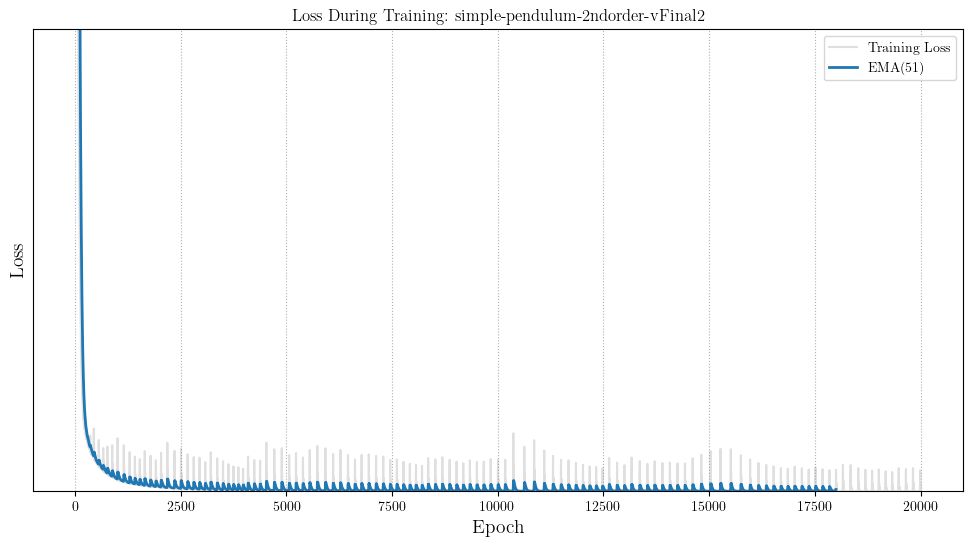

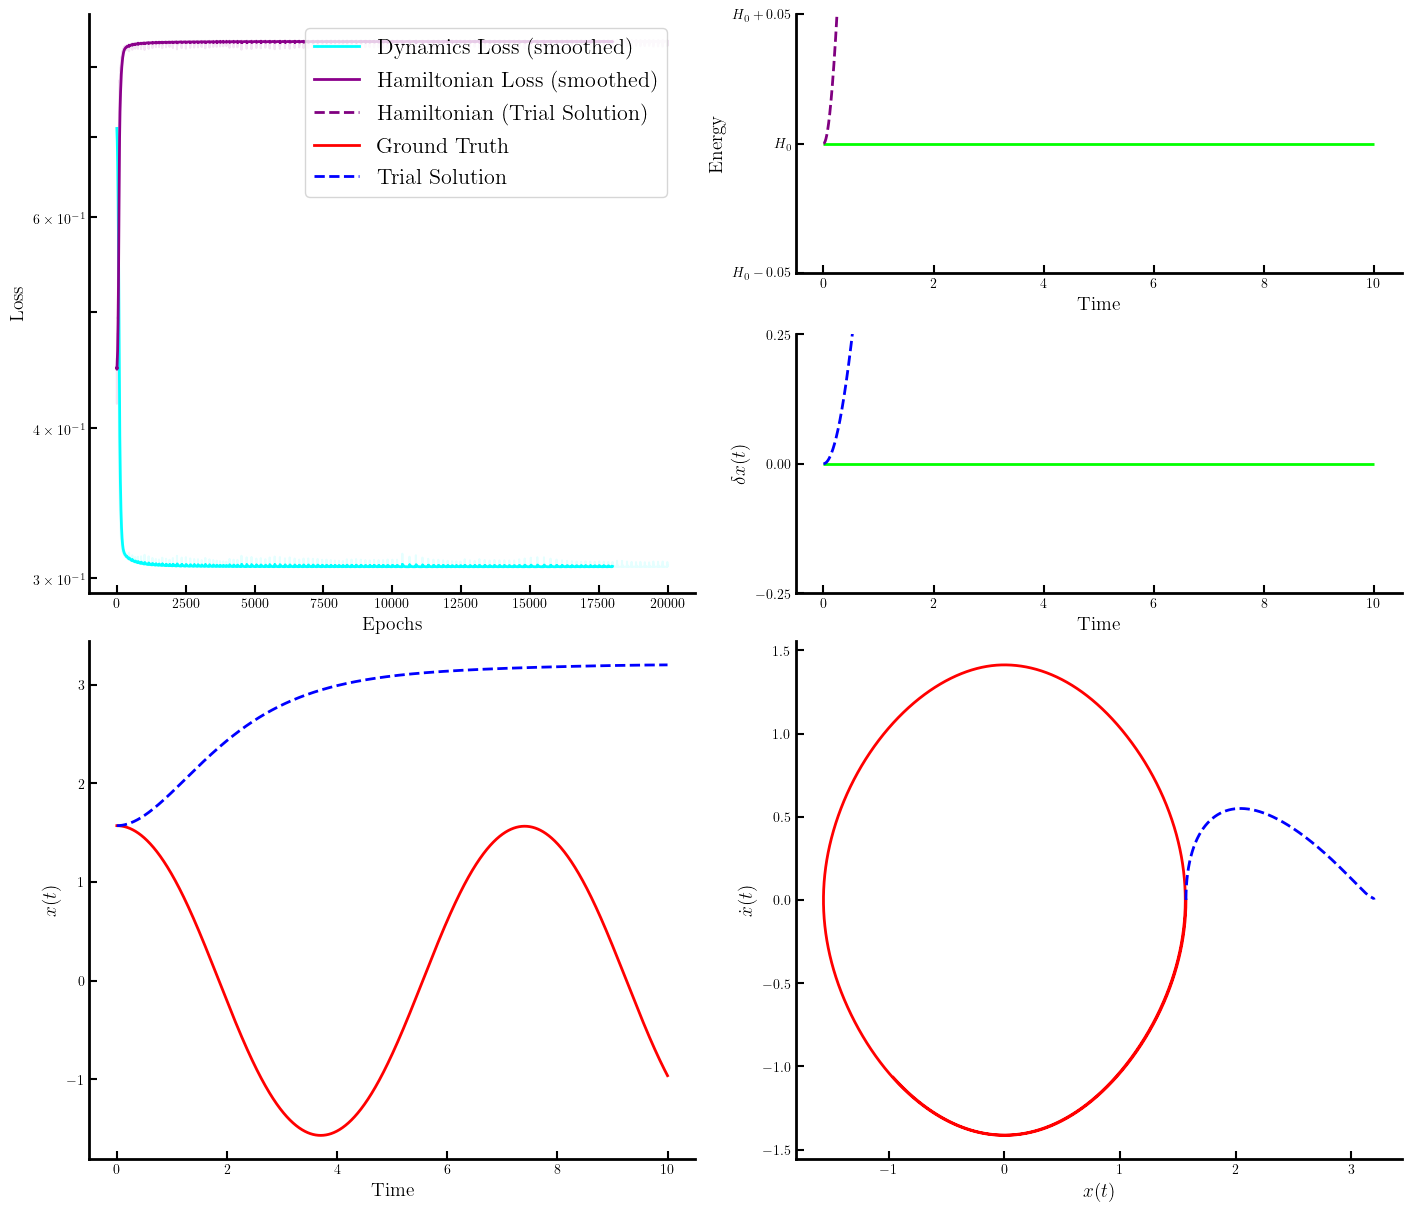

  0%|                                         | 2/20000 [00:00<36:23,  9.16it/s]

4492.818730401887


  1%|▏                                      | 102/20000 [00:10<32:23, 10.24it/s]

4130.229842179851


  1%|▍                                      | 202/20000 [00:20<32:36, 10.12it/s]

4120.1528285833065


  2%|▌                                      | 302/20000 [00:29<32:03, 10.24it/s]

4104.462722035072


  2%|▊                                      | 402/20000 [00:39<31:35, 10.34it/s]

4066.5225047873055


  3%|▉                                      | 501/20000 [00:49<32:58,  9.86it/s]

4053.8229195768217


  3%|█▏                                     | 602/20000 [00:59<31:01, 10.42it/s]

3962.96887986694


  4%|█▎                                     | 701/20000 [01:08<31:37, 10.17it/s]

3972.822349245484


  4%|█▌                                     | 802/20000 [01:18<32:48,  9.75it/s]

3938.0727573048325


  5%|█▊                                     | 901/20000 [01:28<30:42, 10.37it/s]

3925.9709482829335


  5%|█▉                                    | 1001/20000 [01:37<30:05, 10.52it/s]

3915.4653944856327


  6%|██                                    | 1102/20000 [01:47<30:08, 10.45it/s]

3905.3931276054373


  6%|██▎                                   | 1202/20000 [01:57<30:08, 10.40it/s]

3895.322438351391


  7%|██▍                                   | 1302/20000 [02:07<31:59,  9.74it/s]

127.83549436160811


  7%|██▋                                   | 1400/20000 [02:17<30:34, 10.14it/s]

54.14736622920146


  8%|██▊                                   | 1501/20000 [02:27<29:29, 10.45it/s]

46.92489374996797


  8%|███                                   | 1601/20000 [02:36<29:57, 10.24it/s]

40.85324163010088


  9%|███▏                                  | 1702/20000 [02:46<29:38, 10.29it/s]

35.69335855296168


  9%|███▍                                  | 1801/20000 [02:55<28:50, 10.52it/s]

31.27281660788877


 10%|███▌                                  | 1901/20000 [03:05<29:03, 10.38it/s]

27.46055107714885


 10%|███▊                                  | 2002/20000 [03:15<29:02, 10.33it/s]

24.154379370943804


 11%|███▉                                  | 2102/20000 [03:25<28:17, 10.54it/s]

21.27314870928669


 11%|████▏                                 | 2202/20000 [03:34<28:12, 10.51it/s]

18.751494926458093


 12%|████▎                                 | 2302/20000 [03:44<30:24,  9.70it/s]

16.536185890868968


 12%|████▌                                 | 2402/20000 [03:54<27:58, 10.48it/s]

14.583482092310028


 13%|████▊                                 | 2501/20000 [04:03<30:04,  9.70it/s]

12.857180483093543


 13%|████▉                                 | 2601/20000 [04:14<51:13,  5.66it/s]

11.327134206830449


 14%|█████▏                                | 2701/20000 [04:23<27:31, 10.48it/s]

9.968113329282867


 14%|█████▎                                | 2801/20000 [04:33<27:20, 10.48it/s]

8.758915288892862


 15%|█████▌                                | 2901/20000 [04:43<27:26, 10.38it/s]

7.68166116171443


 15%|█████▋                                | 3001/20000 [04:52<26:40, 10.62it/s]

6.721231666844419


 16%|█████▉                                | 3101/20000 [05:02<26:50, 10.49it/s]

5.864808829497543


 16%|██████                                | 3201/20000 [05:12<28:49,  9.71it/s]

5.101497533787853


 17%|██████▎                               | 3302/20000 [05:22<26:42, 10.42it/s]

4.422007174981486


 17%|██████▍                               | 3401/20000 [05:32<26:41, 10.37it/s]

3.818378145095223


 18%|██████▋                               | 3501/20000 [05:42<26:27, 10.39it/s]

3.2837415766356695


 18%|██████▊                               | 3602/20000 [05:51<25:52, 10.56it/s]

2.8121040748125443


 19%|███████                               | 3702/20000 [06:01<26:17, 10.33it/s]

2.398152388677984


 19%|███████▏                              | 3801/20000 [06:11<25:15, 10.69it/s]

2.0370762373772475


 20%|███████▍                              | 3902/20000 [06:20<27:04,  9.91it/s]

1.7244107358539182


 20%|███████▌                              | 4002/20000 [06:30<25:51, 10.31it/s]

1.4559027213455935


 21%|███████▊                              | 4102/20000 [06:40<25:36, 10.35it/s]

1.2274072248030536


 21%|███████▉                              | 4202/20000 [06:50<26:15, 10.02it/s]

1.049481090687211


 22%|████████▏                             | 4302/20000 [06:59<24:55, 10.50it/s]

0.8962715305996749


 22%|████████▎                             | 4402/20000 [07:09<25:05, 10.36it/s]

0.7682817210151331


 23%|████████▌                             | 4502/20000 [07:19<24:45, 10.44it/s]

0.685282060500558


 23%|████████▋                             | 4602/20000 [07:29<24:42, 10.38it/s]

0.5828419716279589


 24%|████████▉                             | 4701/20000 [07:39<24:05, 10.58it/s]

0.5113945940209952


 24%|█████████                             | 4802/20000 [07:49<24:09, 10.48it/s]

0.49445567702438387


 25%|█████████▎                            | 4902/20000 [07:58<24:24, 10.31it/s]

0.40667889497156334


 25%|█████████▌                            | 5001/20000 [08:08<23:47, 10.51it/s]

0.364993761671336


 26%|█████████▋                            | 5101/20000 [08:18<25:08,  9.88it/s]

0.3364046617663982


 26%|█████████▉                            | 5201/20000 [08:27<23:36, 10.45it/s]

0.300932846493006


 27%|██████████                            | 5301/20000 [08:37<23:30, 10.42it/s]

0.38926622426941426


 27%|██████████▎                           | 5401/20000 [08:46<22:52, 10.63it/s]

0.25168062695614685


 28%|██████████▍                           | 5502/20000 [08:56<22:39, 10.66it/s]

0.23102940168847846


 28%|██████████▋                           | 5600/20000 [09:05<22:24, 10.71it/s]

0.21867636688875638


 29%|██████████▊                           | 5701/20000 [09:15<22:29, 10.60it/s]

0.1959721100319511


 29%|███████████                           | 5802/20000 [09:25<22:29, 10.52it/s]

0.1806368616891417


 30%|███████████▏                          | 5902/20000 [09:34<22:07, 10.62it/s]

0.16673482644508206


 30%|███████████▍                          | 6002/20000 [09:44<23:29,  9.93it/s]

0.16137089457460352


 31%|███████████▌                          | 6102/20000 [09:54<21:47, 10.63it/s]

0.14224467101275792


 31%|███████████▊                          | 6201/20000 [10:03<23:43,  9.69it/s]

0.13153328135745262


 32%|███████████▉                          | 6301/20000 [10:13<21:59, 10.38it/s]

23.635581124763576


 32%|████████████▏                         | 6401/20000 [10:24<24:43,  9.17it/s]

0.11268887862625948


 33%|████████████▎                         | 6502/20000 [10:33<21:50, 10.30it/s]

0.10391299231875586


 33%|████████████▌                         | 6602/20000 [10:43<21:15, 10.50it/s]

0.09603295454149843


 34%|████████████▋                         | 6702/20000 [10:53<21:35, 10.26it/s]

0.1130166058361701


 34%|████████████▉                         | 6802/20000 [11:02<20:28, 10.74it/s]

0.08234521792750876


 35%|█████████████                         | 6902/20000 [11:12<20:56, 10.43it/s]

0.076079591848424


 35%|█████████████▎                        | 7001/20000 [11:22<21:07, 10.25it/s]

0.07026325433601135


 36%|█████████████▍                        | 7101/20000 [11:31<20:22, 10.56it/s]

2.187113003222415


 36%|█████████████▋                        | 7201/20000 [11:41<20:39, 10.33it/s]

0.06077422477363768


 37%|█████████████▊                        | 7302/20000 [11:51<20:30, 10.32it/s]

0.05596899697013898


 37%|██████████████                        | 7402/20000 [12:00<20:17, 10.34it/s]

0.05166743614256302


 38%|██████████████▎                       | 7501/20000 [12:10<20:00, 10.41it/s]

0.05520253129475739


 38%|██████████████▍                       | 7601/20000 [12:20<19:46, 10.45it/s]

0.04731393627184844


 39%|██████████████▋                       | 7702/20000 [12:30<19:29, 10.51it/s]

0.04158261929506319


 39%|██████████████▊                       | 7802/20000 [12:39<19:39, 10.34it/s]

0.038355507394257124


 40%|███████████████                       | 7902/20000 [12:49<21:08,  9.54it/s]

0.035370368769920335


 40%|███████████████▏                      | 8001/20000 [12:58<19:14, 10.40it/s]

1.9964045392939889


 41%|███████████████▍                      | 8102/20000 [13:08<19:25, 10.20it/s]

0.03154613307790873


 41%|███████████████▌                      | 8202/20000 [13:19<20:24,  9.64it/s]

0.028911488579646552


 42%|███████████████▊                      | 8302/20000 [13:28<19:25, 10.03it/s]

0.026663988459677167


 42%|███████████████▉                      | 8402/20000 [13:38<18:52, 10.24it/s]

0.024589156964190857


 43%|████████████████▏                     | 8501/20000 [13:48<18:20, 10.45it/s]

1.146655750958916


 43%|████████████████▎                     | 8601/20000 [13:57<18:32, 10.24it/s]

0.02247566953897296


 44%|████████████████▌                     | 8701/20000 [14:07<17:59, 10.47it/s]

0.020425906571616477


 44%|████████████████▋                     | 8801/20000 [14:17<18:09, 10.28it/s]

0.018820815075155938


 45%|████████████████▉                     | 8902/20000 [14:27<17:49, 10.37it/s]

0.017359936984068812


 45%|█████████████████                     | 9002/20000 [14:36<17:16, 10.61it/s]

4.37963712523386


 46%|█████████████████▎                    | 9102/20000 [14:46<17:14, 10.53it/s]

0.016576893276143645


 46%|█████████████████▍                    | 9201/20000 [14:55<17:04, 10.54it/s]

0.014703817293786454


 47%|█████████████████▋                    | 9301/20000 [15:05<17:12, 10.36it/s]

0.01351465098360951


 47%|█████████████████▊                    | 9402/20000 [15:15<18:15,  9.67it/s]

0.0124677675031017


 48%|██████████████████                    | 9501/20000 [15:25<16:37, 10.53it/s]

0.01149500050093611


 48%|██████████████████▏                   | 9602/20000 [15:34<16:38, 10.41it/s]

0.040616141024354756


 49%|██████████████████▍                   | 9702/20000 [15:44<17:19,  9.90it/s]

0.010921082952116955


 49%|██████████████████▌                   | 9802/20000 [15:54<16:03, 10.58it/s]

0.009942194946612415


 50%|██████████████████▊                   | 9902/20000 [16:04<17:42,  9.50it/s]

0.009159751420402071


 50%|██████████████████▌                  | 10001/20000 [16:13<16:01, 10.40it/s]

0.008451773289482866


 51%|██████████████████▋                  | 10101/20000 [16:23<15:43, 10.50it/s]

0.6806748947381569


 51%|██████████████████▊                  | 10201/20000 [16:32<15:37, 10.45it/s]

0.010050722645703534


 52%|███████████████████                  | 10302/20000 [16:42<16:26,  9.83it/s]

0.007630718229123326


 52%|███████████████████▏                 | 10402/20000 [16:52<15:22, 10.40it/s]

0.006979522226768768


 53%|███████████████████▍                 | 10502/20000 [17:01<14:57, 10.59it/s]

0.006437213251859673


 53%|███████████████████▌                 | 10602/20000 [17:11<15:01, 10.43it/s]

0.005944122617308238


 54%|███████████████████▊                 | 10702/20000 [17:21<14:38, 10.58it/s]

21.17642468624188


 54%|███████████████████▉                 | 10802/20000 [17:31<14:48, 10.35it/s]

0.007307579569288866


 55%|████████████████████▏                | 10902/20000 [17:40<14:24, 10.52it/s]

0.005663437613334405


 55%|████████████████████▎                | 11002/20000 [17:50<14:34, 10.30it/s]

0.0051859667201117135


 56%|████████████████████▌                | 11102/20000 [18:00<14:24, 10.30it/s]

0.004791149434887243


 56%|████████████████████▋                | 11201/20000 [18:09<14:10, 10.35it/s]

0.0044340748689586105


 57%|████████████████████▉                | 11302/20000 [18:19<13:50, 10.47it/s]

0.004104079460242732


 57%|█████████████████████                | 11402/20000 [18:29<13:46, 10.40it/s]

0.03988981361704521


 58%|█████████████████████▎               | 11502/20000 [18:39<13:24, 10.56it/s]

0.004489323385678962


 58%|█████████████████████▍               | 11602/20000 [18:48<14:46,  9.47it/s]

0.004082756116190951


 59%|█████████████████████▋               | 11701/20000 [18:58<13:12, 10.47it/s]

0.0037735558676785267


 59%|█████████████████████▊               | 11801/20000 [19:08<13:31, 10.11it/s]

0.0034989364886993516


 60%|██████████████████████               | 11902/20000 [19:19<13:11, 10.23it/s]

0.003246842143850594


 60%|██████████████████████▏              | 12001/20000 [19:28<12:38, 10.54it/s]

1.2317772642420093


 61%|██████████████████████▍              | 12101/20000 [19:38<12:24, 10.61it/s]

0.004781626574159348


 61%|██████████████████████▌              | 12201/20000 [19:47<12:35, 10.32it/s]

0.003442770798393508


 62%|██████████████████████▊              | 12301/20000 [19:57<12:09, 10.55it/s]

0.003172224326255735


 62%|██████████████████████▉              | 12401/20000 [20:07<12:29, 10.13it/s]

0.002942054525117677


 63%|███████████████████████▏             | 12501/20000 [20:16<11:56, 10.46it/s]

0.0027328341432036082


 63%|███████████████████████▎             | 12602/20000 [20:26<11:53, 10.37it/s]

0.002539823916392358


 64%|███████████████████████▍             | 12702/20000 [20:35<11:34, 10.51it/s]

2.6047424387062996


 64%|███████████████████████▋             | 12802/20000 [20:45<11:30, 10.42it/s]

0.0033792547768359605


 65%|███████████████████████▊             | 12901/20000 [20:55<11:27, 10.33it/s]

0.0028289434316990983


 65%|████████████████████████             | 13001/20000 [21:04<11:04, 10.53it/s]

0.0026152729260209002


 66%|████████████████████████▏            | 13101/20000 [21:14<11:00, 10.45it/s]

0.0024260490927577355


 66%|████████████████████████▍            | 13202/20000 [21:24<11:04, 10.24it/s]

0.002252723835574405


 67%|████████████████████████▌            | 13302/20000 [21:33<10:50, 10.30it/s]

0.0020929063226371074


 67%|████████████████████████▊            | 13402/20000 [21:43<10:29, 10.49it/s]

1.2159302448585358


 68%|████████████████████████▉            | 13501/20000 [21:52<10:25, 10.38it/s]

0.002772848728579592


 68%|█████████████████████████▏           | 13601/20000 [22:02<10:10, 10.49it/s]

0.00241623350263403


 69%|█████████████████████████▎           | 13701/20000 [22:12<09:56, 10.56it/s]

0.002236323177129761


 69%|█████████████████████████▌           | 13801/20000 [22:21<09:56, 10.39it/s]

0.002072755737539052


 70%|█████████████████████████▋           | 13901/20000 [22:31<09:41, 10.48it/s]

0.00192218108457857


 70%|█████████████████████████▉           | 14001/20000 [22:41<09:39, 10.35it/s]

0.0017836013694662567


 71%|██████████████████████████           | 14102/20000 [22:51<09:20, 10.52it/s]

0.12980218462748222


 71%|██████████████████████████▎          | 14202/20000 [23:01<09:05, 10.62it/s]

0.002523898940885362


 72%|██████████████████████████▍          | 14302/20000 [23:10<09:05, 10.45it/s]

0.002053647090062897


 72%|██████████████████████████▋          | 14402/20000 [23:20<09:05, 10.27it/s]

0.0018950563339826124


 73%|██████████████████████████▊          | 14502/20000 [23:29<08:41, 10.54it/s]

0.0017509247498588233


 73%|███████████████████████████          | 14602/20000 [23:39<08:37, 10.44it/s]

0.0016191696959353564


 74%|███████████████████████████▏         | 14702/20000 [23:49<08:21, 10.57it/s]

0.0014990314256012015


 74%|███████████████████████████▍         | 14802/20000 [23:58<08:19, 10.41it/s]

0.21173599442091778


 75%|███████████████████████████▌         | 14901/20000 [24:08<08:12, 10.36it/s]

0.0031937736392879225


 75%|███████████████████████████▊         | 15002/20000 [24:18<08:29,  9.80it/s]

0.001678490483205266


 76%|███████████████████████████▉         | 15102/20000 [24:27<07:42, 10.60it/s]

0.001544924047291568


 76%|████████████████████████████         | 15202/20000 [24:37<07:30, 10.64it/s]

0.0014236175783479826


 77%|████████████████████████████▎        | 15302/20000 [24:46<07:28, 10.48it/s]

0.0013137041523442338


 77%|████████████████████████████▍        | 15402/20000 [24:56<07:22, 10.40it/s]

0.0012146156243471801


 78%|████████████████████████████▋        | 15502/20000 [25:05<07:03, 10.61it/s]

0.0011257927125197882


 78%|████████████████████████████▊        | 15602/20000 [25:15<07:15, 10.11it/s]

0.014334408574270305


 79%|█████████████████████████████        | 15701/20000 [25:25<06:51, 10.46it/s]

0.0013225526237048855


 79%|█████████████████████████████▏       | 15801/20000 [25:34<06:40, 10.48it/s]

0.0012152559550078854


 80%|█████████████████████████████▍       | 15902/20000 [25:45<06:57,  9.82it/s]

0.0011189011633334807


 80%|█████████████████████████████▌       | 16002/20000 [25:55<06:33, 10.15it/s]

0.0010324576077100662


 81%|█████████████████████████████▊       | 16101/20000 [26:04<06:18, 10.29it/s]

0.0009553523014030659


 81%|█████████████████████████████▉       | 16201/20000 [26:14<06:03, 10.46it/s]

0.0008869799325481054


 82%|██████████████████████████████▏      | 16302/20000 [26:24<05:54, 10.43it/s]

4.0833454621553305


 82%|██████████████████████████████▎      | 16402/20000 [26:33<05:40, 10.57it/s]

0.0011570473897825056


 83%|██████████████████████████████▌      | 16502/20000 [26:43<05:34, 10.46it/s]

0.0009633732051478169


 83%|██████████████████████████████▋      | 16602/20000 [26:53<05:28, 10.34it/s]

0.0008861171949895444


 84%|██████████████████████████████▉      | 16702/20000 [27:02<05:18, 10.35it/s]

0.0008177157663600569


 84%|███████████████████████████████      | 16802/20000 [27:12<05:04, 10.51it/s]

0.0007574089016301394


 85%|███████████████████████████████▎     | 16901/20000 [27:22<04:54, 10.51it/s]

0.0007045407383574563


 85%|███████████████████████████████▍     | 17002/20000 [27:32<04:45, 10.49it/s]

1.404632177474742


 86%|███████████████████████████████▋     | 17102/20000 [27:42<04:30, 10.72it/s]

0.001026032530527818


 86%|███████████████████████████████▊     | 17202/20000 [27:51<04:24, 10.56it/s]

0.0007743799534104685


 87%|████████████████████████████████     | 17302/20000 [28:01<04:16, 10.52it/s]

0.0007117884762867349


 87%|████████████████████████████████▏    | 17401/20000 [28:10<04:06, 10.54it/s]

0.0006570332875009679


 88%|████████████████████████████████▍    | 17502/20000 [28:21<04:01, 10.34it/s]

0.0006092874629314615


 88%|████████████████████████████████▌    | 17602/20000 [28:30<04:16,  9.36it/s]

0.0005678871768477147


 89%|████████████████████████████████▋    | 17701/20000 [28:40<03:41, 10.40it/s]

0.06393907767966173


 89%|████████████████████████████████▉    | 17801/20000 [28:50<03:30, 10.47it/s]

0.0008874313354588462


 90%|█████████████████████████████████    | 17901/20000 [29:00<03:21, 10.40it/s]

0.0006469494795272627


 90%|█████████████████████████████████▎   | 18001/20000 [29:09<03:12, 10.40it/s]

0.0005934278055663217


 91%|█████████████████████████████████▍   | 18101/20000 [29:19<03:00, 10.53it/s]

0.0005467735497236942


 91%|█████████████████████████████████▋   | 18201/20000 [29:29<02:52, 10.43it/s]

0.0005063288146596302


 92%|█████████████████████████████████▊   | 18301/20000 [29:39<02:45, 10.27it/s]

0.00047147524455604307


 92%|██████████████████████████████████   | 18402/20000 [29:49<02:46,  9.58it/s]

0.0004420962159795484


 93%|██████████████████████████████████▏  | 18502/20000 [30:00<02:38,  9.46it/s]

0.0027724391839469135


 93%|██████████████████████████████████▍  | 18601/20000 [30:10<02:17, 10.18it/s]

0.0005445539513673611


 94%|██████████████████████████████████▌  | 18702/20000 [30:20<02:22,  9.11it/s]

0.0004969192486294092


 94%|██████████████████████████████████▊  | 18802/20000 [30:30<01:55, 10.36it/s]

0.00045589948981820234


 95%|██████████████████████████████████▉  | 18902/20000 [30:40<01:46, 10.29it/s]

0.0004206386828759292


 95%|███████████████████████████████████▏ | 19001/20000 [30:49<01:35, 10.46it/s]

0.00039051019721354725


 96%|███████████████████████████████████▎ | 19101/20000 [30:59<01:25, 10.48it/s]

0.00036491355197768705


 96%|███████████████████████████████████▌ | 19201/20000 [31:09<01:17, 10.34it/s]

0.011398078924442959


 97%|███████████████████████████████████▋ | 19301/20000 [31:18<01:08, 10.19it/s]

0.0004381572528191017


 97%|███████████████████████████████████▉ | 19402/20000 [31:29<00:56, 10.63it/s]

0.0003985340926932878


 98%|████████████████████████████████████ | 19502/20000 [31:38<00:46, 10.69it/s]

0.00036531161767052475


 98%|████████████████████████████████████▎| 19602/20000 [31:48<00:37, 10.57it/s]

0.0003369937699260287


 99%|████████████████████████████████████▍| 19702/20000 [31:57<00:28, 10.54it/s]

0.00031298790573177433


 99%|████████████████████████████████████▋| 19802/20000 [32:07<00:19,  9.95it/s]

0.0002927553970167722


100%|████████████████████████████████████▊| 19902/20000 [32:17<00:10,  9.39it/s]

0.26766524606816755


100%|█████████████████████████████████████| 20000/20000 [32:27<00:00, 10.27it/s]


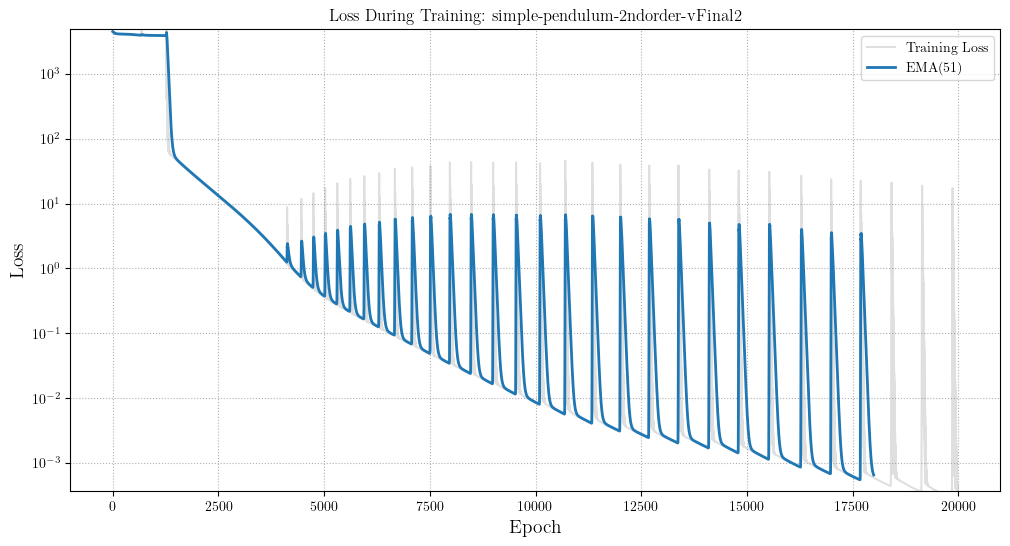

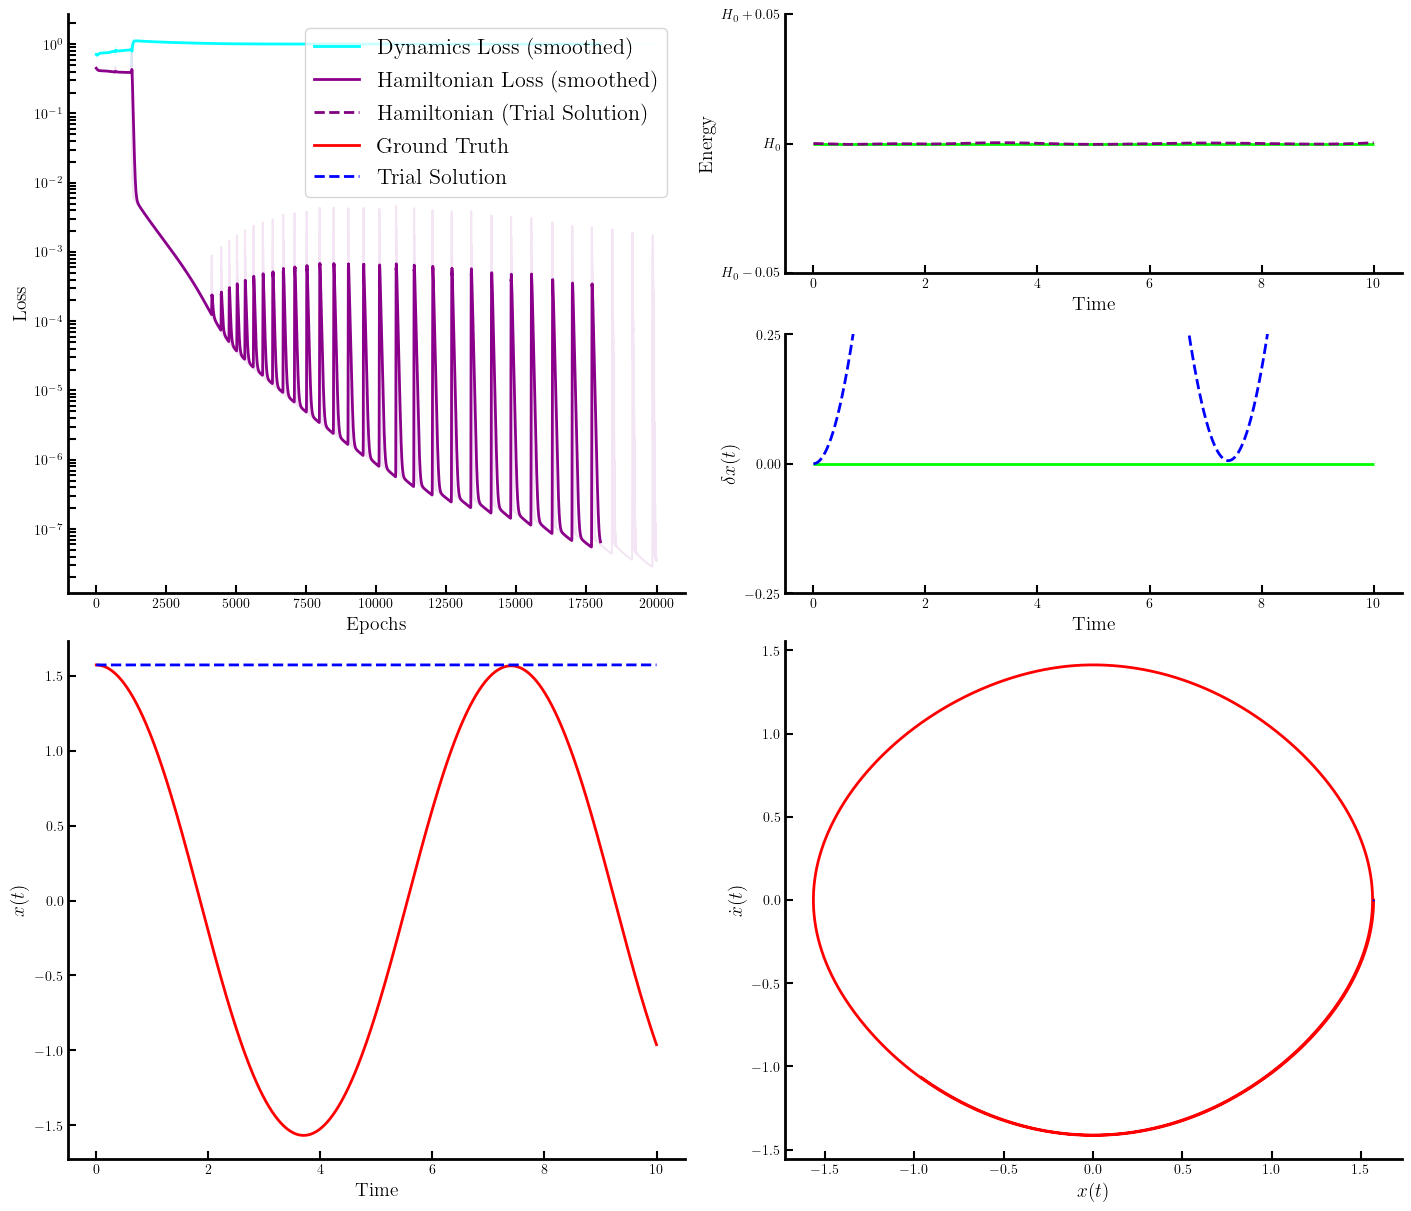

  0%|                                         | 1/20000 [00:00<42:15,  7.89it/s]

11589.741929947962


  1%|▏                                      | 102/20000 [00:11<35:14,  9.41it/s]

8551.624768737887


  1%|▍                                      | 202/20000 [00:21<35:12,  9.37it/s]

7863.481561365087


  2%|▌                                      | 302/20000 [00:32<35:43,  9.19it/s]

7438.80724552811


  2%|▊                                      | 402/20000 [00:43<35:44,  9.14it/s]

4566.939837287036


  3%|▉                                      | 502/20000 [00:54<35:17,  9.21it/s]

4420.233300776734


  3%|█▏                                     | 602/20000 [01:05<35:29,  9.11it/s]

4352.549574306327


  4%|█▎                                     | 702/20000 [01:16<36:49,  8.73it/s]

4288.9939981066145


  4%|█▌                                     | 802/20000 [01:27<34:42,  9.22it/s]

4223.379393827197


  5%|█▊                                     | 902/20000 [01:38<35:06,  9.07it/s]

4152.071215907721


  5%|█▉                                    | 1002/20000 [01:50<34:45,  9.11it/s]

4076.9626068813823


  6%|██                                    | 1102/20000 [02:01<34:10,  9.22it/s]

3993.4610993821566


  6%|██▎                                   | 1202/20000 [02:12<34:31,  9.07it/s]

3893.6956064736682


  7%|██▍                                   | 1302/20000 [02:24<33:23,  9.33it/s]

3785.2037211828356


  7%|██▋                                   | 1402/20000 [02:35<34:22,  9.02it/s]

3659.187744576853


  8%|██▊                                   | 1502/20000 [02:46<34:39,  8.89it/s]

3522.2448770036954


  8%|███                                   | 1602/20000 [02:57<32:33,  9.42it/s]

3385.765050138657


  9%|███▏                                  | 1702/20000 [03:08<33:30,  9.10it/s]

3274.3671538165895


  9%|███▍                                  | 1802/20000 [03:19<33:03,  9.18it/s]

3193.825193320122


 10%|███▍                                | 1901/20000 [03:30<1:06:52,  4.51it/s]

3128.5247357683197


 10%|███▊                                  | 2002/20000 [03:42<32:29,  9.23it/s]

2668.599731404411


 11%|███▉                                  | 2102/20000 [03:53<32:38,  9.14it/s]

1363.8145237523072


 11%|████▏                                 | 2202/20000 [04:04<31:52,  9.31it/s]

887.664974010948


 12%|████▎                                 | 2302/20000 [04:14<32:05,  9.19it/s]

807.3732002590548


 12%|████▌                                 | 2402/20000 [04:25<31:32,  9.30it/s]

759.7692745865895


 13%|████▊                                 | 2502/20000 [04:36<32:09,  9.07it/s]

729.456524696147


 13%|████▉                                 | 2601/20000 [04:48<37:56,  7.64it/s]

771.0000176295133


 14%|█████▏                                | 2702/20000 [04:59<32:25,  8.89it/s]

696.9874033324402


 14%|█████▎                                | 2802/20000 [05:10<31:33,  9.08it/s]

685.9613037354981


 15%|█████▌                                | 2902/20000 [05:21<30:19,  9.39it/s]

676.6634694713182


 15%|█████▋                                | 3002/20000 [05:32<30:49,  9.19it/s]

670.5042469927878


 16%|█████▉                                | 3102/20000 [05:44<30:26,  9.25it/s]

666.9172258875617


 16%|██████                                | 3202/20000 [05:55<30:41,  9.12it/s]

654.8537866100367


 17%|██████▎                               | 3302/20000 [06:06<30:52,  9.01it/s]

660.5099147916874


 17%|██████▍                               | 3402/20000 [06:17<31:31,  8.78it/s]

634.5179438667135


 18%|██████▋                               | 3502/20000 [06:28<30:00,  9.16it/s]

631.1973875810012


 18%|██████▊                               | 3602/20000 [06:40<29:54,  9.14it/s]

619.166842428174


 19%|███████                               | 3702/20000 [06:51<29:34,  9.19it/s]

613.7070358612692


 19%|███████▏                              | 3802/20000 [07:02<30:34,  8.83it/s]

604.0745151219605


 20%|███████▍                              | 3902/20000 [07:14<30:02,  8.93it/s]

597.7765962582378


 20%|███████▌                              | 4002/20000 [07:25<29:13,  9.12it/s]

591.0450015596293


 21%|███████▊                              | 4102/20000 [07:36<29:54,  8.86it/s]

631.0452502798851


 21%|███████▉                              | 4202/20000 [07:47<28:44,  9.16it/s]

616.1042146168246


 22%|████████▏                             | 4302/20000 [07:58<28:36,  9.15it/s]

568.1394174322538


 22%|████████▎                             | 4402/20000 [08:09<28:45,  9.04it/s]

560.9030408489731


 23%|████████▌                             | 4502/20000 [08:20<29:48,  8.66it/s]

560.4019093989593


 23%|████████▋                             | 4602/20000 [08:31<28:30,  9.00it/s]

565.7425011117632


 24%|████████▉                             | 4702/20000 [08:42<28:17,  9.01it/s]

612.4394607763425


 24%|█████████                             | 4802/20000 [08:54<27:36,  9.18it/s]

533.8530965254482


 25%|█████████▎                            | 4902/20000 [09:05<27:15,  9.23it/s]

525.6969737026731


 25%|█████████▌                            | 5002/20000 [09:16<28:06,  8.90it/s]

519.2186968744589


 26%|█████████▋                            | 5102/20000 [09:27<27:18,  9.09it/s]

512.366025997168


 26%|█████████▉                            | 5202/20000 [09:38<27:47,  8.88it/s]

562.3065578770161


 27%|██████████                            | 5302/20000 [09:49<27:56,  8.77it/s]

499.89233961721385


 27%|██████████▎                           | 5402/20000 [10:00<26:20,  9.24it/s]

509.17545717520477


 28%|██████████▍                           | 5502/20000 [10:11<26:16,  9.19it/s]

485.7744111230919


 28%|██████████▋                           | 5602/20000 [10:22<27:13,  8.81it/s]

479.90553851580034


 29%|██████████▊                           | 5702/20000 [10:33<25:52,  9.21it/s]

479.218100236688


 29%|███████████                           | 5802/20000 [10:44<25:15,  9.37it/s]

475.1261233468979


 30%|███████████▏                          | 5902/20000 [10:55<24:36,  9.55it/s]

630.1788817481735


 30%|███████████▍                          | 6002/20000 [11:06<24:54,  9.37it/s]

492.9535799282606


 31%|███████████▌                          | 6102/20000 [11:17<25:38,  9.04it/s]

450.624594132836


 31%|███████████▊                          | 6202/20000 [11:28<24:36,  9.34it/s]

444.30430394752625


 32%|███████████▉                          | 6302/20000 [11:39<25:41,  8.89it/s]

562.9062451199666


 32%|████████████▏                         | 6402/20000 [11:50<25:14,  8.98it/s]

480.0092956804021


 33%|████████████▎                         | 6502/20000 [12:01<24:36,  9.14it/s]

427.08377172049865


 33%|████████████▌                         | 6602/20000 [12:13<25:52,  8.63it/s]

480.4315567323797


 34%|████████████▋                         | 6702/20000 [12:24<24:27,  9.06it/s]

416.4882918770177


 34%|████████████▉                         | 6802/20000 [12:34<23:36,  9.32it/s]

408.79195575199185


 35%|█████████████                         | 6902/20000 [12:45<23:47,  9.18it/s]

414.49618751750904


 35%|█████████████▎                        | 7002/20000 [12:56<23:37,  9.17it/s]

401.30313845767284


 36%|█████████████▍                        | 7102/20000 [13:07<23:28,  9.16it/s]

440.83300734384494


 36%|█████████████▋                        | 7202/20000 [13:19<23:20,  9.14it/s]

394.4056909010984


 37%|█████████████▊                        | 7302/20000 [13:30<23:25,  9.04it/s]

432.590706202823


 37%|██████████████                        | 7402/20000 [13:41<23:50,  8.81it/s]

380.59460986179306


 38%|██████████████▎                       | 7502/20000 [13:52<22:24,  9.30it/s]

372.6711036041832


 38%|██████████████▍                       | 7602/20000 [14:03<22:12,  9.31it/s]

376.6685567552031


 39%|██████████████▋                       | 7702/20000 [14:14<24:00,  8.54it/s]

440.32346761880956


 39%|██████████████▊                       | 7802/20000 [14:26<24:40,  8.24it/s]

361.88506035435034


 40%|███████████████                       | 7901/20000 [14:37<24:36,  8.19it/s]

375.47997273425256


 40%|███████████████▏                      | 8002/20000 [14:49<23:48,  8.40it/s]

355.9657195503167


 41%|███████████████▍                      | 8102/20000 [15:00<21:46,  9.11it/s]

349.50221673418736


 41%|███████████████▌                      | 8202/20000 [15:11<21:26,  9.17it/s]

446.8709841217511


 42%|███████████████▊                      | 8302/20000 [15:23<21:39,  9.00it/s]

423.73101059254907


 42%|███████████████▉                      | 8402/20000 [15:34<20:54,  9.25it/s]

404.07495545873746


 43%|████████████████▏                     | 8502/20000 [15:45<21:27,  8.93it/s]

329.37015222089093


 43%|████████████████▎                     | 8602/20000 [15:56<20:25,  9.30it/s]

325.11594422651876


 44%|████████████████▌                     | 8702/20000 [16:07<20:05,  9.37it/s]

320.7255065737892


 44%|████████████████▋                     | 8802/20000 [16:17<20:17,  9.20it/s]

332.53649652074364


 45%|████████████████▉                     | 8902/20000 [16:28<19:55,  9.28it/s]

313.18291596819654


 45%|█████████████████                     | 9002/20000 [16:40<19:43,  9.29it/s]

326.56899896936454


 46%|█████████████████▎                    | 9102/20000 [16:51<20:02,  9.06it/s]

306.35658763580807


 46%|█████████████████▍                    | 9202/20000 [17:02<19:48,  9.08it/s]

474.03839277793065


 47%|█████████████████▋                    | 9302/20000 [17:13<19:40,  9.06it/s]

328.49957914843765


 47%|█████████████████▊                    | 9402/20000 [17:25<19:47,  8.93it/s]

319.01344915664623


 48%|██████████████████                    | 9502/20000 [17:36<19:15,  9.09it/s]

314.7311190187947


 48%|██████████████████▏                   | 9602/20000 [17:47<18:30,  9.36it/s]

344.5222282923387


 49%|██████████████████▍                   | 9702/20000 [17:59<19:02,  9.01it/s]

329.35045451294997


 49%|██████████████████▌                   | 9802/20000 [18:10<18:43,  9.07it/s]

299.3138812962789


 50%|██████████████████▊                   | 9902/20000 [18:21<18:11,  9.25it/s]

285.59844457965016


 50%|██████████████████▌                  | 10002/20000 [18:33<18:14,  9.13it/s]

277.37901080316345


 51%|██████████████████▋                  | 10102/20000 [18:44<17:39,  9.34it/s]

455.1831342519047


 51%|██████████████████▊                  | 10202/20000 [18:55<17:40,  9.24it/s]

526.6206221809862


 52%|███████████████████                  | 10302/20000 [19:06<17:55,  9.02it/s]

267.3842757468407


 52%|███████████████████▏                 | 10402/20000 [19:17<17:44,  9.01it/s]

297.2014495473202


 53%|███████████████████▍                 | 10502/20000 [19:28<16:54,  9.36it/s]

326.3884563165792


 53%|███████████████████▌                 | 10602/20000 [19:39<16:47,  9.32it/s]

265.43457584603107


 54%|███████████████████▊                 | 10702/20000 [19:50<16:44,  9.25it/s]

322.6883572003767


 54%|███████████████████▉                 | 10802/20000 [20:01<16:17,  9.41it/s]

292.7791021599887


 55%|████████████████████▏                | 10902/20000 [20:12<16:37,  9.12it/s]

291.1542062434104


 55%|████████████████████▎                | 11002/20000 [20:23<16:25,  9.13it/s]

289.8941171972149


 56%|████████████████████▌                | 11102/20000 [20:34<16:00,  9.27it/s]

260.5782431853051


 56%|████████████████████▋                | 11202/20000 [20:45<15:44,  9.31it/s]

240.97186400105284


 57%|████████████████████▉                | 11302/20000 [20:56<15:23,  9.42it/s]

318.63232599135284


 57%|█████████████████████                | 11402/20000 [21:06<15:41,  9.13it/s]

306.9083926213112


 58%|█████████████████████▎               | 11502/20000 [21:17<15:32,  9.11it/s]

241.26334971300838


 58%|█████████████████████▍               | 11602/20000 [21:28<14:55,  9.37it/s]

291.8961185928421


 59%|█████████████████████▋               | 11702/20000 [21:39<15:04,  9.17it/s]

269.9894384293779


 59%|█████████████████████▊               | 11802/20000 [21:50<14:29,  9.43it/s]

333.2359427739163


 60%|██████████████████████               | 11902/20000 [22:01<14:38,  9.22it/s]

275.90152379227635


 60%|██████████████████████▏              | 12002/20000 [22:12<14:42,  9.06it/s]

280.67308536765927


 61%|██████████████████████▍              | 12102/20000 [22:23<14:33,  9.05it/s]

240.57438017072923


 61%|██████████████████████▌              | 12202/20000 [22:35<14:17,  9.10it/s]

278.12889672146287


 62%|██████████████████████▊              | 12302/20000 [22:46<13:49,  9.28it/s]

216.04953301062164


 62%|██████████████████████▉              | 12402/20000 [22:57<13:55,  9.09it/s]

241.04604147621717


 63%|███████████████████████▏             | 12502/20000 [23:08<13:30,  9.25it/s]

325.88468866703204


 63%|███████████████████████▎             | 12602/20000 [23:19<13:33,  9.09it/s]

256.5760018189333


 64%|███████████████████████▍             | 12702/20000 [23:30<13:16,  9.16it/s]

282.82557495868525


 64%|███████████████████████▋             | 12802/20000 [23:41<13:21,  8.98it/s]

206.83656150485817


 65%|███████████████████████▊             | 12902/20000 [23:52<13:07,  9.01it/s]

246.4983008071986


 65%|████████████████████████             | 13002/20000 [24:03<12:51,  9.07it/s]

210.07349742960292


 66%|████████████████████████▏            | 13102/20000 [24:14<12:29,  9.21it/s]

321.1693271313288


 66%|████████████████████████▍            | 13202/20000 [24:25<12:38,  8.96it/s]

201.77557972054012


 67%|████████████████████████▌            | 13302/20000 [24:36<12:07,  9.21it/s]

202.4655237194262


 67%|████████████████████████▊            | 13402/20000 [24:47<12:16,  8.96it/s]

227.4235572098201


 68%|████████████████████████▉            | 13502/20000 [24:59<12:56,  8.37it/s]

245.38170918018187


 68%|█████████████████████████▏           | 13602/20000 [25:10<11:08,  9.57it/s]

211.1047309876114


 69%|█████████████████████████▎           | 13702/20000 [25:21<11:27,  9.16it/s]

194.91004089070225


 69%|█████████████████████████▌           | 13802/20000 [25:32<11:12,  9.21it/s]

247.61265273396705


 70%|█████████████████████████▋           | 13902/20000 [25:43<11:13,  9.05it/s]

268.0312759496545


 70%|█████████████████████████▉           | 14002/20000 [25:54<11:00,  9.09it/s]

217.88663401354074


 71%|██████████████████████████           | 14102/20000 [26:05<10:57,  8.97it/s]

185.31923484031773


 71%|██████████████████████████▎          | 14202/20000 [26:17<11:03,  8.74it/s]

311.81823010968435


 72%|██████████████████████████▍          | 14302/20000 [26:28<10:32,  9.01it/s]

243.48479293184764


 72%|██████████████████████████▋          | 14402/20000 [26:39<10:25,  8.94it/s]

187.54992043595098


 73%|██████████████████████████▊          | 14502/20000 [26:51<10:12,  8.97it/s]

231.24519537781796


 73%|███████████████████████████          | 14602/20000 [27:02<10:10,  8.84it/s]

239.15162031537034


 74%|███████████████████████████▏         | 14702/20000 [27:14<09:38,  9.16it/s]

179.95314258771722


 74%|███████████████████████████▍         | 14802/20000 [27:25<09:48,  8.84it/s]

193.6761696658661


 75%|███████████████████████████▌         | 14902/20000 [27:36<09:07,  9.32it/s]

272.8691492997005


 75%|███████████████████████████▊         | 15002/20000 [27:47<09:17,  8.97it/s]

301.3651543805295


 76%|███████████████████████████▉         | 15102/20000 [27:58<09:02,  9.03it/s]

181.24475480906017


 76%|████████████████████████████         | 15202/20000 [28:09<08:42,  9.18it/s]

281.7092730774914


 77%|████████████████████████████▎        | 15302/20000 [28:20<08:27,  9.25it/s]

174.70605627181794


 77%|████████████████████████████▍        | 15402/20000 [28:31<08:09,  9.40it/s]

261.8425875377969


 78%|████████████████████████████▋        | 15502/20000 [28:42<08:04,  9.28it/s]

169.67463098261828


 78%|████████████████████████████▊        | 15602/20000 [28:53<08:08,  8.99it/s]

289.5673653485924


 79%|█████████████████████████████        | 15702/20000 [29:04<08:13,  8.71it/s]

192.53046822587334


 79%|█████████████████████████████▏       | 15801/20000 [29:15<07:42,  9.07it/s]

232.23010453600295


 80%|█████████████████████████████▍       | 15902/20000 [29:26<07:39,  8.92it/s]

259.96735453482694


 80%|█████████████████████████████▌       | 16002/20000 [29:38<07:53,  8.44it/s]

189.4039604910228


 81%|█████████████████████████████▊       | 16101/20000 [29:49<07:49,  8.30it/s]

185.26904498613993


 81%|█████████████████████████████▉       | 16202/20000 [30:02<06:55,  9.14it/s]

287.51678765150075


 82%|██████████████████████████████▏      | 16302/20000 [30:13<06:46,  9.11it/s]

260.53865531243207


 82%|██████████████████████████████▎      | 16402/20000 [30:24<06:29,  9.24it/s]

213.64812110316223


 83%|██████████████████████████████▌      | 16502/20000 [30:35<06:28,  9.00it/s]

174.23328972328886


 83%|██████████████████████████████▋      | 16602/20000 [30:46<06:19,  8.97it/s]

159.1631528310197


 84%|██████████████████████████████▉      | 16702/20000 [30:57<06:09,  8.92it/s]

177.76519628313412


 84%|███████████████████████████████      | 16802/20000 [31:08<05:56,  8.97it/s]

205.5991281615706


 85%|███████████████████████████████▎     | 16902/20000 [31:19<05:32,  9.30it/s]

223.07104257493938


 85%|███████████████████████████████▍     | 17002/20000 [31:30<05:34,  8.96it/s]

226.28071216943889


 86%|███████████████████████████████▋     | 17102/20000 [31:42<05:16,  9.15it/s]

215.18368907791438


 86%|███████████████████████████████▊     | 17202/20000 [31:53<05:07,  9.11it/s]

189.8725178925799


 87%|████████████████████████████████     | 17302/20000 [32:04<04:54,  9.15it/s]

160.45825240944114


 87%|████████████████████████████████▏    | 17402/20000 [32:15<04:43,  9.15it/s]

155.45218666863443


 88%|████████████████████████████████▍    | 17502/20000 [32:27<04:33,  9.14it/s]

187.98314707519208


 88%|████████████████████████████████▌    | 17602/20000 [32:38<04:38,  8.60it/s]

235.93841768466


 89%|████████████████████████████████▋    | 17702/20000 [32:49<04:25,  8.66it/s]

281.0573220168513


 89%|████████████████████████████████▉    | 17802/20000 [33:00<04:02,  9.06it/s]

197.1847048229471


 90%|█████████████████████████████████    | 17902/20000 [33:11<03:54,  8.95it/s]

165.9283768594508


 90%|█████████████████████████████████▎   | 18002/20000 [33:22<03:42,  8.99it/s]

247.02439096575137


 91%|█████████████████████████████████▍   | 18102/20000 [33:33<03:27,  9.16it/s]

200.19192039519987


 91%|█████████████████████████████████▋   | 18202/20000 [33:45<03:47,  7.91it/s]

194.37712040060046


 92%|█████████████████████████████████▊   | 18302/20000 [33:56<03:05,  9.14it/s]

265.20303035694076


 92%|██████████████████████████████████   | 18402/20000 [34:07<02:52,  9.28it/s]

179.49891758773722


 93%|██████████████████████████████████▏  | 18502/20000 [34:18<02:46,  9.02it/s]

235.46212595639923


 93%|██████████████████████████████████▍  | 18602/20000 [34:29<02:33,  9.09it/s]

222.63342405695647


 94%|██████████████████████████████████▌  | 18702/20000 [34:41<02:21,  9.20it/s]

143.65997140866384


 94%|██████████████████████████████████▊  | 18802/20000 [34:52<02:10,  9.18it/s]

251.47234933817214


 95%|██████████████████████████████████▉  | 18902/20000 [35:03<01:57,  9.38it/s]

249.9139566804324


 95%|███████████████████████████████████▏ | 19002/20000 [35:13<01:48,  9.23it/s]

192.15025444678605


 96%|███████████████████████████████████▎ | 19102/20000 [35:24<01:40,  8.91it/s]

155.5846623148255


 96%|███████████████████████████████████▌ | 19202/20000 [35:35<01:29,  8.93it/s]

141.10751658686257


 97%|███████████████████████████████████▋ | 19302/20000 [35:46<01:16,  9.18it/s]

139.48665541557006


 97%|███████████████████████████████████▉ | 19402/20000 [35:57<01:06,  9.05it/s]

140.39862173046086


 98%|████████████████████████████████████ | 19502/20000 [36:08<00:53,  9.24it/s]

156.51452035129068


 98%|████████████████████████████████████▎| 19602/20000 [36:19<00:48,  8.26it/s]

195.51231284341299


 99%|████████████████████████████████████▍| 19702/20000 [36:30<00:32,  9.19it/s]

255.82054690127606


 99%|████████████████████████████████████▋| 19802/20000 [36:41<00:22,  8.95it/s]

228.4801376824759


100%|████████████████████████████████████▊| 19902/20000 [36:53<00:10,  9.18it/s]

139.3800101030721


100%|█████████████████████████████████████| 20000/20000 [37:03<00:00,  8.99it/s]


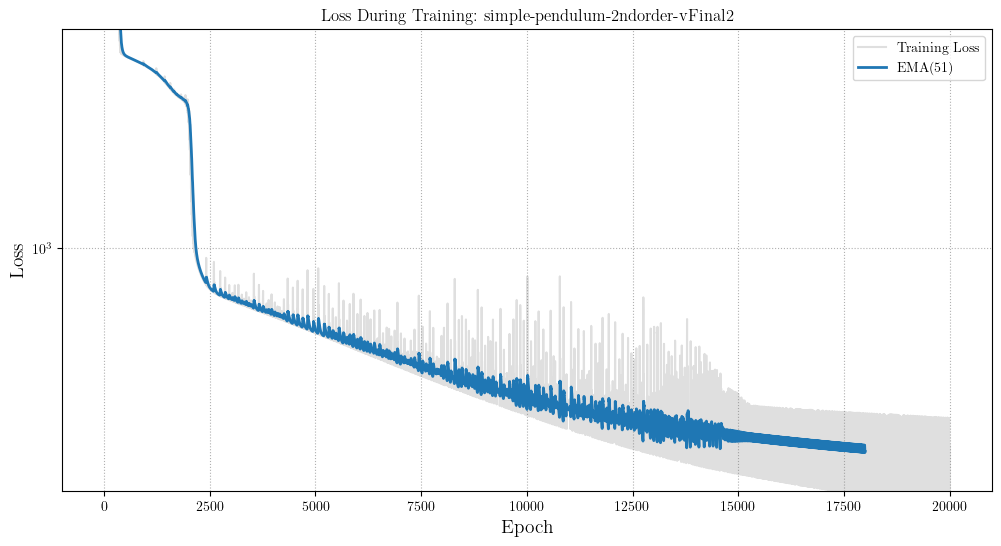

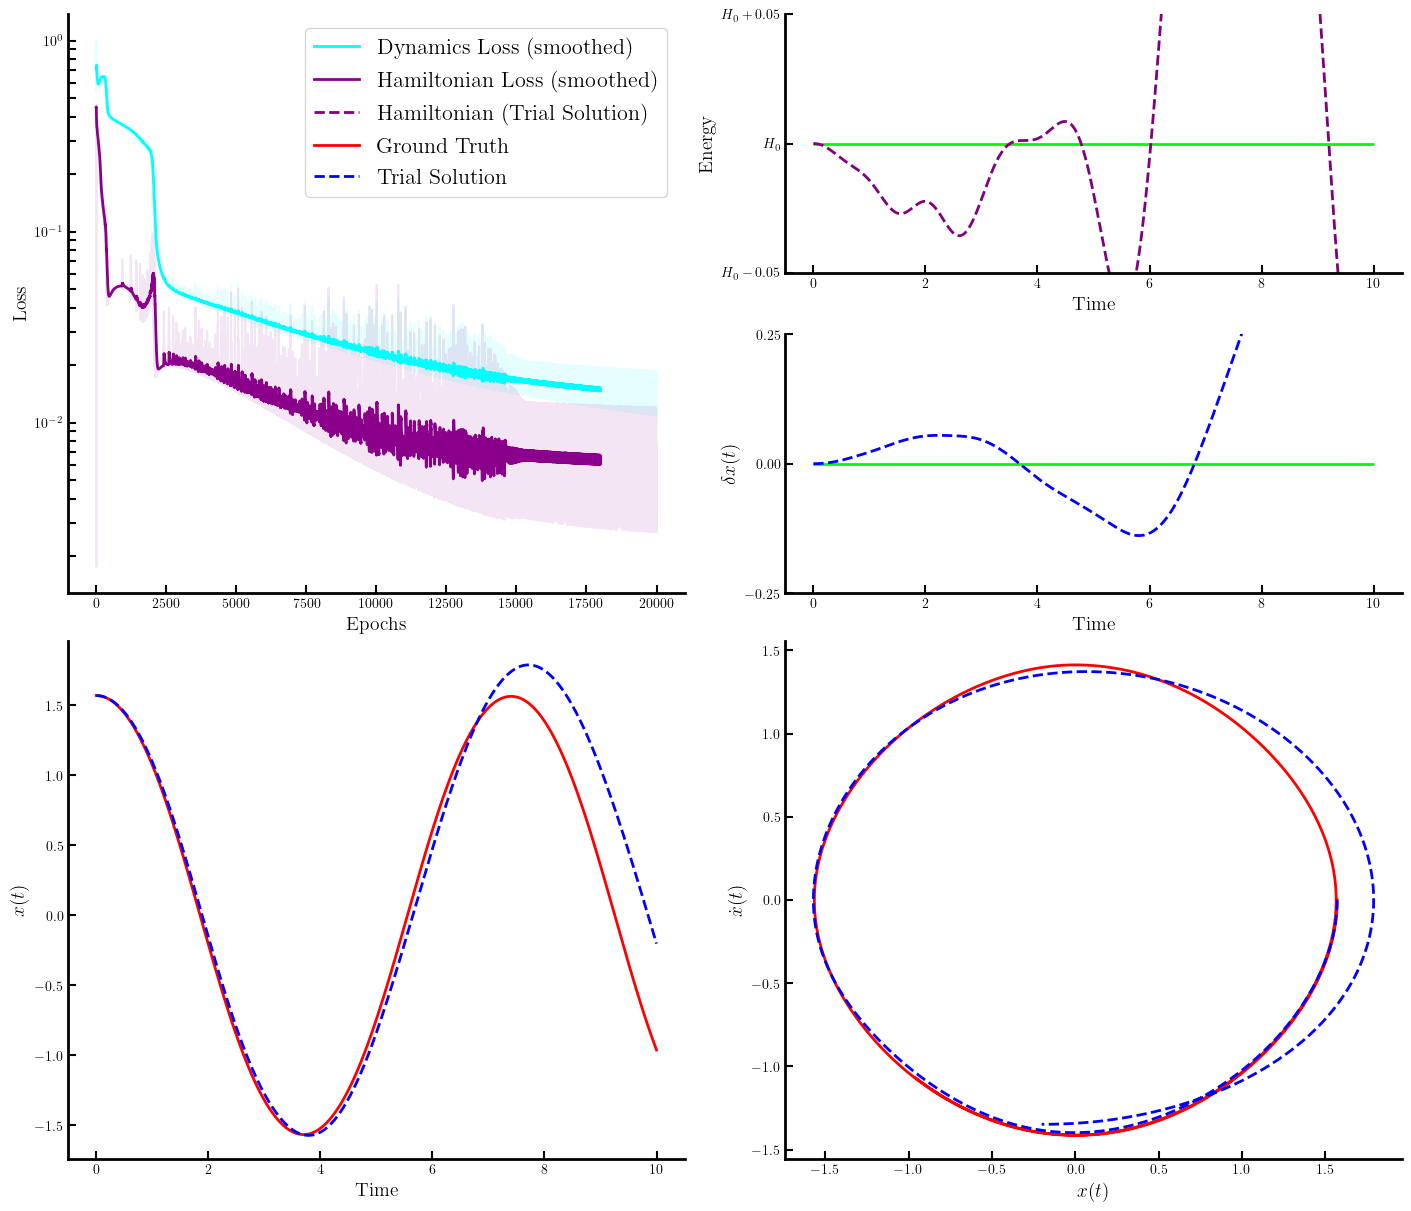

  0%|                                         | 1/20000 [00:00<41:29,  8.03it/s]

-13.789631802151042


  1%|▏                                      | 102/20000 [00:11<36:52,  8.99it/s]

-14.639532173524259


  1%|▍                                      | 202/20000 [00:22<35:09,  9.39it/s]

-15.032654410524742


  2%|▌                                      | 302/20000 [00:33<35:47,  9.17it/s]

-15.52511606595099


  2%|▊                                      | 402/20000 [00:44<37:07,  8.80it/s]

-16.134681619021933


  3%|▉                                      | 502/20000 [00:55<35:17,  9.21it/s]

-16.790409598424656


  3%|█▏                                     | 602/20000 [01:06<34:47,  9.29it/s]

-17.316404557035312


  4%|█▎                                     | 702/20000 [01:17<36:07,  8.90it/s]

-17.604103835573362


  4%|█▌                                     | 802/20000 [01:28<35:04,  9.12it/s]

-17.745535155781994


  5%|█▊                                     | 902/20000 [01:39<34:02,  9.35it/s]

-17.84451183234149


  5%|█▉                                    | 1002/20000 [01:50<34:30,  9.17it/s]

-17.930391416133904


  6%|██                                    | 1102/20000 [02:01<33:31,  9.40it/s]

-18.007116149857772


  6%|██▎                                   | 1202/20000 [02:12<33:22,  9.39it/s]

-18.07477751700063


  7%|██▍                                   | 1302/20000 [02:22<34:01,  9.16it/s]

-18.132904312276917


  7%|██▋                                   | 1402/20000 [02:33<32:38,  9.50it/s]

-18.181221425243674


  8%|██▊                                   | 1502/20000 [02:44<33:47,  9.12it/s]

-18.220118269428298


  8%|███                                   | 1602/20000 [02:55<32:54,  9.32it/s]

-18.250837779106185


  9%|███▏                                  | 1702/20000 [03:06<34:31,  8.83it/s]

-18.27526517038315


  9%|███▍                                  | 1802/20000 [03:17<33:28,  9.06it/s]

-18.29541523224784


 10%|███▌                                  | 1902/20000 [03:28<32:32,  9.27it/s]

-18.312938037644628


 10%|███▊                                  | 2002/20000 [03:39<32:08,  9.33it/s]

-18.328907132117806


 11%|███▉                                  | 2101/20000 [03:49<35:48,  8.33it/s]

-18.343889671477417


 11%|████▏                                 | 2202/20000 [04:00<32:28,  9.13it/s]

-18.358131025798933


 12%|████▎                                 | 2302/20000 [04:11<32:38,  9.04it/s]

-18.371717105488877


 12%|████▌                                 | 2402/20000 [04:22<32:01,  9.16it/s]

-18.3846732866423


 13%|████▊                                 | 2502/20000 [04:34<32:27,  8.98it/s]

-18.397012932658384


 13%|████▉                                 | 2602/20000 [04:45<32:13,  9.00it/s]

-18.40875752076269


 14%|█████▏                                | 2702/20000 [04:56<31:38,  9.11it/s]

-18.419942890549038


 14%|█████▎                                | 2802/20000 [05:07<31:28,  9.11it/s]

-18.43031313893698


 15%|█████▌                                | 2902/20000 [05:18<31:45,  8.97it/s]

-18.439579300601743


 15%|█████▋                                | 3002/20000 [05:29<30:41,  9.23it/s]

-18.44831786597552


 16%|█████▉                                | 3102/20000 [05:40<30:34,  9.21it/s]

-18.456823289441857


 16%|██████                                | 3202/20000 [05:51<30:55,  9.05it/s]

-18.464514039874764


 17%|██████▎                               | 3302/20000 [06:03<29:40,  9.38it/s]

-18.471833668780636


 17%|██████▍                               | 3402/20000 [06:14<30:10,  9.17it/s]

-18.479009436622853


 18%|██████▋                               | 3502/20000 [06:24<29:03,  9.46it/s]

-18.485609699738013


 18%|██████▊                               | 3602/20000 [06:36<29:40,  9.21it/s]

-18.49205986062606


 19%|███████                               | 3702/20000 [06:47<33:02,  8.22it/s]

-18.498280741061425


 19%|███████▏                              | 3802/20000 [06:58<30:13,  8.93it/s]

-18.50410164478711


 20%|███████▍                              | 3902/20000 [07:09<30:02,  8.93it/s]

-18.50991867236021


 20%|███████▌                              | 4002/20000 [07:21<29:24,  9.07it/s]

-18.515263953981098


 21%|███████▊                              | 4102/20000 [07:31<29:50,  8.88it/s]

-18.520526270243277


 21%|███████▉                              | 4202/20000 [07:43<28:42,  9.17it/s]

-18.52561870311186


 22%|████████▏                             | 4302/20000 [07:54<28:15,  9.26it/s]

-18.53042193193819


 22%|████████▎                             | 4402/20000 [08:05<28:30,  9.12it/s]

-18.535196112559987


 23%|████████▌                             | 4501/20000 [08:17<31:03,  8.32it/s]

-18.539643631729422


 23%|████████▋                             | 4602/20000 [08:28<28:22,  9.05it/s]

-18.543980037793464


 24%|████████▉                             | 4702/20000 [08:39<27:32,  9.26it/s]

-18.54820055871467


 24%|█████████                             | 4802/20000 [08:50<27:00,  9.38it/s]

-18.552155726422384


 25%|█████████▎                            | 4902/20000 [09:01<28:13,  8.91it/s]

-18.556076269669887


 25%|█████████▌                            | 5002/20000 [09:12<27:45,  9.00it/s]

-18.55981640454776


 26%|█████████▋                            | 5102/20000 [09:24<27:09,  9.14it/s]

-18.56337296178164


 26%|█████████▉                            | 5202/20000 [09:35<26:56,  9.15it/s]

-18.566929265420846


 27%|██████████                            | 5302/20000 [09:46<27:38,  8.86it/s]

-18.57023995970146


 27%|██████████▎                           | 5402/20000 [09:58<26:30,  9.18it/s]

-18.573393121464925


 28%|██████████▍                           | 5502/20000 [10:09<26:24,  9.15it/s]

-18.576561658855546


 28%|██████████▋                           | 5602/20000 [10:20<26:12,  9.15it/s]

-18.57923277401945


 29%|██████████▊                           | 5702/20000 [10:31<26:36,  8.96it/s]

-18.582524537810176


 29%|███████████                           | 5802/20000 [10:42<26:19,  8.99it/s]

-18.58538338011406


 30%|███████████▏                          | 5902/20000 [10:54<25:55,  9.07it/s]

-18.58826515846163


 30%|███████████▍                          | 6002/20000 [11:05<25:24,  9.18it/s]

-18.590891148155436


 31%|███████████▌                          | 6102/20000 [11:16<25:37,  9.04it/s]

-18.593482719155872


 31%|███████████▊                          | 6202/20000 [11:27<25:37,  8.97it/s]

-18.596101662591234


 32%|███████████▉                          | 6302/20000 [11:39<24:36,  9.28it/s]

-18.598587938939527


 32%|████████████▏                         | 6402/20000 [11:50<25:14,  8.98it/s]

-18.600995593441752


 33%|████████████▎                         | 6502/20000 [12:01<24:26,  9.20it/s]

-18.603395133127254


 33%|████████████▌                         | 6601/20000 [12:12<27:37,  8.08it/s]

-18.605795199772857


 34%|████████████▋                         | 6702/20000 [12:23<24:18,  9.12it/s]

-18.60800463153788


 34%|████████████▉                         | 6802/20000 [12:35<24:41,  8.91it/s]

-18.610219689810194


 35%|█████████████                         | 6902/20000 [12:46<24:42,  8.83it/s]

-18.612466462942283


 35%|█████████████▎                        | 7002/20000 [12:57<24:55,  8.69it/s]

-18.614571936887394


 36%|█████████████▍                        | 7102/20000 [13:09<24:39,  8.72it/s]

-18.616625986065976


 36%|█████████████▋                        | 7202/20000 [13:20<23:58,  8.90it/s]

-18.618711334418606


 37%|█████████████▊                        | 7302/20000 [13:32<25:28,  8.31it/s]

-18.620639949198917


 37%|██████████████                        | 7401/20000 [13:43<26:11,  8.02it/s]

-18.622664873301908


 38%|██████████████▎                       | 7502/20000 [13:55<23:18,  8.94it/s]

-18.624609068029866


 38%|██████████████▍                       | 7602/20000 [14:06<22:50,  9.05it/s]

-18.625021303231765


 39%|██████████████▋                       | 7701/20000 [14:17<23:15,  8.82it/s]

-18.628370619842443


 39%|██████████████▊                       | 7802/20000 [14:28<22:07,  9.19it/s]

-18.630189422791396


 40%|███████████████                       | 7902/20000 [14:40<22:42,  8.88it/s]

-18.632036997688857


 40%|███████████████▏                      | 8002/20000 [14:51<22:19,  8.95it/s]

-18.633767441515975


 41%|███████████████▍                      | 8102/20000 [15:02<21:36,  9.18it/s]

-18.635473556638832


 41%|███████████████▌                      | 8202/20000 [15:14<21:32,  9.13it/s]

-18.637204260918033


 42%|███████████████▊                      | 8302/20000 [15:25<20:55,  9.32it/s]

-18.638870950448478


 42%|███████████████▉                      | 8402/20000 [15:36<21:31,  8.98it/s]

-18.640482197261285


 43%|████████████████▏                     | 8502/20000 [15:47<21:09,  9.06it/s]

-18.642104452212767


 43%|████████████████▎                     | 8602/20000 [15:58<21:26,  8.86it/s]

-18.64241936379146


 44%|████████████████▌                     | 8702/20000 [16:10<21:04,  8.94it/s]

-18.64523068359196


 44%|████████████████▋                     | 8802/20000 [16:21<20:33,  9.08it/s]

-18.646751923614357


 45%|████████████████▉                     | 8901/20000 [16:32<23:27,  7.88it/s]

-18.648295745508037


 45%|█████████████████                     | 9001/20000 [16:43<21:11,  8.65it/s]

-18.649726190346076


 46%|█████████████████▎                    | 9102/20000 [16:54<20:07,  9.03it/s]

-18.65113759599302


 46%|█████████████████▍                    | 9202/20000 [17:06<19:58,  9.01it/s]

-18.6525694221501


 47%|█████████████████▋                    | 9302/20000 [17:17<20:00,  8.91it/s]

-18.651565260156


 47%|█████████████████▊                    | 9402/20000 [17:28<19:31,  9.05it/s]

-18.65529695591831


 48%|██████████████████                    | 9502/20000 [17:39<18:46,  9.32it/s]

-18.656609875286286


 48%|██████████████████▏                   | 9602/20000 [17:51<19:49,  8.74it/s]

-18.6579414628588


 49%|██████████████████▍                   | 9702/20000 [18:03<18:55,  9.07it/s]

-18.658854023911346


 49%|██████████████████▌                   | 9802/20000 [18:14<18:40,  9.10it/s]

-18.660471816886478


 50%|██████████████████▊                   | 9902/20000 [18:25<18:41,  9.01it/s]

-18.66169729366525


 50%|██████████████████▌                  | 10002/20000 [18:36<18:22,  9.07it/s]

-18.662939450281037


 51%|██████████████████▋                  | 10102/20000 [18:47<18:09,  9.08it/s]

-18.66396463729597


 51%|██████████████████▊                  | 10202/20000 [18:59<17:54,  9.12it/s]

-18.6652707560742


 52%|███████████████████                  | 10302/20000 [19:10<17:23,  9.29it/s]

-18.66641071452662


 52%|███████████████████▏                 | 10402/20000 [19:21<18:08,  8.82it/s]

-18.667565637696896


 53%|███████████████████▍                 | 10502/20000 [19:32<18:10,  8.71it/s]

-18.668620940214495


 53%|███████████████████▌                 | 10601/20000 [19:43<18:10,  8.62it/s]

-18.669721813894057


 54%|███████████████████▊                 | 10702/20000 [19:56<17:08,  9.04it/s]

-18.67078567385805


 54%|███████████████████▉                 | 10802/20000 [20:07<17:03,  8.99it/s]

-18.671863111933476


 55%|████████████████████▏                | 10902/20000 [20:18<16:30,  9.19it/s]

-18.672864953666302


 55%|████████████████████▎                | 11002/20000 [20:29<17:46,  8.44it/s]

-18.673850474928184


 56%|████████████████████▌                | 11102/20000 [20:40<16:27,  9.01it/s]

-18.674846160534784


 56%|████████████████████▋                | 11202/20000 [20:52<16:09,  9.07it/s]

-18.66716399802656


 57%|████████████████████▉                | 11302/20000 [21:03<17:47,  8.15it/s]

-18.676760559602222


 57%|█████████████████████                | 11402/20000 [21:14<16:33,  8.65it/s]

-18.677682202007635


 58%|█████████████████████▎               | 11502/20000 [21:25<15:19,  9.25it/s]

-18.678615630478625


 58%|█████████████████████▍               | 11602/20000 [21:36<15:07,  9.25it/s]

-18.679333413943866


 59%|█████████████████████▋               | 11702/20000 [21:47<14:42,  9.40it/s]

-18.680377594977788


 59%|█████████████████████▊               | 11802/20000 [21:58<15:00,  9.10it/s]

-18.681243727808074


 60%|██████████████████████               | 11902/20000 [22:09<15:06,  8.93it/s]

-18.68212111471899


 60%|██████████████████████▏              | 12002/20000 [22:20<14:38,  9.10it/s]

-18.682932344582895


 61%|██████████████████████▍              | 12101/20000 [22:32<20:04,  6.56it/s]

-18.683738763257505


 61%|██████████████████████▌              | 12202/20000 [22:43<15:15,  8.52it/s]

-18.684551207036247


 62%|██████████████████████▊              | 12302/20000 [22:55<14:27,  8.87it/s]

-18.680293723915646


 62%|██████████████████████▉              | 12402/20000 [23:06<13:57,  9.08it/s]

-18.686115101094725


 63%|███████████████████████▏             | 12502/20000 [23:17<13:15,  9.43it/s]

-18.6868688028143


 63%|███████████████████████▎             | 12602/20000 [23:28<13:34,  9.09it/s]

-18.68763268082885


 64%|███████████████████████▍             | 12702/20000 [23:39<13:13,  9.20it/s]

-18.68833241203987


 64%|███████████████████████▋             | 12802/20000 [23:50<13:06,  9.16it/s]

-18.68907932725508


 65%|███████████████████████▊             | 12902/20000 [24:02<13:12,  8.96it/s]

-18.68978948395433


 65%|████████████████████████             | 13002/20000 [24:13<13:28,  8.65it/s]

-18.690509829697483


 66%|████████████████████████▏            | 13102/20000 [24:24<12:54,  8.91it/s]

-18.691187163177176


 66%|████████████████████████▍            | 13202/20000 [24:35<13:08,  8.62it/s]

-18.691848923648415


 67%|████████████████████████▌            | 13302/20000 [24:46<12:23,  9.01it/s]

-18.692520130983382


 67%|████████████████████████▊            | 13402/20000 [24:57<12:06,  9.08it/s]

-18.69107818733793


 68%|████████████████████████▉            | 13502/20000 [25:08<12:08,  8.91it/s]

-18.6938152015488


 68%|█████████████████████████▏           | 13602/20000 [25:19<11:27,  9.31it/s]

-18.694440122105565


 69%|█████████████████████████▎           | 13702/20000 [25:30<11:33,  9.09it/s]

-18.69507474392242


 69%|█████████████████████████▌           | 13802/20000 [25:42<11:19,  9.13it/s]

-18.695252262844836


 70%|█████████████████████████▋           | 13902/20000 [25:54<11:31,  8.82it/s]

-18.696277613917335


 70%|█████████████████████████▉           | 14002/20000 [26:05<11:09,  8.96it/s]

-18.696868484363115


 71%|██████████████████████████           | 14102/20000 [26:16<11:03,  8.89it/s]

-18.69746886538043


 71%|██████████████████████████▎          | 14202/20000 [26:27<10:21,  9.32it/s]

-18.698001622628993


 72%|██████████████████████████▍          | 14302/20000 [26:38<10:11,  9.32it/s]

-18.698590278591425


 72%|██████████████████████████▋          | 14402/20000 [26:49<10:04,  9.27it/s]

-18.699150474312493


 73%|██████████████████████████▊          | 14502/20000 [27:00<10:05,  9.08it/s]

-18.69971999959709


 73%|███████████████████████████          | 14602/20000 [27:11<09:44,  9.24it/s]

-18.7002421294952


 74%|███████████████████████████▏         | 14702/20000 [27:22<09:30,  9.29it/s]

-18.70076241111817


 74%|███████████████████████████▍         | 14802/20000 [27:33<09:30,  9.12it/s]

-18.701291354900288


 75%|███████████████████████████▌         | 14902/20000 [27:44<09:39,  8.80it/s]

-18.701829364472907


 75%|███████████████████████████▊         | 15002/20000 [27:55<09:16,  8.98it/s]

-18.702314252879653


 76%|███████████████████████████▉         | 15102/20000 [28:06<08:51,  9.21it/s]

-18.702804124700883


 76%|████████████████████████████         | 15202/20000 [28:18<08:30,  9.40it/s]

-18.703300405232373


 77%|████████████████████████████▎        | 15301/20000 [28:29<09:53,  7.91it/s]

-18.703805544365064


 77%|████████████████████████████▍        | 15402/20000 [28:40<08:16,  9.27it/s]

-18.70426764648731


 78%|████████████████████████████▋        | 15502/20000 [28:51<08:05,  9.27it/s]

-18.704732214044824


 78%|████████████████████████████▊        | 15602/20000 [29:02<08:08,  9.00it/s]

-18.705198909300535


 79%|█████████████████████████████        | 15702/20000 [29:13<07:50,  9.14it/s]

-18.705674195620173


 79%|█████████████████████████████▏       | 15802/20000 [29:25<07:34,  9.24it/s]

-18.706082733176245


 80%|█████████████████████████████▍       | 15902/20000 [29:36<07:34,  9.01it/s]

-18.70655618010216


 80%|█████████████████████████████▌       | 16002/20000 [29:47<07:30,  8.87it/s]

-18.70699626503929


 81%|█████████████████████████████▊       | 16101/20000 [29:58<07:11,  9.04it/s]

-18.707444676393077


 81%|█████████████████████████████▉       | 16202/20000 [30:09<06:50,  9.25it/s]

-18.70781426332563


 82%|██████████████████████████████▏      | 16302/20000 [30:21<06:41,  9.21it/s]

-18.70828422169916


 82%|██████████████████████████████▎      | 16401/20000 [30:32<06:38,  9.03it/s]

-18.70870027092772


 83%|██████████████████████████████▌      | 16502/20000 [30:43<06:32,  8.92it/s]

-18.709124389278074


 83%|██████████████████████████████▋      | 16602/20000 [30:54<06:15,  9.05it/s]

-18.709537587207844


 84%|██████████████████████████████▉      | 16702/20000 [31:05<06:01,  9.14it/s]

-18.7099244005531


 84%|███████████████████████████████      | 16802/20000 [31:16<06:04,  8.78it/s]

-18.710319489444142


 85%|███████████████████████████████▎     | 16902/20000 [31:27<05:39,  9.13it/s]

-18.710722407325598


 85%|███████████████████████████████▍     | 17002/20000 [31:38<05:31,  9.05it/s]

-18.710826390745055


 86%|███████████████████████████████▋     | 17102/20000 [31:49<05:21,  9.01it/s]

-18.711482379610676


 86%|███████████████████████████████▊     | 17202/20000 [32:00<05:11,  8.97it/s]

-18.711857643761487


 87%|████████████████████████████████     | 17302/20000 [32:11<04:58,  9.05it/s]

-18.712240511875105


 87%|████████████████████████████████▏    | 17402/20000 [32:22<04:43,  9.17it/s]

-18.71203655680166


 88%|████████████████████████████████▍    | 17502/20000 [32:34<04:32,  9.16it/s]

-18.71296423805809


 88%|████████████████████████████████▌    | 17602/20000 [32:45<04:27,  8.96it/s]

-18.713320864592994


 89%|████████████████████████████████▋    | 17702/20000 [32:57<04:25,  8.67it/s]

-18.713684847345412


 89%|████████████████████████████████▉    | 17802/20000 [33:08<04:01,  9.11it/s]

-18.713635357490226


 90%|█████████████████████████████████    | 17902/20000 [33:19<03:48,  9.20it/s]

-18.71437454637696


 90%|█████████████████████████████████▎   | 18002/20000 [33:30<03:38,  9.15it/s]

-18.714712447062766


 91%|█████████████████████████████████▍   | 18102/20000 [33:41<03:22,  9.37it/s]

-18.715057410975902


 91%|█████████████████████████████████▋   | 18202/20000 [33:51<03:13,  9.31it/s]

-18.715027020033887


 92%|█████████████████████████████████▊   | 18302/20000 [34:03<03:05,  9.13it/s]

-18.715718992689474


 92%|██████████████████████████████████   | 18402/20000 [34:14<02:59,  8.88it/s]

-18.71603767446682


 93%|██████████████████████████████████▏  | 18502/20000 [34:25<02:41,  9.26it/s]

-18.716363080709755


 93%|██████████████████████████████████▍  | 18602/20000 [34:36<02:27,  9.46it/s]

-18.71669549416579


 94%|██████████████████████████████████▌  | 18702/20000 [34:47<02:19,  9.29it/s]

-18.716981736461413


 94%|██████████████████████████████████▊  | 18802/20000 [34:58<02:09,  9.23it/s]

-18.717305369932205


 95%|██████████████████████████████████▉  | 18902/20000 [35:09<01:59,  9.23it/s]

-18.71761337979061


 95%|███████████████████████████████████▏ | 19002/20000 [35:20<01:46,  9.35it/s]

-18.717928126075293


 96%|███████████████████████████████████▎ | 19102/20000 [35:31<01:39,  9.04it/s]

-18.717623404227673


 96%|███████████████████████████████████▌ | 19202/20000 [35:42<01:27,  9.08it/s]

-18.718518651906855


 97%|███████████████████████████████████▋ | 19302/20000 [35:53<01:15,  9.26it/s]

-18.718811536233794


 97%|███████████████████████████████████▉ | 19402/20000 [36:05<01:05,  9.09it/s]

-18.719110904660532


 98%|████████████████████████████████████ | 19502/20000 [36:16<00:55,  9.03it/s]

-18.71803876841561


 98%|████████████████████████████████████▎| 19601/20000 [36:27<00:44,  8.93it/s]

-18.719680229085885


 99%|████████████████████████████████████▍| 19702/20000 [36:39<00:32,  9.12it/s]

-18.71996007420593


 99%|████████████████████████████████████▋| 19802/20000 [36:51<00:24,  8.24it/s]

-18.72024618269726


100%|████████████████████████████████████▊| 19902/20000 [37:01<00:10,  9.24it/s]

-18.720519428719967


100%|█████████████████████████████████████| 20000/20000 [37:12<00:00,  8.96it/s]


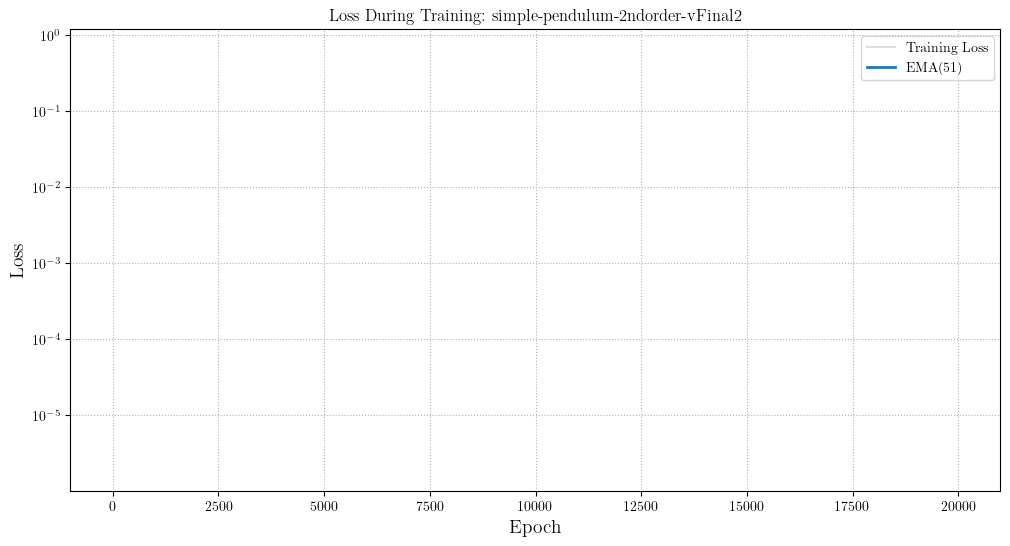

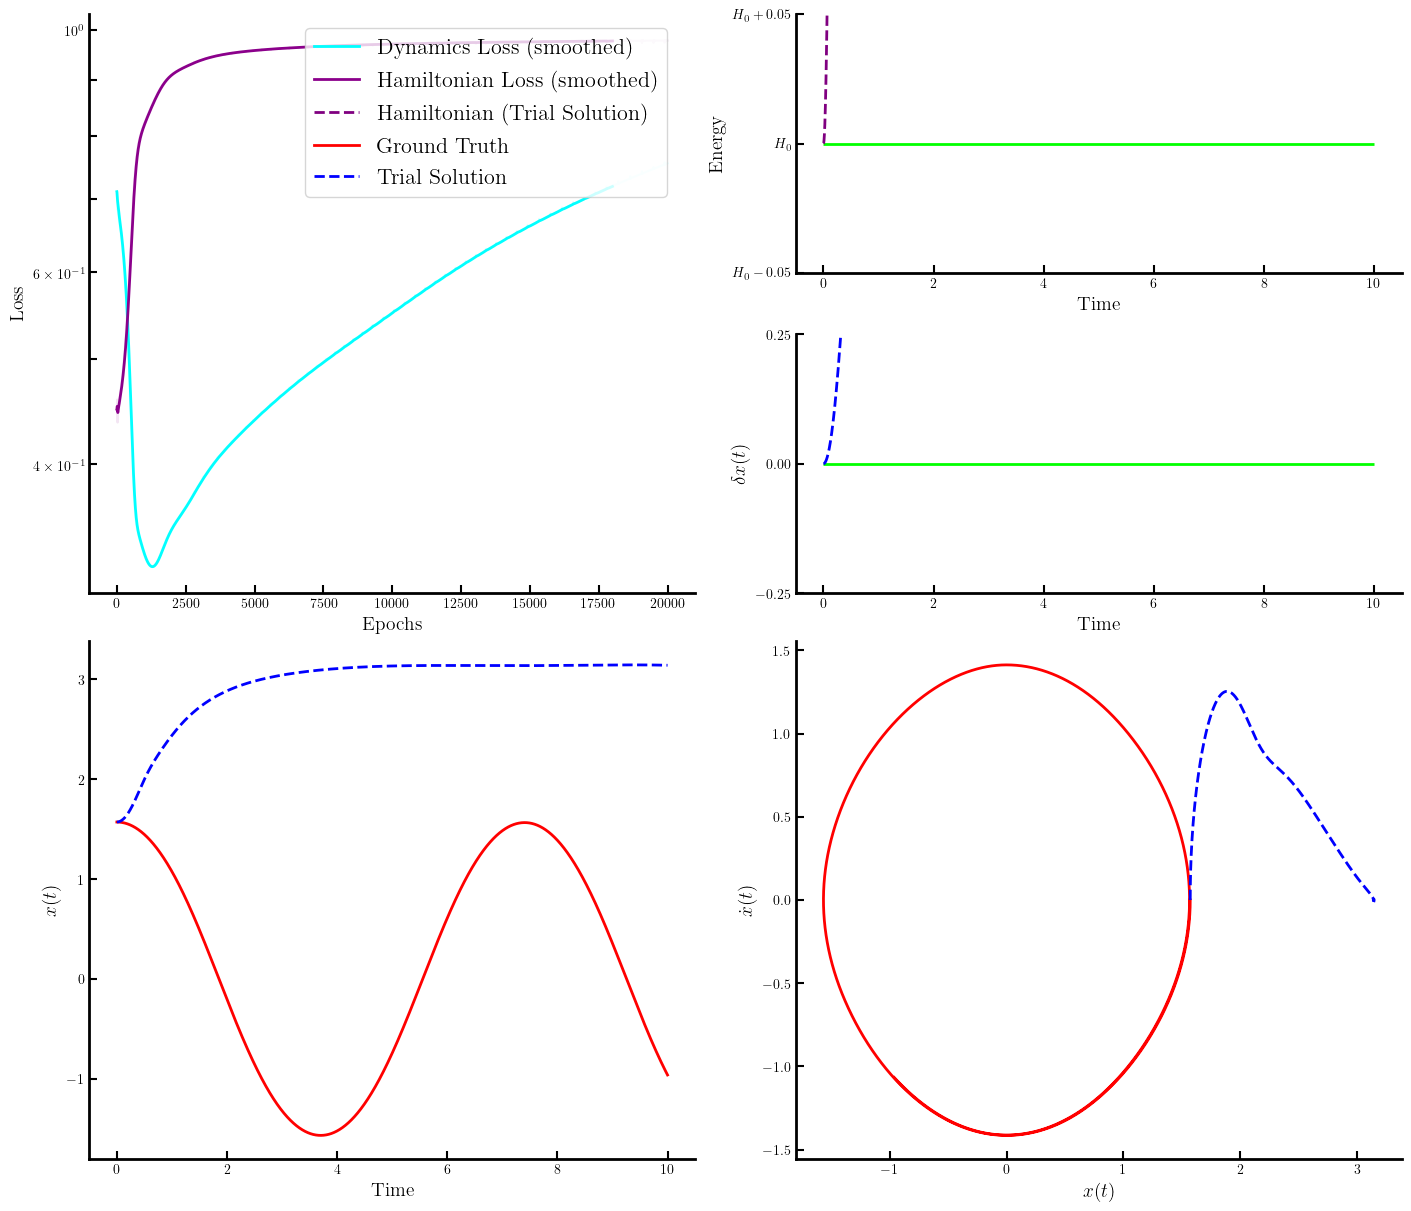

  0%|                                         | 1/20000 [00:00<38:17,  8.70it/s]

7110.712831348228


  1%|▏                                      | 102/20000 [00:11<35:52,  9.24it/s]

6559.298022365529


  1%|▍                                      | 202/20000 [00:22<35:23,  9.32it/s]

6083.618865780955


  2%|▌                                      | 302/20000 [00:33<36:04,  9.10it/s]

5367.185657462161


  2%|▊                                      | 402/20000 [00:45<35:38,  9.16it/s]

4433.181044373721


  3%|▉                                      | 502/20000 [00:56<35:53,  9.05it/s]

3721.393194045535


  3%|█▏                                     | 602/20000 [01:07<34:38,  9.33it/s]

3471.573169048422


  4%|█▎                                     | 701/20000 [01:18<41:02,  7.84it/s]

3362.7482563621925


  4%|█▌                                     | 801/20000 [01:29<40:26,  7.91it/s]

3285.0787187489855


  5%|█▊                                     | 902/20000 [01:41<36:22,  8.75it/s]

3228.827146140623


  5%|█▉                                    | 1002/20000 [01:52<34:07,  9.28it/s]

3190.109318107125


  6%|██                                    | 1102/20000 [02:03<35:06,  8.97it/s]

3164.8645024506213


  6%|██▎                                   | 1202/20000 [02:14<35:00,  8.95it/s]

3148.8674518239245


  7%|██▍                                   | 1302/20000 [02:26<35:09,  8.86it/s]

3138.4507038149277


  7%|██▋                                   | 1402/20000 [02:37<33:23,  9.28it/s]

3131.048318603887


  8%|██▊                                   | 1502/20000 [02:48<34:34,  8.92it/s]

3125.197320843389


  8%|███                                   | 1601/20000 [02:59<33:20,  9.20it/s]

3120.190910352684


  9%|███▏                                  | 1702/20000 [03:10<33:58,  8.98it/s]

3115.7175986837847


  9%|███▍                                  | 1801/20000 [03:22<40:20,  7.52it/s]

3111.6355185553207


 10%|███▌                                  | 1902/20000 [03:34<33:37,  8.97it/s]

3107.867823458496


 10%|███▊                                  | 2002/20000 [03:46<33:19,  9.00it/s]

3104.3638178313427


 11%|███▉                                  | 2102/20000 [03:57<33:27,  8.92it/s]

3101.086853333516


 11%|████▏                                 | 2201/20000 [04:09<33:16,  8.92it/s]

3098.1785468721823


 12%|████▎                                 | 2302/20000 [04:20<34:03,  8.66it/s]

3095.5911885118485


 12%|████▌                                 | 2402/20000 [04:32<32:33,  9.01it/s]

3093.127148333369


 13%|████▊                                 | 2502/20000 [04:43<32:14,  9.04it/s]

3090.7865671836507


 13%|████▉                                 | 2602/20000 [04:54<32:06,  9.03it/s]

3088.7581827456743


 14%|█████▏                                | 2702/20000 [05:05<31:33,  9.13it/s]

3086.88556298246


 14%|█████▎                                | 2802/20000 [05:16<32:26,  8.83it/s]

3085.109341642977


 15%|█████▌                                | 2902/20000 [05:27<31:37,  9.01it/s]

3083.5284148548967


 15%|█████▋                                | 3002/20000 [05:38<30:37,  9.25it/s]

3082.1164783477534


 16%|█████▉                                | 3102/20000 [05:49<29:52,  9.43it/s]

3080.784899999412


 16%|██████                                | 3202/20000 [06:00<30:46,  9.10it/s]

3079.5936082877174


 17%|██████▎                               | 3302/20000 [06:12<30:15,  9.20it/s]

3078.5338679674433


 17%|██████▍                               | 3402/20000 [06:23<29:30,  9.37it/s]

3077.542934635405


 18%|██████▋                               | 3502/20000 [06:34<29:48,  9.23it/s]

3076.639448110083


 18%|██████▊                               | 3602/20000 [06:45<30:37,  8.92it/s]

3075.8553064465605


 19%|███████                               | 3702/20000 [06:56<30:23,  8.94it/s]

3075.1138440373797


 19%|███████▏                              | 3802/20000 [07:07<29:11,  9.25it/s]

3074.432544315775


 20%|███████▍                              | 3901/20000 [07:18<34:42,  7.73it/s]

3073.8339306105604


 20%|███████▌                              | 4001/20000 [07:29<30:03,  8.87it/s]

3073.270444347463


 21%|███████▊                              | 4102/20000 [07:40<28:40,  9.24it/s]

3072.7680095814994


 21%|███████▉                              | 4202/20000 [07:51<28:57,  9.09it/s]

3072.2716696847256


 22%|████████▏                             | 4302/20000 [08:03<28:32,  9.17it/s]

3071.831960371156


 22%|████████▎                             | 4402/20000 [08:14<28:27,  9.13it/s]

3071.4092322418956


 23%|████████▌                             | 4502/20000 [08:26<28:49,  8.96it/s]

3071.028496954299


 23%|████████▋                             | 4601/20000 [08:37<28:33,  8.99it/s]

3070.6763524196003


 24%|████████▉                             | 4702/20000 [08:48<28:57,  8.80it/s]

3070.33516867693


 24%|█████████                             | 4802/20000 [08:59<27:35,  9.18it/s]

3070.0821751213207


 25%|█████████▎                            | 4902/20000 [09:10<27:38,  9.10it/s]

3069.7222009369725


 25%|█████████▌                            | 5002/20000 [09:22<26:50,  9.31it/s]

3069.441774280982


 26%|█████████▋                            | 5102/20000 [09:33<28:05,  8.84it/s]

3069.1686863484183


 26%|█████████▉                            | 5202/20000 [09:44<27:31,  8.96it/s]

3068.921360569158


 27%|██████████                            | 5302/20000 [09:55<28:30,  8.59it/s]

3068.688358985812


 27%|██████████▎                           | 5402/20000 [10:06<26:15,  9.27it/s]

3068.4616127556537


 28%|██████████▍                           | 5502/20000 [10:17<25:54,  9.33it/s]

3068.352201447446


 28%|██████████▋                           | 5602/20000 [10:28<26:45,  8.97it/s]

3068.050450097109


 29%|██████████▊                           | 5702/20000 [10:39<25:40,  9.28it/s]

3067.8627807434227


 29%|███████████                           | 5802/20000 [10:51<26:36,  8.89it/s]

3067.680401167509


 30%|███████████▏                          | 5902/20000 [11:02<25:54,  9.07it/s]

3067.5121725628333


 30%|███████████▍                          | 6002/20000 [11:13<25:23,  9.19it/s]

3067.358290639406


 31%|███████████▌                          | 6102/20000 [11:25<25:50,  8.96it/s]

3067.2090681730447


 31%|███████████▊                          | 6202/20000 [11:36<25:38,  8.97it/s]

3067.064857461314


 32%|███████████▉                          | 6302/20000 [11:47<25:48,  8.85it/s]

3066.9370524838287


 32%|████████████▏                         | 6402/20000 [11:58<26:17,  8.62it/s]

3066.8163788286147


 33%|████████████▎                         | 6502/20000 [12:10<24:45,  9.08it/s]

3066.7000539447135


 33%|████████████▌                         | 6602/20000 [12:21<24:29,  9.12it/s]

3066.5983282911675


 34%|████████████▋                         | 6702/20000 [12:32<23:39,  9.37it/s]

3066.4926749590118


 34%|████████████▉                         | 6802/20000 [12:44<24:19,  9.04it/s]

3066.4000269972325


 35%|█████████████                         | 6902/20000 [12:55<24:23,  8.95it/s]

3066.311055151596


 35%|█████████████▎                        | 7002/20000 [13:06<22:52,  9.47it/s]

3066.242336656442


 36%|█████████████▍                        | 7102/20000 [13:17<22:22,  9.60it/s]

3066.1550539295085


 36%|█████████████▋                        | 7202/20000 [13:28<22:45,  9.37it/s]

3066.084895210701


 37%|█████████████▊                        | 7302/20000 [13:38<22:42,  9.32it/s]

3066.0176226990397


 37%|██████████████                        | 7402/20000 [13:49<22:25,  9.36it/s]

3065.9983015237394


 38%|██████████████▎                       | 7502/20000 [13:59<22:04,  9.43it/s]

3065.900449787459


 38%|██████████████▍                       | 7602/20000 [14:10<21:58,  9.40it/s]

3065.8473509228784


 39%|██████████████▋                       | 7702/20000 [14:21<21:25,  9.57it/s]

3065.7963333796515


 39%|██████████████▊                       | 7801/20000 [14:31<21:28,  9.47it/s]

3065.761014626128


 40%|███████████████                       | 7902/20000 [14:42<21:29,  9.38it/s]

3065.7076075565783


 40%|███████████████▏                      | 8002/20000 [14:53<21:14,  9.41it/s]

3065.6670805687245


 41%|███████████████▍                      | 8102/20000 [15:04<21:09,  9.37it/s]

3065.62791114259


 41%|███████████████▌                      | 8202/20000 [15:14<20:16,  9.70it/s]

3065.970403924239


 42%|███████████████▊                      | 8302/20000 [15:26<20:41,  9.42it/s]

3065.5584936234563


 42%|███████████████▉                      | 8402/20000 [15:37<20:17,  9.52it/s]

3065.5267917746924


 43%|████████████████▏                     | 8501/20000 [15:48<25:31,  7.51it/s]

3065.495924565915


 43%|████████████████▎                     | 8602/20000 [15:59<20:21,  9.33it/s]

3065.4668169976894


 44%|████████████████▌                     | 8702/20000 [16:10<20:20,  9.26it/s]

3065.4399535729162


 44%|████████████████▋                     | 8802/20000 [16:21<20:10,  9.25it/s]

3065.4142528195384


 45%|████████████████▉                     | 8902/20000 [16:32<20:11,  9.16it/s]

3065.389215521304


 45%|█████████████████                     | 9002/20000 [16:43<19:53,  9.21it/s]

3065.364669245836


 46%|█████████████████▎                    | 9102/20000 [16:54<19:21,  9.38it/s]

3065.3460618203762


 46%|█████████████████▍                    | 9202/20000 [17:05<18:58,  9.49it/s]

3065.3213411078937


 47%|█████████████████▋                    | 9302/20000 [17:16<20:36,  8.65it/s]

3065.300520308191


 47%|█████████████████▊                    | 9402/20000 [17:27<18:43,  9.43it/s]

3065.2800072946748


 48%|██████████████████                    | 9502/20000 [17:37<18:33,  9.43it/s]

3065.2802486106057


 48%|██████████████████▏                   | 9602/20000 [17:48<18:36,  9.31it/s]

3065.243031653969


 49%|██████████████████▍                   | 9702/20000 [18:00<17:57,  9.56it/s]

3065.2254319126373


 49%|██████████████████▌                   | 9802/20000 [18:10<18:04,  9.40it/s]

3065.2080444545386


 50%|██████████████████▊                   | 9902/20000 [18:21<17:41,  9.51it/s]

3065.782103875315


 50%|██████████████████▌                  | 10002/20000 [18:32<18:20,  9.08it/s]

3065.176201633094


 51%|██████████████████▋                  | 10102/20000 [18:43<17:55,  9.20it/s]

3065.161184330582


 51%|██████████████████▊                  | 10202/20000 [18:54<17:35,  9.29it/s]

3065.146339618306


 52%|███████████████████                  | 10302/20000 [19:05<17:28,  9.25it/s]

3065.1323959573638


 52%|███████████████████▏                 | 10401/20000 [19:15<19:29,  8.21it/s]

3065.118938679844


 53%|███████████████████▍                 | 10502/20000 [19:26<17:06,  9.26it/s]

3065.1059958349174


 53%|███████████████████▌                 | 10602/20000 [19:37<17:07,  9.15it/s]

3065.0933245086685


 54%|███████████████████▊                 | 10702/20000 [19:48<16:53,  9.17it/s]

3065.0808047536634


 54%|███████████████████▉                 | 10802/20000 [19:59<16:41,  9.18it/s]

3065.074540748673


 55%|████████████████████▏                | 10902/20000 [20:10<16:02,  9.45it/s]

3065.0585170980507


 55%|████████████████████▎                | 11002/20000 [20:21<16:06,  9.31it/s]

3065.0477330401304


 56%|████████████████████▌                | 11102/20000 [20:32<16:06,  9.20it/s]

3065.037082692053


 56%|████████████████████▋                | 11202/20000 [20:43<16:11,  9.06it/s]

3065.1918179332097


 57%|████████████████████▉                | 11302/20000 [20:55<16:40,  8.69it/s]

3065.017739401588


 57%|█████████████████████                | 11402/20000 [21:06<15:35,  9.19it/s]

3065.0085865843453


 58%|█████████████████████▎               | 11502/20000 [21:17<15:32,  9.11it/s]

3064.9995588251704


 58%|█████████████████████▍               | 11602/20000 [21:28<14:57,  9.35it/s]

3064.9907181751855


 59%|█████████████████████▋               | 11702/20000 [21:39<14:46,  9.36it/s]

3064.9831547632075


 59%|█████████████████████▊               | 11802/20000 [21:50<15:07,  9.04it/s]

3064.9752434857646


 60%|██████████████████████               | 11902/20000 [22:01<16:14,  8.31it/s]

3064.9676724863116


 60%|██████████████████████▏              | 12002/20000 [22:11<14:14,  9.36it/s]

3064.9602296122557


 61%|██████████████████████▍              | 12102/20000 [22:22<14:22,  9.16it/s]

3064.9663219276326


 61%|██████████████████████▌              | 12202/20000 [22:33<13:47,  9.42it/s]

3064.946995898458


 62%|██████████████████████▊              | 12302/20000 [22:45<13:49,  9.28it/s]

3064.9406900714957


 62%|██████████████████████▉              | 12402/20000 [22:56<13:31,  9.36it/s]

3064.9345048609644


 63%|███████████████████████▏             | 12502/20000 [23:07<14:05,  8.87it/s]

3064.9828119102913


 63%|███████████████████████▎             | 12601/20000 [23:18<13:24,  9.20it/s]

3064.9233995161267


 64%|███████████████████████▍             | 12702/20000 [23:29<12:52,  9.45it/s]

3064.9181244443835


 64%|███████████████████████▋             | 12802/20000 [23:40<13:17,  9.02it/s]

3064.913049456044


 65%|███████████████████████▊             | 12902/20000 [23:51<13:10,  8.98it/s]

3064.9080918820882


 65%|████████████████████████             | 13002/20000 [24:02<12:49,  9.09it/s]

3064.9316258150143


 66%|████████████████████████▏            | 13102/20000 [24:12<12:19,  9.32it/s]

3064.89940764379


 66%|████████████████████████▍            | 13202/20000 [24:23<12:17,  9.22it/s]

3064.8952896467426


 67%|████████████████████████▌            | 13302/20000 [24:34<12:17,  9.08it/s]

3064.891277317668


 67%|████████████████████████▊            | 13402/20000 [24:46<11:42,  9.40it/s]

3064.887375230628


 68%|████████████████████████▉            | 13502/20000 [24:57<11:21,  9.54it/s]

3064.8849811013524


 68%|█████████████████████████▏           | 13602/20000 [25:08<11:30,  9.26it/s]

3064.8807271810233


 69%|█████████████████████████▎           | 13702/20000 [25:19<11:32,  9.10it/s]

3064.8775141777355


 69%|█████████████████████████▌           | 13802/20000 [25:31<11:18,  9.14it/s]

3064.874396195285


 70%|█████████████████████████▋           | 13902/20000 [25:42<11:06,  9.15it/s]

3066.1739635040835


 70%|█████████████████████████▉           | 14002/20000 [25:53<10:56,  9.14it/s]

3064.868916515489


 71%|██████████████████████████           | 14102/20000 [26:04<10:48,  9.09it/s]

3064.866363688743


 71%|██████████████████████████▎          | 14202/20000 [26:15<10:30,  9.20it/s]

3064.863898055656


 72%|██████████████████████████▍          | 14302/20000 [26:26<10:29,  9.06it/s]

3064.8615147677515


 72%|██████████████████████████▋          | 14402/20000 [26:37<09:57,  9.37it/s]

3064.992867930542


 73%|██████████████████████████▊          | 14502/20000 [26:48<10:12,  8.97it/s]

3064.857403447338


 73%|███████████████████████████          | 14602/20000 [26:59<10:01,  8.98it/s]

3064.855463942264


 74%|███████████████████████████▏         | 14702/20000 [27:10<09:59,  8.84it/s]

3064.853593318628


 74%|███████████████████████████▍         | 14802/20000 [27:21<09:18,  9.31it/s]

3064.851791275094


 75%|███████████████████████████▌         | 14902/20000 [27:32<09:15,  9.18it/s]

3064.852634339282


 75%|███████████████████████████▊         | 15002/20000 [27:43<08:54,  9.35it/s]

3064.848741165212


 76%|███████████████████████████▉         | 15102/20000 [27:54<08:44,  9.33it/s]

3064.8472752684115


 76%|████████████████████████████         | 15202/20000 [28:05<08:44,  9.15it/s]

3064.8458643933627


 77%|████████████████████████████▎        | 15302/20000 [28:16<08:28,  9.24it/s]

3064.844708094267


 77%|████████████████████████████▍        | 15402/20000 [28:27<08:34,  8.94it/s]

3064.843640801595


 78%|████████████████████████████▋        | 15502/20000 [28:39<08:05,  9.27it/s]

3064.842288159009


 78%|████████████████████████████▊        | 15602/20000 [28:50<08:02,  9.11it/s]

3064.841191000334


 79%|█████████████████████████████        | 15702/20000 [29:01<07:57,  9.00it/s]

3064.8401359760055


 79%|█████████████████████████████▏       | 15802/20000 [29:12<07:34,  9.24it/s]

3064.839144470545


 80%|█████████████████████████████▍       | 15902/20000 [29:23<07:23,  9.23it/s]

3064.8387213904534


 80%|█████████████████████████████▌       | 16002/20000 [29:34<07:06,  9.38it/s]

3064.8374601565974


 81%|█████████████████████████████▊       | 16102/20000 [29:45<07:09,  9.07it/s]

3064.8366332060523


 81%|█████████████████████████████▉       | 16202/20000 [29:56<06:57,  9.10it/s]

3064.8358379310116


 82%|██████████████████████████████▏      | 16302/20000 [30:08<06:46,  9.11it/s]

3064.8461119789335


 82%|██████████████████████████████▎      | 16402/20000 [30:19<06:37,  9.05it/s]

3064.8345903240543


 83%|██████████████████████████████▌      | 16502/20000 [30:30<06:39,  8.77it/s]

3064.8338216476905


 83%|██████████████████████████████▋      | 16602/20000 [30:41<06:16,  9.03it/s]

3064.833190346172


 84%|██████████████████████████████▉      | 16702/20000 [30:52<05:57,  9.23it/s]

3064.8325824865265


 84%|███████████████████████████████      | 16802/20000 [31:04<05:53,  9.04it/s]

3065.6160338522814


 85%|███████████████████████████████▎     | 16902/20000 [31:14<05:37,  9.19it/s]

3064.831556874363


 85%|███████████████████████████████▍     | 17002/20000 [31:27<05:44,  8.70it/s]

3064.8310485168868


 86%|███████████████████████████████▋     | 17102/20000 [31:38<05:23,  8.97it/s]

3064.830559733083


 86%|███████████████████████████████▊     | 17202/20000 [31:49<05:02,  9.24it/s]

3064.830087955509


 87%|████████████████████████████████     | 17302/20000 [32:00<05:03,  8.90it/s]

3065.0521669680425


 87%|████████████████████████████████▏    | 17402/20000 [32:11<04:31,  9.59it/s]

3064.8292987787663


 88%|████████████████████████████████▍    | 17502/20000 [32:22<04:37,  9.01it/s]

3064.828894355427


 88%|████████████████████████████████▌    | 17602/20000 [32:33<04:20,  9.20it/s]

3064.8285086671126


 89%|████████████████████████████████▋    | 17702/20000 [32:44<04:17,  8.94it/s]

3064.828135150755


 89%|████████████████████████████████▉    | 17802/20000 [32:55<04:00,  9.13it/s]

3064.8611084642557


 90%|█████████████████████████████████    | 17902/20000 [33:06<03:45,  9.29it/s]

3064.8275051207365


 90%|█████████████████████████████████▎   | 18001/20000 [33:18<03:43,  8.94it/s]

3064.8271843702323


 91%|█████████████████████████████████▍   | 18101/20000 [33:29<03:31,  8.98it/s]

3064.826873324075


 91%|█████████████████████████████████▋   | 18202/20000 [33:41<03:12,  9.32it/s]

3064.8265708414847


 92%|█████████████████████████████████▊   | 18302/20000 [33:51<03:11,  8.85it/s]

3064.8275729200805


 92%|██████████████████████████████████   | 18402/20000 [34:03<03:01,  8.79it/s]

3064.8260600608774


 93%|██████████████████████████████████▏  | 18502/20000 [34:14<02:41,  9.30it/s]

3064.825797184779


 93%|██████████████████████████████████▍  | 18602/20000 [34:25<02:31,  9.24it/s]

3064.8255407423358


 94%|██████████████████████████████████▌  | 18702/20000 [34:36<02:21,  9.20it/s]

3066.668708763041


 94%|██████████████████████████████████▊  | 18802/20000 [34:47<02:10,  9.19it/s]

3064.8251420408114


 95%|██████████████████████████████████▉  | 18902/20000 [34:58<01:57,  9.37it/s]

3064.824868957376


 95%|███████████████████████████████████▏ | 19002/20000 [35:09<01:46,  9.41it/s]

3064.8246491847212


 96%|███████████████████████████████████▎ | 19102/20000 [35:21<01:36,  9.35it/s]

3064.8244336338853


 96%|███████████████████████████████████▌ | 19202/20000 [35:32<01:26,  9.25it/s]

3064.8555672126377


 97%|███████████████████████████████████▋ | 19302/20000 [35:43<01:15,  9.21it/s]

3064.8240558264606


 97%|███████████████████████████████████▉ | 19402/20000 [35:54<01:07,  8.89it/s]

3064.8238650829485


 98%|████████████████████████████████████ | 19502/20000 [36:05<00:53,  9.36it/s]

3064.8236776146605


 98%|████████████████████████████████████▎| 19602/20000 [36:16<00:42,  9.31it/s]

3064.823492751939


 99%|████████████████████████████████████▍| 19702/20000 [36:27<00:32,  9.20it/s]

3064.8241100981295


 99%|████████████████████████████████████▋| 19802/20000 [36:38<00:21,  9.32it/s]

3064.823167583272


100%|████████████████████████████████████▊| 19902/20000 [36:49<00:10,  9.16it/s]

3064.823003166629


100%|█████████████████████████████████████| 20000/20000 [37:00<00:00,  9.01it/s]


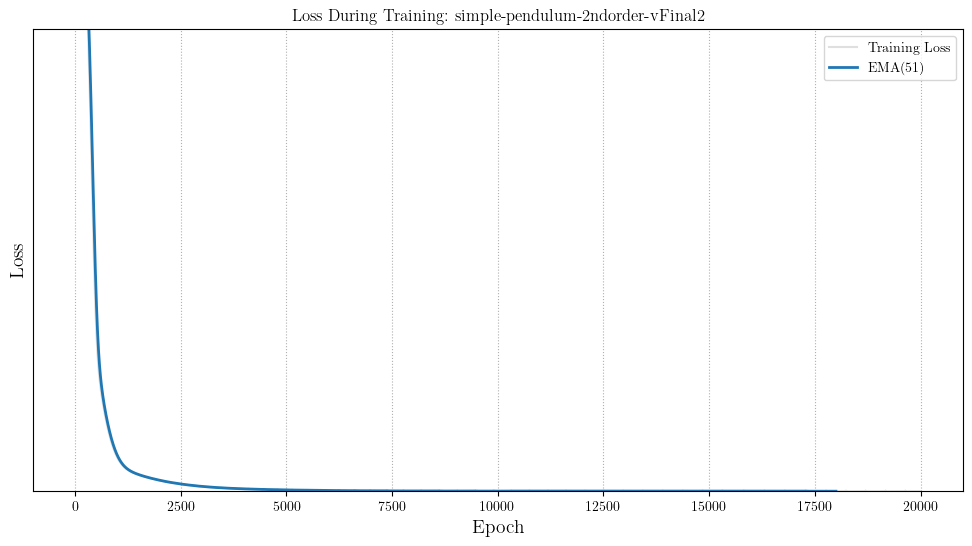

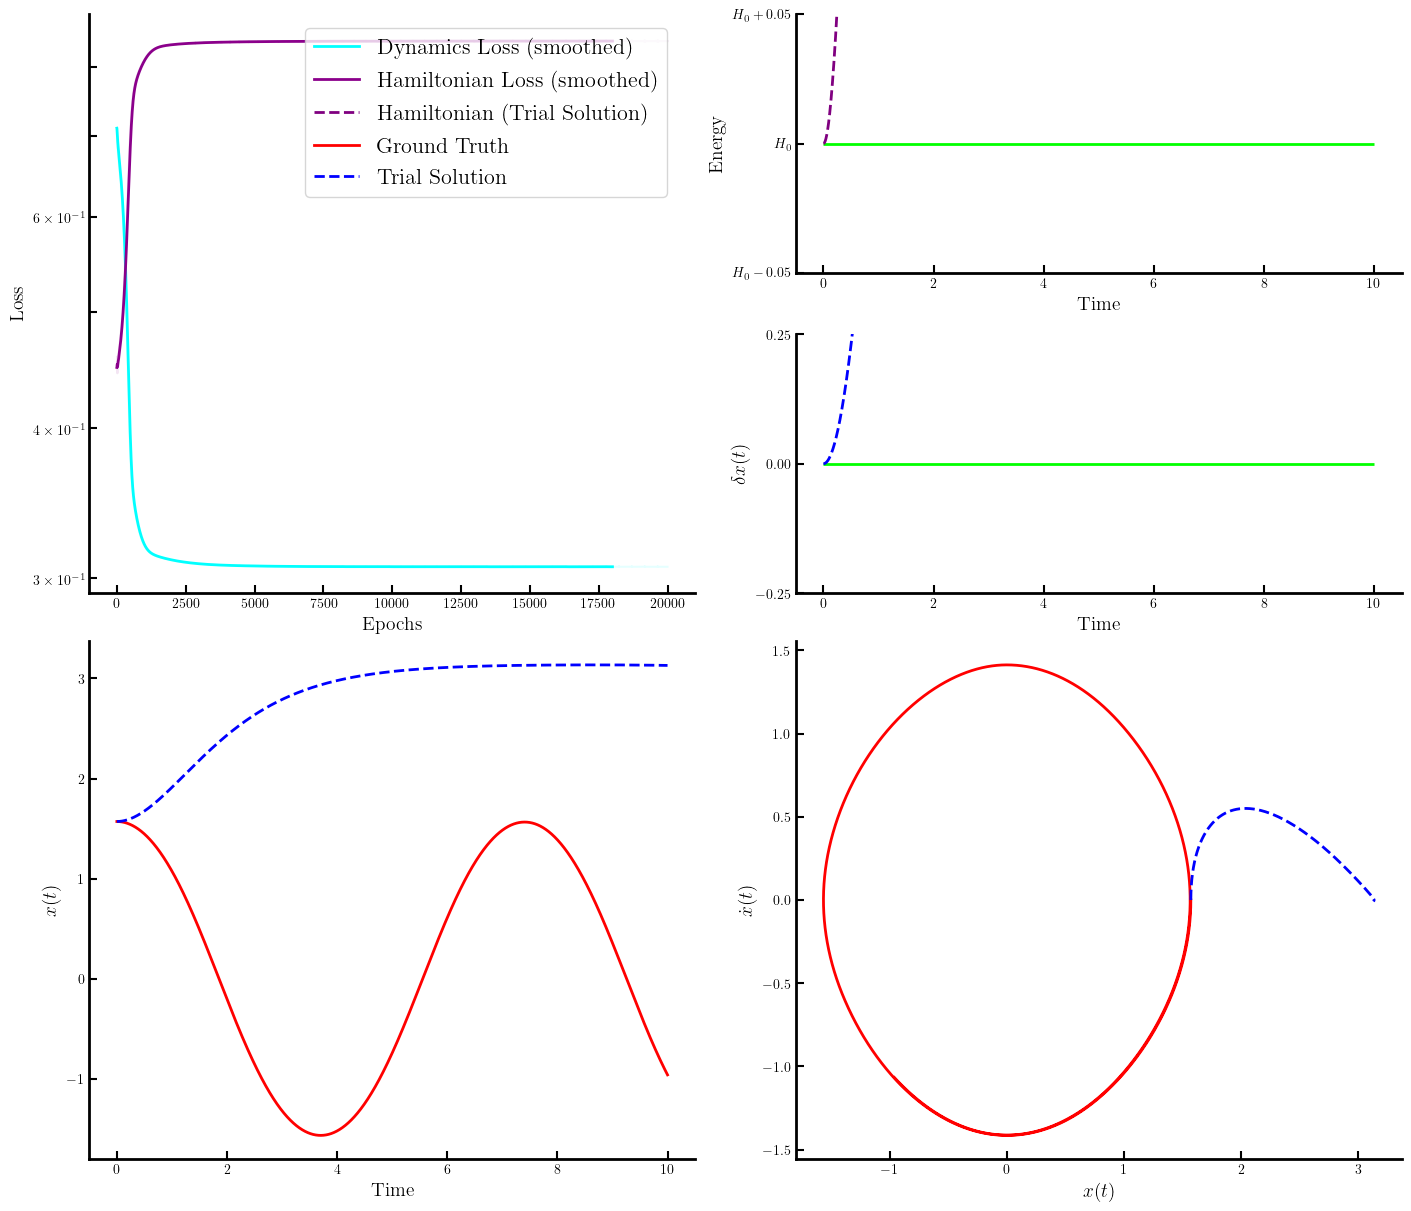

  0%|                                         | 1/20000 [00:00<46:14,  7.21it/s]

4492.818730401887


  1%|▏                                      | 102/20000 [00:11<35:11,  9.42it/s]

4288.019846903156


  1%|▍                                      | 202/20000 [00:22<36:35,  9.02it/s]

4209.546296937567


  2%|▌                                      | 302/20000 [00:33<34:57,  9.39it/s]

4134.786344900682


  2%|▊                                      | 402/20000 [00:44<35:14,  9.27it/s]

4092.1914223649114


  3%|▉                                      | 502/20000 [00:55<34:35,  9.40it/s]

4075.4840307699533


  3%|█▏                                     | 602/20000 [01:06<36:15,  8.92it/s]

4062.683225136045


  4%|█▎                                     | 701/20000 [01:16<34:21,  9.36it/s]

4048.937544196746


  4%|█▌                                     | 802/20000 [01:27<34:29,  9.28it/s]

4033.671054555428


  5%|█▊                                     | 902/20000 [01:38<35:05,  9.07it/s]

4016.474518381793


  5%|█▉                                    | 1002/20000 [01:49<33:25,  9.47it/s]

3997.002590866467


  6%|██                                    | 1102/20000 [02:01<33:12,  9.49it/s]

3975.1592656337693


  6%|██▎                                   | 1202/20000 [02:12<34:26,  9.10it/s]

3951.387856207052


  7%|██▍                                   | 1302/20000 [02:22<33:19,  9.35it/s]

3926.943028601071


  7%|██▋                                   | 1402/20000 [02:33<33:36,  9.22it/s]

3903.7872594526307


  8%|██▊                                   | 1502/20000 [02:44<33:10,  9.29it/s]

3883.7418694587577


  8%|███                                   | 1602/20000 [02:55<32:02,  9.57it/s]

3867.2998326252737


  9%|███▏                                  | 1702/20000 [03:06<33:22,  9.14it/s]

3853.9791447186444


  9%|███▍                                  | 1802/20000 [03:17<32:44,  9.26it/s]

3842.0751936200995


 10%|███▌                                  | 1901/20000 [03:28<31:51,  9.47it/s]

3830.910497620797


 10%|███▊                                  | 2002/20000 [03:39<31:15,  9.59it/s]

3821.722218260882


 11%|███▉                                  | 2101/20000 [03:50<36:32,  8.16it/s]

3816.5767016569794


 11%|████▏                                 | 2202/20000 [04:01<32:50,  9.03it/s]

3814.697511771942


 12%|████▎                                 | 2302/20000 [04:12<31:42,  9.30it/s]

3813.6324247644407


 12%|████▌                                 | 2402/20000 [04:23<30:52,  9.50it/s]

3813.0703975553506


 13%|████▊                                 | 2502/20000 [04:34<43:15,  6.74it/s]

3812.7337859735976


 13%|████▉                                 | 2602/20000 [04:45<31:32,  9.19it/s]

3812.458929786504


 14%|█████▏                                | 2702/20000 [04:56<31:09,  9.25it/s]

3812.2700802174513


 14%|█████▎                                | 2802/20000 [05:07<31:07,  9.21it/s]

3812.112974713292


 15%|█████▌                                | 2902/20000 [05:18<30:41,  9.28it/s]

3811.982841453894


 15%|█████▋                                | 3002/20000 [05:29<31:11,  9.08it/s]

3811.8619023577667


 16%|█████▉                                | 3102/20000 [05:40<29:32,  9.53it/s]

3811.74387366277


 16%|██████                                | 3202/20000 [05:51<31:04,  9.01it/s]

3811.6334130575633


 17%|██████▎                               | 3302/20000 [06:02<29:36,  9.40it/s]

3811.520723015293


 17%|██████▍                               | 3402/20000 [06:13<29:17,  9.45it/s]

3811.408750826924


 18%|██████▋                               | 3502/20000 [06:23<27:36,  9.96it/s]

3811.2941850900156


 18%|██████▊                               | 3602/20000 [06:34<28:08,  9.71it/s]

3811.1844619110816


 19%|███████                               | 3702/20000 [06:44<28:21,  9.58it/s]

3811.0732952452445


 19%|███████▏                              | 3802/20000 [06:55<28:44,  9.39it/s]

3810.959153359823


 20%|███████▍                              | 3901/20000 [07:05<26:16, 10.21it/s]

3811.6054452100475


 20%|███████▌                              | 4002/20000 [07:16<28:39,  9.30it/s]

3810.734170221615


 21%|███████▊                              | 4102/20000 [07:27<28:14,  9.38it/s]

3810.6235851156034


 21%|███████▉                              | 4202/20000 [07:38<28:55,  9.10it/s]

3810.510289754642


 22%|████████▏                             | 4302/20000 [07:49<28:15,  9.26it/s]

3810.3943645135537


 22%|████████▎                             | 4402/20000 [08:00<28:28,  9.13it/s]

3810.2821820147747


 23%|████████▌                             | 4502/20000 [08:11<27:48,  9.29it/s]

3810.1734005944863


 23%|████████▋                             | 4602/20000 [08:22<27:22,  9.38it/s]

3810.062568380291


 24%|████████▉                             | 4702/20000 [08:32<25:49,  9.87it/s]

3809.949633258899


 24%|█████████                             | 4802/20000 [08:43<26:49,  9.44it/s]

3809.947824210586


 25%|█████████▎                            | 4902/20000 [08:54<28:17,  8.89it/s]

3809.7317087022784


 25%|█████████▌                            | 5002/20000 [09:05<27:16,  9.16it/s]

3809.6250490337134


 26%|█████████▋                            | 5102/20000 [09:15<26:10,  9.49it/s]

3809.5168559832277


 26%|█████████▉                            | 5202/20000 [09:26<27:12,  9.06it/s]

3809.503455974287


 27%|██████████                            | 5302/20000 [09:37<26:02,  9.41it/s]

3809.3070912845674


 27%|██████████▎                           | 5402/20000 [09:48<26:35,  9.15it/s]

3809.2063640905735


 28%|██████████▍                           | 5502/20000 [10:00<26:29,  9.12it/s]

3809.1046914667922


 28%|██████████▋                           | 5602/20000 [10:10<25:15,  9.50it/s]

3809.0022502808642


 29%|██████████▊                           | 5702/20000 [10:21<25:04,  9.50it/s]

3808.907351731162


 29%|███████████                           | 5802/20000 [10:32<25:30,  9.28it/s]

3808.8140585825495


 30%|███████████▏                          | 5902/20000 [10:43<24:38,  9.53it/s]

3808.720432758715


 30%|███████████▍                          | 6002/20000 [10:53<24:53,  9.38it/s]

3808.6266262202053


 31%|███████████▌                          | 6102/20000 [11:04<24:29,  9.46it/s]

3808.5392072319555


 31%|███████████▊                          | 6202/20000 [11:15<23:26,  9.81it/s]

3808.455127031233


 32%|███████████▉                          | 6302/20000 [11:25<23:12,  9.84it/s]

3808.3713327413866


 32%|████████████▏                         | 6402/20000 [11:36<24:12,  9.36it/s]

3808.2878764478824


 33%|████████████▎                         | 6502/20000 [11:46<24:00,  9.37it/s]

3808.219619869724


 33%|████████████▌                         | 6602/20000 [11:57<25:05,  8.90it/s]

3808.133735323695


 34%|████████████▋                         | 6702/20000 [12:08<24:02,  9.22it/s]

3808.0606617018157


 34%|████████████▉                         | 6802/20000 [12:19<23:16,  9.45it/s]

3807.9883462756807


 35%|█████████████                         | 6902/20000 [12:30<23:58,  9.10it/s]

3807.9173186611024


 35%|█████████████▎                        | 7002/20000 [12:40<23:47,  9.10it/s]

3807.8530234489995


 36%|█████████████▍                        | 7102/20000 [12:52<22:44,  9.45it/s]

3807.7906102415727


 36%|█████████████▋                        | 7202/20000 [13:03<22:20,  9.55it/s]

3807.729401924112


 37%|█████████████▊                        | 7301/20000 [13:13<22:30,  9.41it/s]

3807.6694364197315


 37%|██████████████                        | 7402/20000 [13:24<21:40,  9.69it/s]

3807.6160273059877


 38%|██████████████▎                       | 7502/20000 [13:35<21:51,  9.53it/s]

3807.562303752229


 38%|██████████████▍                       | 7601/20000 [13:46<21:45,  9.50it/s]

3807.5119086725545


 39%|██████████████▋                       | 7702/20000 [13:56<21:32,  9.52it/s]

3807.462867853778


 39%|██████████████▊                       | 7802/20000 [14:07<21:24,  9.50it/s]

3807.4425999311607


 40%|███████████████                       | 7902/20000 [14:17<21:40,  9.30it/s]

3807.374002564263


 40%|███████████████▏                      | 8001/20000 [14:28<21:34,  9.27it/s]

3807.333383766594


 41%|███████████████▍                      | 8102/20000 [14:39<21:56,  9.04it/s]

3807.2940893078976


 41%|███████████████▌                      | 8202/20000 [14:49<21:10,  9.29it/s]

3807.256194878017


 42%|███████████████▊                      | 8302/20000 [15:00<21:06,  9.23it/s]

3807.222235545709


 42%|███████████████▉                      | 8402/20000 [15:10<19:24,  9.96it/s]

3807.190215088826


 43%|████████████████▏                     | 8502/20000 [15:21<20:43,  9.25it/s]

3807.159341659679


 43%|████████████████▎                     | 8602/20000 [15:32<20:21,  9.33it/s]

3807.12963694142


 44%|████████████████▌                     | 8702/20000 [15:43<20:20,  9.26it/s]

3807.397663943919


 44%|████████████████▋                     | 8801/20000 [15:53<21:19,  8.75it/s]

3807.076344714218


 45%|████████████████▉                     | 8902/20000 [16:04<19:06,  9.68it/s]

3807.052110578931


 45%|█████████████████                     | 9002/20000 [16:15<20:42,  8.85it/s]

3807.0287617040653


 46%|█████████████████▎                    | 9101/20000 [16:25<17:46, 10.22it/s]

3807.006286970001


 46%|█████████████████▍                    | 9202/20000 [16:37<19:40,  9.15it/s]

3806.993137219618


 47%|█████████████████▋                    | 9302/20000 [16:47<18:18,  9.74it/s]

3806.9661425098484


 47%|█████████████████▊                    | 9402/20000 [16:58<18:30,  9.54it/s]

3806.947445763623


 48%|██████████████████                    | 9502/20000 [17:08<18:14,  9.59it/s]

3806.9293159080703


 48%|██████████████████▏                   | 9602/20000 [17:19<18:34,  9.33it/s]

3806.911731617537


 49%|██████████████████▍                   | 9702/20000 [17:29<18:19,  9.36it/s]

3806.8958314575925


 49%|██████████████████▌                   | 9802/20000 [17:40<17:08,  9.92it/s]

3806.879743206131


 50%|██████████████████▊                   | 9902/20000 [17:50<17:02,  9.88it/s]

3806.86448631532


 50%|██████████████████▌                  | 10001/20000 [18:00<17:53,  9.31it/s]

3806.849538047093


 51%|██████████████████▋                  | 10102/20000 [18:11<17:22,  9.49it/s]

3807.8467435045773


 51%|██████████████████▊                  | 10202/20000 [18:22<17:26,  9.36it/s]

3806.821235573234


 52%|███████████████████                  | 10301/20000 [18:33<17:02,  9.48it/s]

3806.8078245627557


 52%|███████████████████▏                 | 10402/20000 [18:44<16:56,  9.44it/s]

3806.794581174924


 53%|███████████████████▍                 | 10502/20000 [18:55<16:38,  9.52it/s]

3806.7814703629465


 53%|███████████████████▌                 | 10602/20000 [19:05<15:39, 10.00it/s]

3806.781012665558


 54%|███████████████████▊                 | 10702/20000 [19:16<16:30,  9.39it/s]

3806.756305844942


 54%|███████████████████▉                 | 10802/20000 [19:27<16:35,  9.24it/s]

3806.7441405052896


 55%|████████████████████▏                | 10902/20000 [19:38<15:57,  9.50it/s]

3806.732026259163


 55%|████████████████████▎                | 11002/20000 [19:48<15:55,  9.42it/s]

3806.7199490365583


 56%|████████████████████▌                | 11102/20000 [19:59<15:59,  9.28it/s]

3806.7104518744563


 56%|████████████████████▋                | 11202/20000 [20:10<15:34,  9.41it/s]

3806.696686012524


 57%|████████████████████▉                | 11302/20000 [20:21<15:06,  9.59it/s]

3806.6853187500874


 57%|█████████████████████                | 11402/20000 [20:32<15:29,  9.25it/s]

3806.673947823032


 58%|█████████████████████▎               | 11502/20000 [20:42<14:46,  9.58it/s]

3806.6625716801045


 58%|█████████████████████▍               | 11602/20000 [20:53<14:31,  9.63it/s]

3806.6782827840007


 59%|█████████████████████▋               | 11702/20000 [21:03<14:24,  9.60it/s]

3806.6405153050764


 59%|█████████████████████▊               | 11802/20000 [21:14<14:24,  9.48it/s]

3806.629733123118


 60%|██████████████████████               | 11902/20000 [21:25<14:23,  9.38it/s]

3806.618933859237


 60%|██████████████████████▏              | 12001/20000 [21:35<13:46,  9.68it/s]

3806.608118256412


 61%|██████████████████████▍              | 12102/20000 [21:46<13:48,  9.54it/s]

3806.6174800783992


 61%|██████████████████████▌              | 12202/20000 [21:57<13:41,  9.49it/s]

3806.5871923769337


 62%|██████████████████████▊              | 12302/20000 [22:09<13:54,  9.22it/s]

3806.5769680475823


 62%|██████████████████████▉              | 12402/20000 [22:20<13:10,  9.61it/s]

3806.5667241815945


 63%|███████████████████████▏             | 12502/20000 [22:30<13:09,  9.50it/s]

3806.556462797577


 63%|███████████████████████▎             | 12602/20000 [22:41<13:08,  9.39it/s]

3806.561315027041


 64%|███████████████████████▍             | 12702/20000 [22:51<12:59,  9.36it/s]

3806.5366262266302


 64%|███████████████████████▋             | 12801/20000 [23:02<12:33,  9.56it/s]

3806.526938764383


 65%|███████████████████████▊             | 12902/20000 [23:13<12:27,  9.49it/s]

3806.5172329667234


 65%|████████████████████████             | 13002/20000 [23:23<11:53,  9.81it/s]

3806.507511459553


 66%|████████████████████████▏            | 13102/20000 [23:34<11:44,  9.79it/s]

3806.498224780805


 66%|████████████████████████▍            | 13202/20000 [23:46<12:09,  9.32it/s]

3806.488897259085


 67%|████████████████████████▌            | 13302/20000 [23:57<12:13,  9.14it/s]

3806.4797646458046


 67%|████████████████████████▊            | 13402/20000 [24:07<11:38,  9.44it/s]

3806.470612128334


 68%|████████████████████████▉            | 13502/20000 [24:18<11:24,  9.49it/s]

3806.46154162942


 68%|█████████████████████████▏           | 13602/20000 [24:29<11:42,  9.11it/s]

3806.4526496939616


 69%|█████████████████████████▎           | 13702/20000 [24:39<10:42,  9.80it/s]

3806.4440493624356


 69%|█████████████████████████▌           | 13802/20000 [24:50<10:46,  9.59it/s]

3806.4354531525637


 70%|█████████████████████████▋           | 13902/20000 [25:01<10:34,  9.61it/s]

3806.426835190247


 70%|█████████████████████████▉           | 14002/20000 [25:11<10:27,  9.56it/s]

3806.511307592409


 71%|██████████████████████████           | 14102/20000 [25:22<10:35,  9.27it/s]

3806.4101312737284


 71%|██████████████████████████▎          | 14202/20000 [25:33<09:47,  9.87it/s]

3806.4020657564292


 72%|██████████████████████████▍          | 14302/20000 [25:44<09:56,  9.55it/s]

3806.393974086567


 72%|██████████████████████████▋          | 14402/20000 [25:54<09:37,  9.70it/s]

3806.3858562144383


 73%|██████████████████████████▊          | 14502/20000 [26:05<10:19,  8.87it/s]

3806.3780797005975


 73%|███████████████████████████          | 14602/20000 [26:17<10:14,  8.78it/s]

3806.370427432058


 74%|███████████████████████████▏         | 14702/20000 [26:29<09:23,  9.40it/s]

3806.3628292966496


 74%|███████████████████████████▍         | 14802/20000 [26:40<09:01,  9.60it/s]

3806.355192801557


 75%|███████████████████████████▌         | 14902/20000 [26:51<09:23,  9.05it/s]

3806.3792493043284


 75%|███████████████████████████▊         | 15002/20000 [27:02<09:42,  8.59it/s]

3806.3404718942015


 76%|███████████████████████████▉         | 15102/20000 [27:13<09:28,  8.62it/s]

3806.333366925308


 76%|████████████████████████████         | 15202/20000 [27:25<08:26,  9.47it/s]

3806.32620931116


 77%|████████████████████████████▎        | 15302/20000 [27:36<08:21,  9.37it/s]

3806.3189973222825


 77%|████████████████████████████▍        | 15402/20000 [27:46<08:04,  9.49it/s]

3806.312511639809


 78%|████████████████████████████▋        | 15502/20000 [27:57<08:23,  8.93it/s]

3806.3053322229503


 78%|████████████████████████████▊        | 15602/20000 [28:08<07:59,  9.18it/s]

3806.298594541544


 79%|█████████████████████████████        | 15702/20000 [28:18<07:12,  9.95it/s]

3806.2917805013185


 79%|█████████████████████████████▏       | 15802/20000 [28:29<07:30,  9.31it/s]

3806.2914139204972


 80%|█████████████████████████████▍       | 15902/20000 [28:40<06:50,  9.98it/s]

3806.278525246965


 80%|█████████████████████████████▌       | 16002/20000 [28:50<06:31, 10.22it/s]

3806.2721244357763


 81%|█████████████████████████████▊       | 16102/20000 [29:00<06:52,  9.46it/s]

3806.265624680785


 81%|█████████████████████████████▉       | 16202/20000 [29:10<06:28,  9.77it/s]

3806.2590310799696


 82%|██████████████████████████████▏      | 16302/20000 [29:21<06:36,  9.33it/s]

3806.2528796942042


 82%|██████████████████████████████▎      | 16402/20000 [29:31<06:15,  9.57it/s]

3806.2465208332924


 83%|██████████████████████████████▌      | 16502/20000 [29:42<06:01,  9.69it/s]

3806.240247212027


 83%|██████████████████████████████▋      | 16602/20000 [29:53<06:04,  9.32it/s]

3806.2338288753763


 84%|██████████████████████████████▉      | 16702/20000 [30:03<05:57,  9.23it/s]

3806.2347833700524


 84%|███████████████████████████████      | 16802/20000 [30:15<05:46,  9.23it/s]

3806.2213645189836


 85%|███████████████████████████████▎     | 16902/20000 [30:26<05:21,  9.64it/s]

3806.2152041510617


 85%|███████████████████████████████▍     | 17002/20000 [30:36<05:03,  9.89it/s]

3806.2088511936913


 86%|███████████████████████████████▋     | 17102/20000 [30:47<05:07,  9.43it/s]

3806.22451846798


 86%|███████████████████████████████▊     | 17202/20000 [30:57<04:52,  9.58it/s]

3806.1961260437943


 87%|████████████████████████████████     | 17302/20000 [31:08<04:31,  9.93it/s]

3806.189852790516


 87%|████████████████████████████████▏    | 17402/20000 [31:18<04:37,  9.37it/s]

3806.1833909009083


 88%|████████████████████████████████▍    | 17502/20000 [31:29<04:32,  9.17it/s]

3806.1766363483625


 88%|████████████████████████████████▌    | 17602/20000 [31:40<04:12,  9.51it/s]

3806.175388894198


 89%|████████████████████████████████▋    | 17702/20000 [31:50<04:05,  9.36it/s]

3806.163220916017


 89%|████████████████████████████████▉    | 17802/20000 [32:01<03:59,  9.18it/s]

3806.156341396085


 90%|█████████████████████████████████    | 17902/20000 [32:12<03:42,  9.44it/s]

3806.1490463920854


 90%|█████████████████████████████████▎   | 18002/20000 [32:23<03:24,  9.77it/s]

3807.044193794597


 91%|█████████████████████████████████▍   | 18102/20000 [32:34<03:23,  9.34it/s]

3806.1338380033835


 91%|█████████████████████████████████▋   | 18202/20000 [32:44<03:09,  9.49it/s]

3806.1260702159216


 92%|█████████████████████████████████▊   | 18302/20000 [32:56<02:55,  9.68it/s]

3806.1176847802185


 92%|██████████████████████████████████   | 18402/20000 [33:06<02:49,  9.42it/s]

3806.1085582122473


 93%|██████████████████████████████████▏  | 18502/20000 [33:17<02:43,  9.14it/s]

3806.099603101282


 93%|██████████████████████████████████▍  | 18602/20000 [33:27<02:28,  9.41it/s]

3806.0894637080064


 94%|██████████████████████████████████▌  | 18702/20000 [33:38<02:17,  9.46it/s]

3806.0789772093053


 94%|██████████████████████████████████▊  | 18801/20000 [33:49<02:01,  9.87it/s]

3806.067238063202


 95%|██████████████████████████████████▉  | 18902/20000 [34:00<01:55,  9.49it/s]

3806.0539451118984


 95%|███████████████████████████████████▏ | 19002/20000 [34:11<01:44,  9.55it/s]

3806.0403835461266


 96%|███████████████████████████████████▎ | 19101/20000 [34:21<01:39,  9.05it/s]

3806.024440016219


 96%|███████████████████████████████████▌ | 19202/20000 [34:32<01:27,  9.16it/s]

3806.006690068207


 97%|███████████████████████████████████▋ | 19302/20000 [34:43<01:14,  9.39it/s]

3805.985600126354


 97%|███████████████████████████████████▉ | 19402/20000 [34:53<01:03,  9.39it/s]

3805.9600085002357


 98%|████████████████████████████████████ | 19502/20000 [35:04<00:51,  9.61it/s]

3805.9306706990183


 98%|████████████████████████████████████▎| 19602/20000 [35:15<00:40,  9.83it/s]

3805.8953238766326


 99%|████████████████████████████████████▍| 19702/20000 [35:26<00:32,  9.27it/s]

3805.849624847372


 99%|████████████████████████████████████▋| 19802/20000 [35:37<00:21,  9.33it/s]

3805.7873762237673


100%|████████████████████████████████████▊| 19901/20000 [35:48<00:10,  9.78it/s]

3805.6967040215927


100%|█████████████████████████████████████| 20000/20000 [35:58<00:00,  9.27it/s]


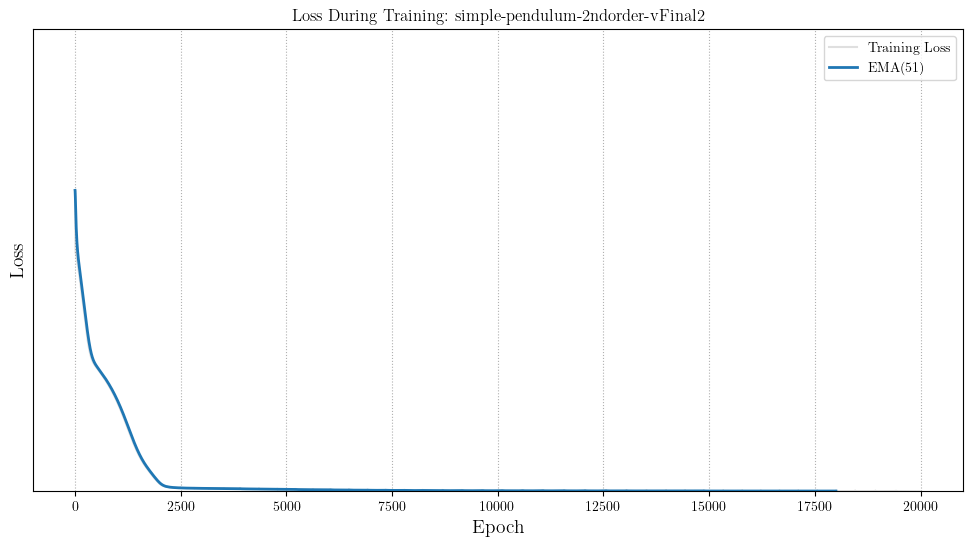

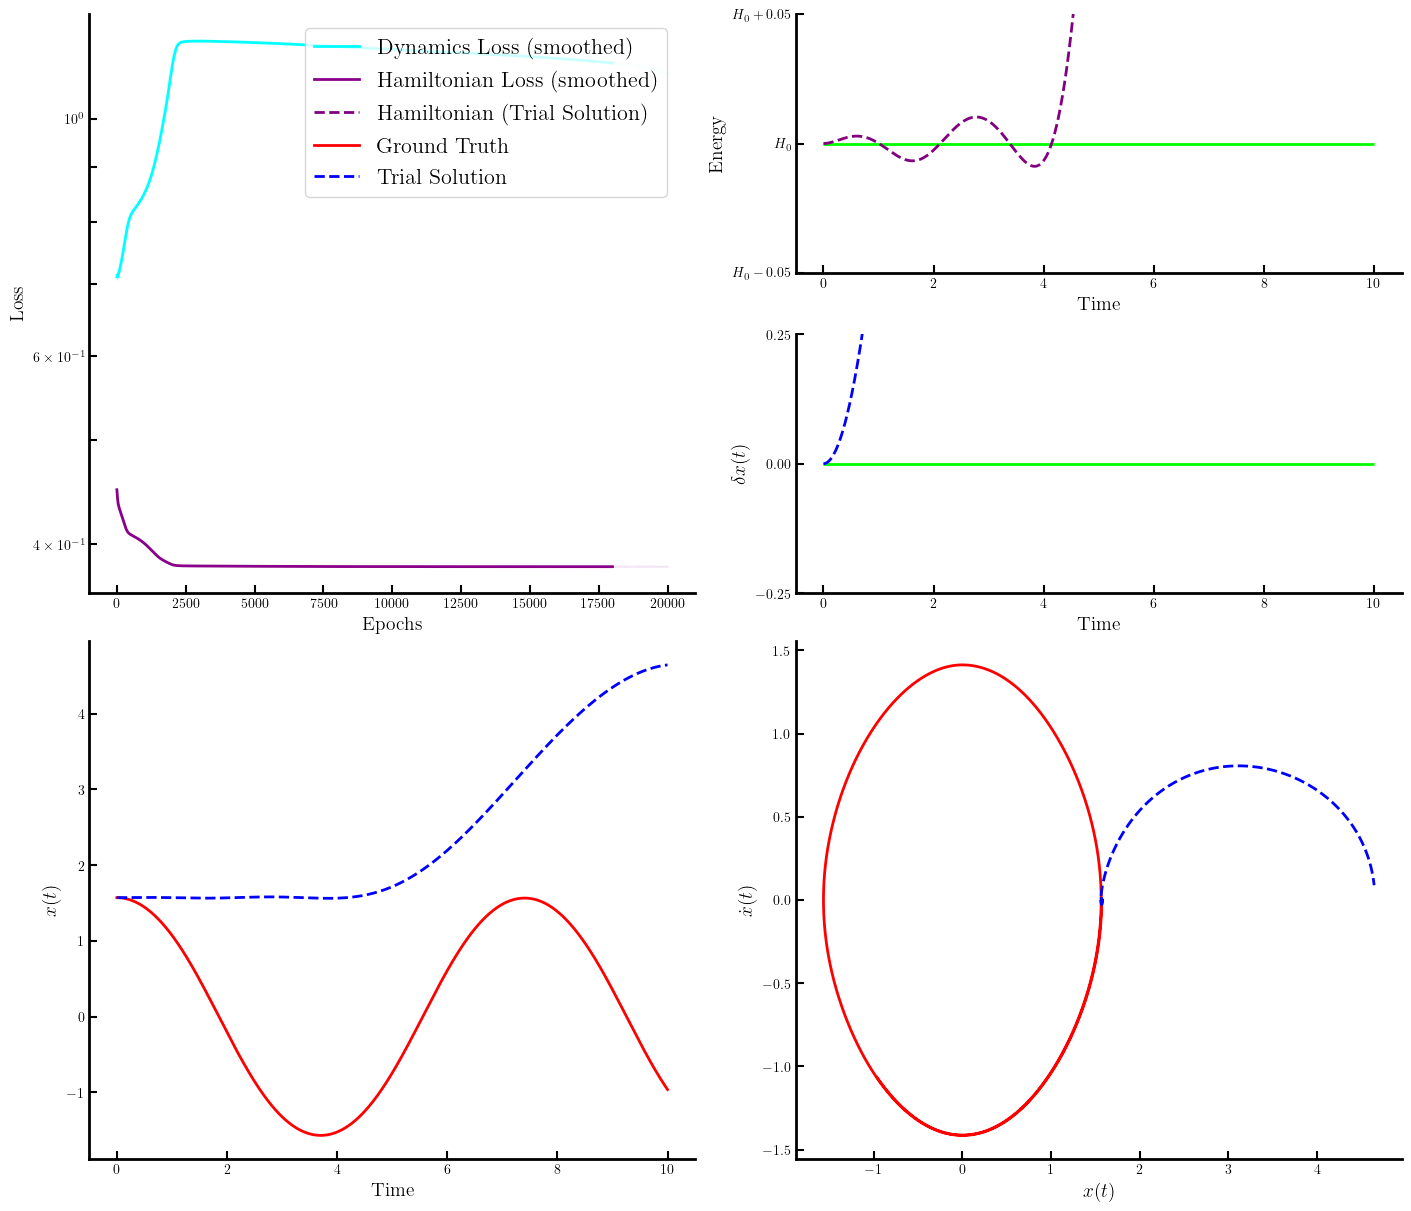

  0%|                                         | 1/20000 [00:00<49:06,  6.79it/s]

11589.741929947962


  1%|▏                                      | 102/20000 [00:11<37:49,  8.77it/s]

8808.027724531963


  1%|▍                                      | 202/20000 [00:22<35:54,  9.19it/s]

8761.388845999587


  2%|▌                                      | 302/20000 [00:34<36:04,  9.10it/s]

8731.974589885594


  2%|▊                                      | 402/20000 [00:45<35:59,  9.07it/s]

8696.275276121183


  3%|▉                                      | 502/20000 [00:56<35:41,  9.11it/s]

8652.122473101921


  3%|█▏                                     | 602/20000 [01:07<35:11,  9.19it/s]

8595.722779871223


  4%|█▎                                     | 702/20000 [01:18<35:08,  9.15it/s]

8521.436131405702


  4%|█▌                                     | 802/20000 [01:30<35:17,  9.07it/s]

8422.403543576782


  5%|█▊                                     | 902/20000 [01:41<35:26,  8.98it/s]

8294.21264619657


  5%|█▉                                    | 1002/20000 [01:52<34:39,  9.14it/s]

8146.4379123456265


  6%|██                                    | 1102/20000 [02:03<35:37,  8.84it/s]

8015.980858687632


  6%|██▎                                   | 1202/20000 [02:16<36:14,  8.65it/s]

7926.5536032455275


  7%|██▍                                   | 1302/20000 [02:27<34:19,  9.08it/s]

7845.077332993675


  7%|██▋                                   | 1402/20000 [02:38<34:05,  9.09it/s]

7721.9490176546415


  8%|██▊                                   | 1502/20000 [02:49<33:57,  9.08it/s]

7458.892210783914


  8%|███                                   | 1601/20000 [03:00<41:04,  7.47it/s]

6848.275026781399


  9%|███▏                                  | 1702/20000 [03:12<34:27,  8.85it/s]

5756.050156807096


  9%|███▍                                  | 1802/20000 [03:23<33:56,  8.93it/s]

4408.077472744365


 10%|███▌                                  | 1902/20000 [03:35<32:48,  9.19it/s]

4163.563739760042


 10%|███▊                                  | 2002/20000 [03:46<33:21,  8.99it/s]

4132.945155961436


 11%|███▉                                  | 2102/20000 [03:57<32:26,  9.20it/s]

4103.308217367023


 11%|████▏                                 | 2202/20000 [04:08<32:13,  9.20it/s]

4073.5087109078695


 12%|████▎                                 | 2302/20000 [04:19<32:13,  9.15it/s]

4043.3676509367197


 12%|████▌                                 | 2402/20000 [04:31<32:44,  8.96it/s]

4012.7883633466377


 13%|████▊                                 | 2502/20000 [04:42<32:10,  9.06it/s]

3981.710359476327


 13%|████▉                                 | 2602/20000 [04:53<32:08,  9.02it/s]

3950.085148125303


 14%|█████▏                                | 2702/20000 [05:05<31:15,  9.22it/s]

3917.8614573728255


 14%|█████▎                                | 2802/20000 [05:16<32:31,  8.81it/s]

3884.9771030948177


 15%|█████▌                                | 2902/20000 [05:28<31:21,  9.09it/s]

3851.932227743666


 15%|█████▋                                | 3002/20000 [05:39<31:30,  8.99it/s]

3819.1962047747156


 16%|█████▉                                | 3102/20000 [05:50<30:58,  9.09it/s]

3785.6228874612566


 16%|██████                                | 3202/20000 [06:01<32:51,  8.52it/s]

3751.1543283947003


 17%|██████▎                               | 3302/20000 [06:13<30:44,  9.05it/s]

3715.782782437663


 17%|██████▍                               | 3402/20000 [06:24<30:36,  9.04it/s]

3680.32865423188


 18%|██████▋                               | 3502/20000 [06:35<30:05,  9.14it/s]

3644.845836104765


 18%|██████▊                               | 3602/20000 [06:46<30:18,  9.02it/s]

3609.4033947798534


 19%|███████                               | 3702/20000 [06:58<30:47,  8.82it/s]

3573.341549419688


 19%|███████▏                              | 3802/20000 [07:09<29:46,  9.07it/s]

3536.8146061024654


 20%|███████▍                              | 3902/20000 [07:20<30:00,  8.94it/s]

3501.7440301390125


 20%|███████▌                              | 4002/20000 [07:31<30:22,  8.78it/s]

3467.5825086862874


 21%|███████▊                              | 4102/20000 [07:43<30:39,  8.64it/s]

3433.659487408858


 21%|███████▉                              | 4202/20000 [07:54<28:27,  9.25it/s]

3401.0033838593013


 22%|████████▏                             | 4302/20000 [08:06<28:59,  9.02it/s]

3371.0597028251304


 22%|████████▎                             | 4402/20000 [08:17<31:54,  8.15it/s]

3342.2316832229662


 23%|████████▌                             | 4501/20000 [08:28<31:34,  8.18it/s]

3315.565450945182


 23%|████████▋                             | 4602/20000 [08:39<28:44,  8.93it/s]

3291.7342261606345


 24%|████████▉                             | 4702/20000 [08:51<28:44,  8.87it/s]

3269.1399893402477


 24%|█████████                             | 4802/20000 [09:02<28:00,  9.05it/s]

3248.660513735981


 25%|█████████▎                            | 4902/20000 [09:13<27:11,  9.25it/s]

3229.633413175541


 25%|█████████▌                            | 5002/20000 [09:24<27:35,  9.06it/s]

3210.606077449936


 26%|█████████▋                            | 5102/20000 [09:36<27:11,  9.13it/s]

3192.02176852649


 26%|█████████▉                            | 5202/20000 [09:47<28:01,  8.80it/s]

3171.331490067354


 27%|██████████                            | 5302/20000 [09:58<27:36,  8.88it/s]

3147.348907634292


 27%|██████████▎                           | 5402/20000 [10:10<26:04,  9.33it/s]

3115.3928075348967


 28%|██████████▍                           | 5502/20000 [10:22<26:56,  8.97it/s]

3067.8327587932968


 28%|██████████▋                           | 5602/20000 [10:33<25:54,  9.26it/s]

2978.7310504015513


 29%|██████████▊                           | 5702/20000 [10:44<26:57,  8.84it/s]

2793.323376392951


 29%|███████████                           | 5802/20000 [10:55<26:09,  9.05it/s]

2394.374867814585


 30%|███████████▏                          | 5902/20000 [11:06<25:57,  9.05it/s]

1849.8933502572406


 30%|███████████▍                          | 6002/20000 [11:17<26:10,  8.92it/s]

1427.8160701732363


 31%|███████████▌                          | 6102/20000 [11:29<27:54,  8.30it/s]

1217.542451457071


 31%|███████████▊                          | 6202/20000 [11:40<25:25,  9.04it/s]

1134.8562437537958


 32%|███████████▉                          | 6302/20000 [11:51<25:11,  9.06it/s]

1083.4408004803363


 32%|████████████▏                         | 6402/20000 [12:02<28:13,  8.03it/s]

1036.8649570802047


 33%|████████████▎                         | 6502/20000 [12:14<26:47,  8.40it/s]

991.1968028283032


 33%|████████████▌                         | 6602/20000 [12:26<25:53,  8.63it/s]

952.3295359440679


 34%|████████████▋                         | 6702/20000 [12:37<24:46,  8.95it/s]

905.900661061508


 34%|████████████▉                         | 6802/20000 [12:48<24:13,  9.08it/s]

867.299095368679


 35%|█████████████                         | 6901/20000 [12:59<29:03,  7.51it/s]

830.9968432559795


 35%|█████████████▎                        | 7002/20000 [13:11<24:10,  8.96it/s]

797.6622340172258


 36%|█████████████▍                        | 7102/20000 [13:22<23:35,  9.11it/s]

770.2010906883618


 36%|█████████████▋                        | 7202/20000 [13:34<24:06,  8.85it/s]

746.2941459111316


 37%|█████████████▊                        | 7302/20000 [13:45<22:37,  9.35it/s]

725.4006967877956


 37%|██████████████                        | 7402/20000 [13:56<22:59,  9.14it/s]

707.3704957386815


 38%|██████████████▎                       | 7502/20000 [14:08<23:16,  8.95it/s]

693.0055063274799


 38%|██████████████▍                       | 7602/20000 [14:19<23:43,  8.71it/s]

681.0110143986556


 39%|██████████████▋                       | 7702/20000 [14:31<22:02,  9.30it/s]

670.4439293238981


 39%|██████████████▊                       | 7802/20000 [14:42<21:57,  9.26it/s]

661.0212251046075


 40%|███████████████                       | 7902/20000 [14:53<22:39,  8.90it/s]

653.1319101620697


 40%|███████████████▏                      | 8002/20000 [15:04<22:17,  8.97it/s]

646.1575656893045


 41%|███████████████▍                      | 8102/20000 [15:16<22:33,  8.79it/s]

639.5399473684652


 41%|███████████████▌                      | 8201/20000 [15:27<23:09,  8.49it/s]

633.1700750275068


 42%|███████████████▊                      | 8302/20000 [15:39<22:05,  8.82it/s]

627.5642644695777


 42%|███████████████▉                      | 8402/20000 [15:50<21:59,  8.79it/s]

622.241501042668


 43%|████████████████▏                     | 8502/20000 [16:01<23:35,  8.12it/s]

616.9207269866488


 43%|████████████████▎                     | 8602/20000 [16:13<21:21,  8.89it/s]

611.6095685014484


 44%|████████████████▌                     | 8702/20000 [16:24<22:17,  8.45it/s]

606.8256241548221


 44%|████████████████▋                     | 8801/20000 [16:36<22:18,  8.36it/s]

602.0964573569653


 45%|████████████████▉                     | 8901/20000 [16:47<21:15,  8.70it/s]

597.2597106387373


 45%|█████████████████                     | 9002/20000 [17:00<21:50,  8.39it/s]

594.1963607101643


 46%|█████████████████▎                    | 9102/20000 [17:11<20:39,  8.80it/s]

588.0064594565983


 46%|█████████████████▍                    | 9202/20000 [17:22<20:15,  8.88it/s]

583.5434002218794


 47%|█████████████████▋                    | 9302/20000 [17:33<19:35,  9.10it/s]

578.9300586898694


 47%|█████████████████▊                    | 9402/20000 [17:44<19:23,  9.11it/s]

575.3199722775278


 48%|██████████████████                    | 9502/20000 [17:56<20:05,  8.71it/s]

570.1180060859109


 48%|██████████████████▏                   | 9602/20000 [18:07<19:57,  8.68it/s]

565.8220689827052


 49%|██████████████████▍                   | 9702/20000 [18:19<19:50,  8.65it/s]

561.3550254265016


 49%|██████████████████▌                   | 9802/20000 [18:30<18:52,  9.00it/s]

571.0285197447128


 50%|██████████████████▊                   | 9902/20000 [18:41<19:36,  8.58it/s]

552.6880367341662


 50%|██████████████████▌                  | 10002/20000 [18:53<19:09,  8.70it/s]

548.5142068097521


 51%|██████████████████▋                  | 10102/20000 [19:04<18:19,  9.01it/s]

544.15948792776


 51%|██████████████████▊                  | 10202/20000 [19:15<18:37,  8.76it/s]

539.6135425571822


 52%|███████████████████                  | 10302/20000 [19:28<17:59,  8.99it/s]

535.4577127801117


 52%|███████████████████▏                 | 10402/20000 [19:39<18:07,  8.83it/s]

531.3304430196799


 53%|███████████████████▍                 | 10502/20000 [19:51<17:32,  9.03it/s]

527.017914615838


 53%|███████████████████▌                 | 10602/20000 [20:02<18:05,  8.66it/s]

522.509025475616


 54%|███████████████████▊                 | 10702/20000 [20:13<17:50,  8.69it/s]

518.3306811415669


 54%|███████████████████▉                 | 10802/20000 [20:25<17:16,  8.87it/s]

514.2001738727089


 55%|████████████████████▏                | 10902/20000 [20:36<17:15,  8.78it/s]

509.88718270346067


 55%|████████████████████▎                | 11002/20000 [20:48<17:20,  8.65it/s]

505.37465329595716


 56%|████████████████████▌                | 11102/20000 [20:59<16:40,  8.90it/s]

501.24731687103565


 56%|████████████████████▋                | 11202/20000 [21:10<16:15,  9.02it/s]

497.10749063343314


 57%|████████████████████▉                | 11302/20000 [21:22<16:43,  8.67it/s]

492.7792607202498


 57%|█████████████████████                | 11402/20000 [21:34<16:21,  8.76it/s]

489.4539818174181


 58%|█████████████████████▎               | 11502/20000 [21:45<15:53,  8.92it/s]

484.2225920969869


 58%|█████████████████████▍               | 11602/20000 [21:57<15:30,  9.03it/s]

480.06441296870446


 59%|█████████████████████▋               | 11702/20000 [22:08<15:48,  8.75it/s]

475.7137605778784


 59%|█████████████████████▊               | 11802/20000 [22:20<15:35,  8.77it/s]

471.68844272655963


 60%|██████████████████████               | 11902/20000 [22:31<15:19,  8.81it/s]

467.32268205836505


 60%|██████████████████████▏              | 12002/20000 [22:42<14:56,  8.92it/s]

463.1581459048177


 61%|██████████████████████▍              | 12102/20000 [22:54<14:49,  8.87it/s]

458.8022896388038


 61%|██████████████████████▌              | 12202/20000 [23:05<14:28,  8.98it/s]

454.6848743377775


 62%|██████████████████████▊              | 12302/20000 [23:16<14:43,  8.71it/s]

450.6183929608163


 62%|██████████████████████▉              | 12401/20000 [23:28<14:21,  8.83it/s]

446.4453314717222


 63%|███████████████████████▏             | 12501/20000 [23:39<14:28,  8.63it/s]

442.1044091951894


 63%|███████████████████████▎             | 12602/20000 [23:51<13:49,  8.92it/s]

438.17040568136673


 64%|███████████████████████▍             | 12702/20000 [24:02<13:59,  8.69it/s]

434.174017858029


 64%|███████████████████████▋             | 12802/20000 [24:15<13:39,  8.79it/s]

429.9999525672143


 65%|███████████████████████▊             | 12902/20000 [24:26<13:10,  8.98it/s]

426.27220030478554


 65%|████████████████████████             | 13002/20000 [24:37<12:52,  9.06it/s]

422.0072850334137


 66%|████████████████████████▏            | 13102/20000 [24:49<12:37,  9.10it/s]

417.9986654511713


 66%|████████████████████████▍            | 13201/20000 [25:00<13:13,  8.57it/s]

413.81493560833405


 67%|████████████████████████▌            | 13302/20000 [25:11<12:43,  8.78it/s]

410.0048709843753


 67%|████████████████████████▊            | 13402/20000 [25:23<12:11,  9.02it/s]

406.2431009560962


 68%|████████████████████████▉            | 13502/20000 [25:34<12:08,  8.92it/s]

402.32675055598884


 68%|█████████████████████████▏           | 13602/20000 [25:45<12:03,  8.85it/s]

398.2443117624359


 69%|█████████████████████████▎           | 13702/20000 [25:57<11:40,  8.99it/s]

394.5134000253642


 69%|█████████████████████████▌           | 13801/20000 [26:08<11:31,  8.96it/s]

390.81470831337697


 70%|█████████████████████████▋           | 13902/20000 [26:20<11:41,  8.69it/s]

386.9634355469326


 70%|█████████████████████████▉           | 14002/20000 [26:31<11:20,  8.82it/s]

383.05264997661897


 71%|██████████████████████████           | 14102/20000 [26:43<11:07,  8.83it/s]

379.48263054154467


 71%|██████████████████████████▎          | 14202/20000 [26:55<10:54,  8.86it/s]

375.92881458089244


 72%|██████████████████████████▍          | 14302/20000 [27:06<10:44,  8.84it/s]

372.2312093493214


 72%|██████████████████████████▋          | 14402/20000 [27:18<10:46,  8.66it/s]

368.39205744652224


 73%|██████████████████████████▊          | 14502/20000 [27:29<10:32,  8.69it/s]

365.01962689171853


 73%|███████████████████████████          | 14602/20000 [27:40<10:29,  8.58it/s]

361.6005541194578


 74%|███████████████████████████▏         | 14702/20000 [27:52<09:52,  8.94it/s]

358.04226162609774


 74%|███████████████████████████▍         | 14802/20000 [28:03<09:36,  9.01it/s]

365.41384232647533


 75%|███████████████████████████▌         | 14902/20000 [28:15<09:41,  8.76it/s]

351.23433581216


 75%|███████████████████████████▊         | 15001/20000 [28:26<10:05,  8.25it/s]

347.9478806353684


 76%|███████████████████████████▉         | 15102/20000 [28:38<09:25,  8.66it/s]

344.52784425038266


 76%|████████████████████████████         | 15202/20000 [28:50<08:57,  8.93it/s]

341.81867003264995


 77%|████████████████████████████▎        | 15302/20000 [29:02<08:49,  8.88it/s]

338.13457698897537


 77%|████████████████████████████▍        | 15402/20000 [29:13<08:31,  8.99it/s]

334.9578495201905


 78%|████████████████████████████▋        | 15502/20000 [29:24<08:29,  8.84it/s]

331.65289983377846


 78%|████████████████████████████▊        | 15601/20000 [29:36<08:24,  8.71it/s]

328.65493790097736


 79%|█████████████████████████████        | 15702/20000 [29:47<08:08,  8.79it/s]

325.667803015204


 79%|█████████████████████████████▏       | 15801/20000 [29:59<08:14,  8.48it/s]

322.5749752547229


 80%|█████████████████████████████▍       | 15901/20000 [30:10<07:41,  8.88it/s]

323.27854965092746


 80%|█████████████████████████████▌       | 16002/20000 [30:22<07:36,  8.75it/s]

316.67199716920356


 81%|█████████████████████████████▊       | 16102/20000 [30:35<08:39,  7.50it/s]

313.7577198303679


 81%|█████████████████████████████▉       | 16202/20000 [30:46<07:07,  8.89it/s]

310.7275375472145


 82%|██████████████████████████████▏      | 16301/20000 [30:57<06:52,  8.96it/s]

307.9686849227886


 82%|██████████████████████████████▎      | 16402/20000 [31:09<06:43,  8.93it/s]

305.2016310125881


 83%|██████████████████████████████▌      | 16502/20000 [31:20<06:38,  8.79it/s]

302.327024629746


 83%|██████████████████████████████▋      | 16602/20000 [31:31<06:25,  8.80it/s]

299.7958255118635


 84%|██████████████████████████████▉      | 16702/20000 [31:43<06:11,  8.87it/s]

296.9164868226171


 84%|███████████████████████████████      | 16802/20000 [31:54<05:58,  8.92it/s]

294.18446432392466


 85%|███████████████████████████████▎     | 16902/20000 [32:06<05:53,  8.76it/s]

308.00437544270784


 85%|███████████████████████████████▍     | 17002/20000 [32:17<06:00,  8.31it/s]

288.9035611602653


 86%|███████████████████████████████▋     | 17102/20000 [32:29<05:28,  8.82it/s]

286.3296147300382


 86%|███████████████████████████████▊     | 17202/20000 [32:41<05:30,  8.48it/s]

283.65674734565016


 87%|████████████████████████████████     | 17302/20000 [32:52<05:08,  8.74it/s]

281.1192096221449


 87%|████████████████████████████████▏    | 17401/20000 [33:04<05:00,  8.64it/s]

278.68717539327577


 88%|████████████████████████████████▍    | 17501/20000 [33:16<05:00,  8.31it/s]

276.16169937889435


 88%|████████████████████████████████▌    | 17601/20000 [33:28<04:37,  8.63it/s]

306.4184032978273


 89%|████████████████████████████████▋    | 17702/20000 [33:40<04:25,  8.67it/s]

271.26671294641034


 89%|████████████████████████████████▉    | 17802/20000 [33:51<04:13,  8.66it/s]

268.8724169412326


 90%|█████████████████████████████████    | 17901/20000 [34:03<04:03,  8.63it/s]

266.3879553005404


 90%|█████████████████████████████████▎   | 18001/20000 [34:15<03:57,  8.42it/s]

264.12268524890294


 91%|█████████████████████████████████▍   | 18102/20000 [34:27<03:41,  8.57it/s]

261.8102632170175


 91%|█████████████████████████████████▋   | 18202/20000 [34:38<03:23,  8.83it/s]

259.4568433863579


 92%|█████████████████████████████████▊   | 18302/20000 [34:51<03:10,  8.91it/s]

257.64510800486903


 92%|██████████████████████████████████   | 18402/20000 [35:02<03:00,  8.83it/s]

254.96898721937185


 93%|██████████████████████████████████▏  | 18502/20000 [35:13<02:53,  8.65it/s]

252.7327395523439


 93%|██████████████████████████████████▍  | 18601/20000 [35:25<02:43,  8.58it/s]

250.56721412256675


 94%|██████████████████████████████████▌  | 18702/20000 [35:38<02:30,  8.65it/s]

248.35780266409142


 94%|██████████████████████████████████▊  | 18802/20000 [35:49<02:16,  8.81it/s]

246.2256948687441


 95%|██████████████████████████████████▉  | 18901/20000 [36:01<02:12,  8.32it/s]

244.01589623314


 95%|███████████████████████████████████▏ | 19002/20000 [36:13<01:55,  8.65it/s]

241.97655462194768


 96%|███████████████████████████████████▎ | 19102/20000 [36:25<01:44,  8.63it/s]

239.96000557299723


 96%|███████████████████████████████████▌ | 19201/20000 [36:37<01:33,  8.58it/s]

237.86806091853052


 97%|███████████████████████████████████▋ | 19301/20000 [36:49<01:23,  8.35it/s]

236.57365000868873


 97%|███████████████████████████████████▉ | 19402/20000 [37:00<01:11,  8.42it/s]

233.89889985657945


 98%|████████████████████████████████████ | 19502/20000 [37:12<00:56,  8.74it/s]

231.91055135177447


 98%|████████████████████████████████████▎| 19602/20000 [37:24<00:45,  8.69it/s]

243.28132799193924


 99%|████████████████████████████████████▍| 19702/20000 [37:36<00:34,  8.73it/s]

228.0425628008682


 99%|████████████████████████████████████▋| 19802/20000 [37:48<00:22,  8.82it/s]

226.14479300446874


100%|████████████████████████████████████▊| 19902/20000 [38:00<00:11,  8.72it/s]

224.1765463340483


100%|█████████████████████████████████████| 20000/20000 [38:11<00:00,  8.73it/s]


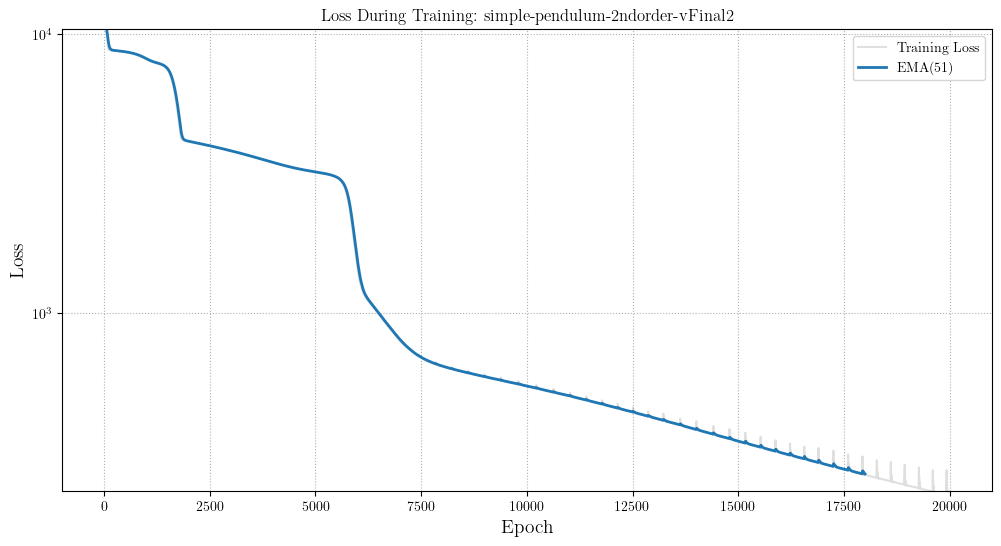

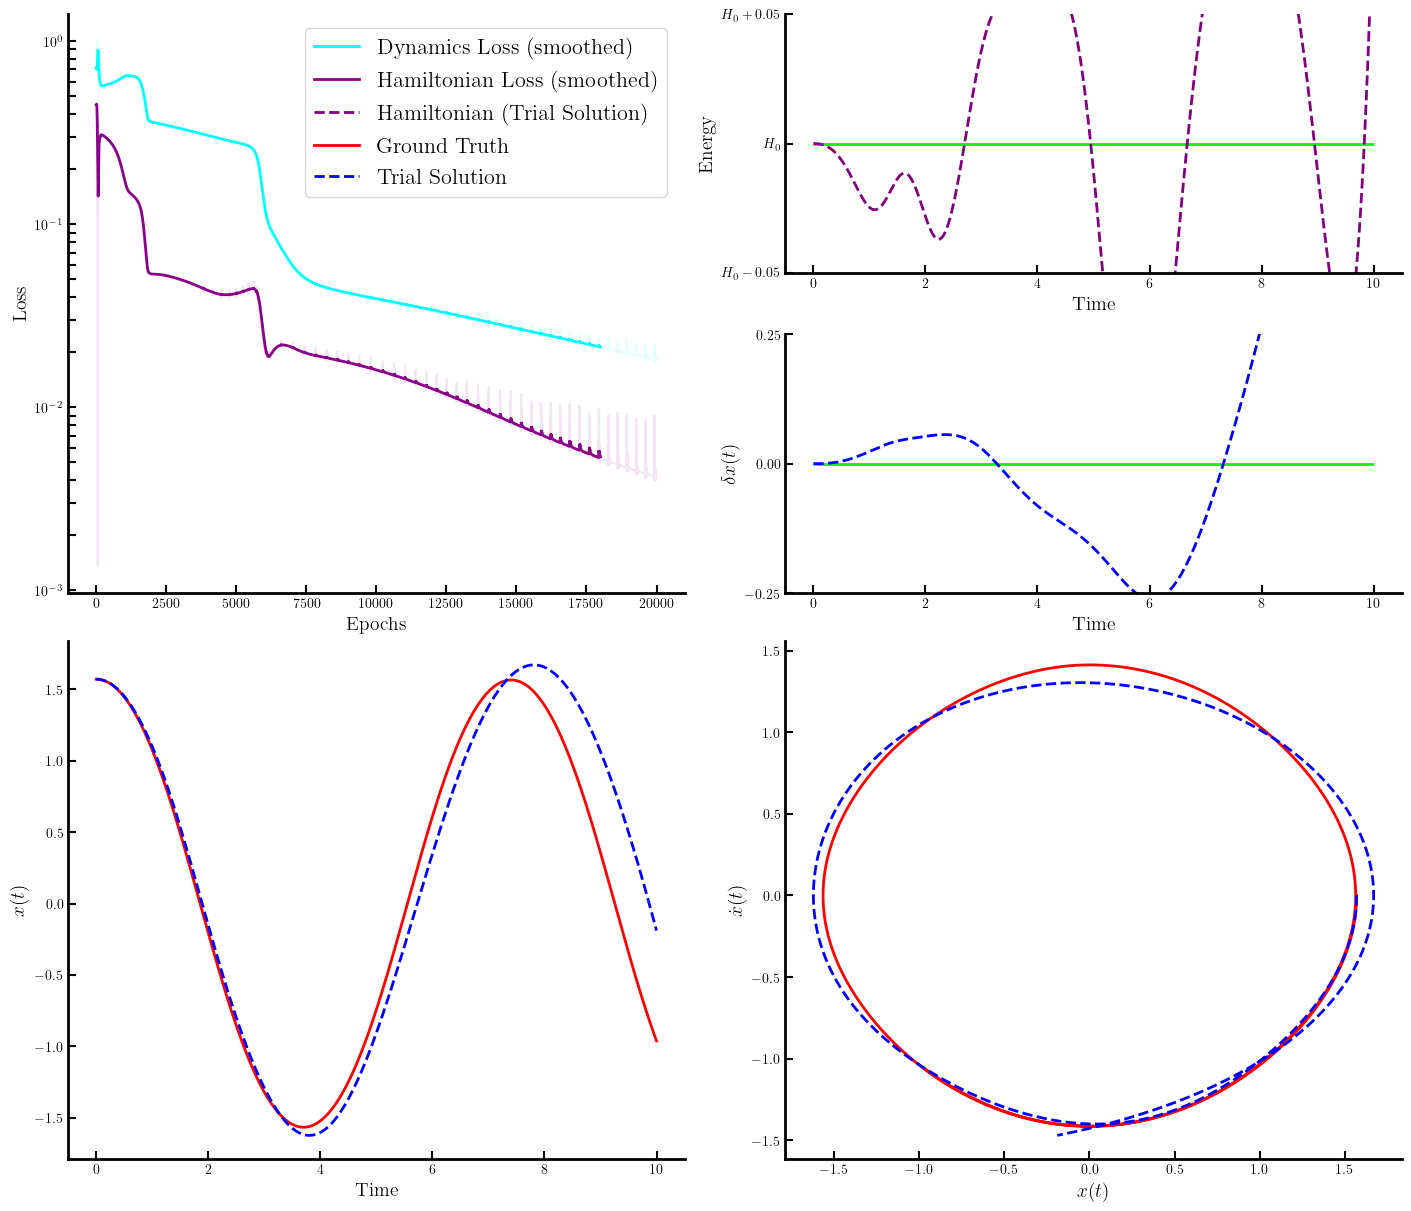

In [3]:
def main():
    lr_grid      = [1e-3, 1e-4, 1e-5]
    coeffs_grid = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0), (1.0, 1.0, 1.0)]

    for lr in lr_grid:
        for _coeffs in coeffs_grid:
            boundary_type = "pvi"
            configuration = Configuration(
                seed=4235,
                features=[64, 64, 64, 64, 64],
                activation_function=th.nn.Tanh(),
                learning_rate=lr,
                epochs =20_000,
                steps=10_000,
            )

            equations = PendulumChapter2nd(
                function="x",
                domain=(0,10),
                initial_conditions={
                    "x": (0, np.pi/2),
                    "y": (0, 0.0),
                },
                coeffs = _coeffs,
                boundary_type=boundary_type
            )

            model = Model(
                name="simple-pendulum-2ndorder-vFinal2",
                configuration=configuration,
                system_equations=equations,
            )

            model.train()
            model.test3()

if __name__ == "__main__":
    main()